# TODO:
 - Implement all systematics
 - Weighted center of bins
 - Check coszen interpolator from flux table

## Preliminaries

In [1]:
use_MCEq = False

In [2]:
import numpy as np, matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import scipy
from matplotlib.patches import Rectangle

In [3]:
# Read in the mc
neutrinos = np.genfromtxt("./neutrino_mc.csv", delimiter=',', names=True)
muons = np.genfromtxt("./muon_mc.csv", delimiter=',', names=True)

In [4]:
# Read in the hyperplane parameters
hp_nue_cc = np.genfromtxt("./hyperplanes_nue_cc.csv", delimiter=',', names=True)
hp_numu_cc = np.genfromtxt("./hyperplanes_numu_cc.csv", delimiter=',', names=True)
hp_nutau_cc = np.genfromtxt("./hyperplanes_nutau_cc.csv", delimiter=',', names=True)
hp_nu_nc = np.genfromtxt("./hyperplanes_all_nc.csv", delimiter=',', names=True)
hp_muons = np.genfromtxt("hyperplanes_muon.csv", delimiter=',', names=True)

In [5]:
# The bestfit values for Analysis A NC+CC from Table 2
best_fit = {'ice_absorption': 101.5,
            'ice_scattering': 103.0,
            'opt_eff_headon': -0.63,
            'opt_eff_lateral': 0.49,
            'opt_eff_overall': 98.4,
            'coin_fraction': 0.01,
            'delta_m32': 2.53e-3,
            'theta_23': 49.8,
            'theta_13': 8.5,
            'spectral_index': 0.03,
            'nu_tau_norm': 0.73,
            'NC_norm': 1.05,
            'nue_numu_ratio': 1.05,
            }

## Functions

### Weight modification (from hyperplanes)

In [6]:
# Write the function definition for neutrinos
# This will take the values for each parameter and return
# the modified weight for each event
def apply_neutrinos(neutrinos=neutrinos,
                    hyperplanes = {0: hp_nu_nc,
                                   12: hp_nue_cc,
                                   14: hp_numu_cc,
                                   16: hp_nutau_cc,},
                    ice_absorption = 100.0,
                    ice_scattering = 100.0,
                    opt_eff_headon = 0.0,
                    opt_eff_lateral = 0.0,
                    opt_eff_overall = 100.0,
                    coin_fraction = 0.0,
                    **kwargs):
    
    # Copy the weights so we can modify them and 
    # assign an "interaction type" corresponding to
    # nue CC, numu CC, nutau CC or NC
    output_weights = np.copy(neutrinos['weight'])
    int_type = np.copy(neutrinos['pdg']).astype(int)
    int_type[neutrinos['type']==0] = 0 
    int_type = np.abs(int_type)

    # Apply each neutrino flavor separately using the PDG
    # codes for each. Note that we're using 0 for NC interactions
    # and 12/14/16 for nue/numu/nutau CC interactions respectively
    for flavor, hp in hyperplanes.items():
        bins_cz = -hyperplanes[flavor]['reco_coszen'] # Wrong sign of coszen, Tania
        bins_en = hyperplanes[flavor]['reco_energy']
        bins_pid = hyperplanes[flavor]['pid']
        bins = np.array([bins_cz, bins_en, bins_pid]).T
        
        modifications = hp['offset'] + \
                        hp['ice_scattering'] * (ice_scattering-100)/100. +\
                        hp['ice_absorption'] * (ice_absorption-100)/100. +\
                        hp['opt_eff_lateral'] * (10*opt_eff_lateral) +\
                        hp['opt_eff_headon'] * (opt_eff_headon) +\
                        hp['opt_eff_overall'] * (opt_eff_overall-100)/100. +\
                        hp['coin_fraction'] * (coin_fraction)
        
        # Apply the modifications for a single neutrino flavor
        for i, b in enumerate(bins):
            mask = (int_type==flavor)
            mask &= (neutrinos['reco_coszen'] == b[0]) # TBD: Check if sign is correct. Should be fine because MC has no wrong sign
            mask &= (neutrinos['reco_energy'] == b[1])
            mask &= (neutrinos['pid'] == b[2])
            output_weights[mask] *= modifications[i]
        
    return output_weights
        

In [7]:
# Write the function definition for muons
# This will take the values for each parameter and return
# the modified weight for each event
def apply_muons(muons=muons,
                hyperplane = hp_muons,
                ice_absorption = 100.0,
                ice_scattering = 100.0,
                opt_eff_headon = 0.0,
                opt_eff_lateral = 0.0,
                opt_eff_overall = 100.0,
                **kwargs):
    
    # Copy the weights so we can modify them
    output_weights = np.copy(muons['weight'])

    # Get the bins for the muons
    bins_cz = -hyperplane['reco_coszen'] # Wrong sign of coszen, Tania
    bins_en = hyperplane['reco_energy']
    bins_pid = hyperplane['pid']
    bins = np.array([bins_cz, bins_en, bins_pid]).T

    # Calculate the modifications    
    modifications = hyperplane['offset'] +\
        hyperplane['ice_scattering']*(ice_scattering-100)/100. +\
        hyperplane['opt_eff_lateral']*(10*opt_eff_lateral) +\
        hyperplane['opt_eff_headon']*(opt_eff_headon) +\
        hyperplane['ice_absorption']*(np.exp(hyperplane['ice_absorption_expslope']*(ice_absorption/100.-1.0))-1) +\
        hyperplane['opt_eff_overall']*(np.exp(hyperplane['opt_eff_overall_expslope']*(opt_eff_overall/100.-1.0))-1)

    total_mask = np.zeros(len(muons)).astype(int)

    # Apply the modifications to the muon weights
    for i, b in enumerate(bins):
        mask = (muons['reco_coszen'] == b[0]) # TBD: Check if sign is correct. Should be fine because MC has no wrong sign
        mask &= (muons['reco_energy'] == b[1])
        mask &= (muons['pid'] == b[2])
        output_weights[mask] *= modifications[i]
        total_mask += mask.astype(int)

    assert (total_mask == 1).all(), "Some muons were not modified, or modified more than once!"
    
    return output_weights
        

In [8]:
# Sanity checks for the code above so that the masks work as intended
for variable in ["reco_energy", "reco_coszen", "pid"]: # TBD: Check if sign is correct
    hp_unique = np.sort(np.unique(hp_muons[variable]))
    for hp_plane in [hp_nu_nc, hp_nue_cc, hp_numu_cc, hp_nutau_cc]:
        assert np.all(np.sort(np.unique(hp_plane[variable])) == hp_unique)
    
    for dataset, hp_plane in zip([muons, neutrinos], [hp_muons, hp_nu_nc]):
        assert np.all(np.sort(np.unique(muons[variable])) == np.sort(np.unique(hp_plane[variable])))

### Additional weigt modification to include all best fit parameters

In [11]:
def apply_spectral_index(delta_gamma=best_fit['spectral_index']):
    return np.power(neutrinos['reco_energy'], delta_gamma)

def apply_nue_numu_ratio(neutrino_weights, nue_numu_ratio=best_fit['nue_numu_ratio']):
    # Extract CC nue and nume neutrinos
    # - type: interaction type where 0 = any neutral current (NC), 1 = charged current quasi elastic (CC_QE), 2 = charged current resonant (CC_RES), 3 = charged current deep inelastic (CC_DIS), 4 = coherent scattering
    NC_int_type = (neutrinos["type"] == 0).astype(int) # NC is 0
    CC_int_type = (neutrinos["type"] > 0).astype(int) # CC is 1, 2, 3, (4 not, but only .7% of the data)
    CC_int_type[(CC_int_type == 1) & (np.abs(neutrinos["pdg"]) == 14)] = 2 # CC_mu is 2
    CC_int_type[(CC_int_type == 1) & (np.abs(neutrinos["pdg"]) == 16)] = 3 # CC_tau is 3

    e_CC = neutrinos[CC_int_type == 1]
    mu_CC = neutrinos[CC_int_type == 2]

    # Current counts
    nue_count = neutrino_weights[CC_int_type == 1].sum()
    numu_count = neutrino_weights[CC_int_type == 2].sum()
    
    # Adjust the nue count to match the desired count
    adjustment_factor = nue_numu_ratio

    # Create an array with the same shape as neutrinos that is one everywhere except if np.abs(neutrinos['pdg']) == 12
    mask = np.abs(neutrinos['pdg']) == 12
    output_array = np.ones_like(neutrinos['pdg'])
    output_array[mask] *= adjustment_factor

    return output_array

### Functions for apllying MCEq flux

In [12]:
if use_MCEq:
    # Calculate the the flux with MCEq and plot it
    # This is obsolete for the final analysis, because IceCube used Honda 2015 spl solar min aa
    from MCEq.core import MCEqRun
    import crflux.models as crf
    import matplotlib.pyplot as plt

    def atmo_nu_flux_mceq(theta_deg=0.0):
        # Initalize MCEq by creating the user interface object MCEqRun
        mceq = MCEqRun(

            # High-energy hadronic interaction model
            interaction_model='SIBYLL23C',

            # cosmic ray flux at the top of the atmosphere
            primary_model = (crf.HillasGaisser2012, 'H3a'),

            # zenith angle
            theta_deg = 0.

        )
        mceq.set_theta_deg(theta_deg)
        mceq.solve()
        #mceq.pman.print_particle_tables(0)
        enubar = mceq.get_solution('antinue')
        enu = mceq.get_solution('nue')
        munubar = mceq.get_solution('antinumu')
        munu = mceq.get_solution('numu')
        taunubar = mceq.get_solution('antinutau')
        taunu = mceq.get_solution('nutau') 

        return mceq, enu, munu, taunu, enubar, munubar, taunubar

    mceq, enu, munu, taunu, enubar, munubar, taunubar = atmo_nu_flux_mceq(theta_deg=89.0)

    # Plot the flux for each flavor as a function of energy
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    ax = ax.flatten()
    flavors = ['nue', 'numu', 'nutau']

    ax[0].loglog(mceq.e_grid, enu, label=flavors[0])
    ax[0].loglog(mceq.e_grid, munu, label=flavors[1])
    ax[0].loglog(mceq.e_grid, taunu, label=flavors[2])
    ax[0].set_xlabel('Energy [GeV]')
    ax[0].set_xlim(.1, 100)
    ax[0].set_ylabel('Flux [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
    ax[0].set_ylim(1e-12, 1e0)
    ax[0].set_title('Neutrinos')
    ax[0].legend()
    # Anti-neutrinos
    ax[1].loglog(mceq.e_grid, enubar, label=flavors[0])
    ax[1].loglog(mceq.e_grid, munubar, label=flavors[1])
    ax[1].loglog(mceq.e_grid, taunubar, label=flavors[2])
    ax[1].set_xlabel('Energy [GeV]')
    ax[1].set_xlim(.1, 100)
    ax[1].set_ylabel('Flux [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
    ax[1].set_ylim(1e-12, 1e0)
    ax[1].set_title('Anti-neutrinos')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [13]:
if use_MCEq:
    # Calculate the flux for different zenith angles
    zenith_angles = np.arccos(np.linspace(0, 1, 15, endpoint=True)[::-1])*180/np.pi

    mceq_dict = {}
    for theta in zenith_angles:
        mceq, enu, munu, taunu, enubar, munubar, taunubar = atmo_nu_flux_mceq(theta)
        mceq_dict[theta] = mceq

In [14]:
if use_MCEq:
    # Sanity checks of MCEq flux
    print("Minimum and maximum values interpolator energy: ", min(mceq_dict[zenith_angles[0]].e_grid), max(mceq_dict[zenith_angles[0]].e_grid))
    print("Minimum and maximum values interpolator zenith angles: ", min(zenith_angles), max(zenith_angles))
    print("Minimum and maximum values interpolator coszen: ", min(np.cos(zenith_angles*np.pi/180+np.pi/2)), max(np.cos(zenith_angles*np.pi/180)))
    print(" Minimum and maximum values neutrinos energy: ", min(neutrinos['true_energy']), max(neutrinos['true_energy']))
    print(" Minimum and maximum values neutrinos coszen: ", min(neutrinos['true_coszen']), max(neutrinos['true_coszen']))


### Functions for normalization

This is not part of the readme

In [15]:
def muon_norm(muon_weights, n_muons):
    """Calculate the normalization constant for muons"""
    mc_count = np.sum(muon_weights)
    return n_muons / mc_count


def neutrino_norm(neutrinos=neutrinos, nu_tau_norm=best_fit['nu_tau_norm'], NC_norm=best_fit['NC_norm'], **kwargs):
    """
    Apply the normalization factors to the neutrino weights.
    """
    weights = np.ones(neutrinos['weight'].shape)
    # Tau neutrino normalization (table II)
    weights[np.abs(neutrinos['pdg']) == 16] *= nu_tau_norm
    # NC normalization (table II)
    weights[neutrinos['type'] == 0] *= NC_norm
    return weights

def neutrino_total_norm(neutrino_weights, n_neutrinos):
    """Normalize the total neutrino count to be the same as in table I"""
    return n_neutrinos / neutrino_weights.sum()


### Functions for osc. probabilities

In [16]:
# Defalt values
EARTH_DIAMETER_km = 12742.
EARTH_RADIUS_km = EARTH_DIAMETER_km / 2.
DEFAULT_ATMO_PROD_HEIGHT_km = 20. # Value used in arxiv:1707.07081
DEFAULT_ATMO_DETECTOR_DEPTH_km = 1. # Value used in nuSQuIDS
km_to_eV = 5.06773093741e9 # [km] -> [1/eV]
GeV_to_eV = 1e9 # [GeV] -> [eV]

def calc_path_length_from_coszen(cz, r=EARTH_RADIUS_km, h=DEFAULT_ATMO_PROD_HEIGHT_km, d=DEFAULT_ATMO_DETECTOR_DEPTH_km) :
    '''
    Get the path length (baseline) for an atmospheric neutrino,
    given some cos(zenith angle).

    cz = cos(zenith) in radians, to be converted to path length in km
    r = Radius of Earth, in km
    h = Production height in atmosphere, in km
    d = Depth of detector (w.r.t. Earth's radius), in km
    '''
    return -r*cz +  np.sqrt( (r*cz)**2 - r**2 + (r+h+d)**2 )

def muon_survival_prob(L_km=None, E_GeV=None, L_km_over_E_GeV=None, best_fit=best_fit):
    '''
    Prediction of muon survival probability
    '''
    km_to_eV = 5.06773093741e9 # [km] -> [1/eV]
    GeV_to_eV = 1e9 # [GeV] -> [eV]
    Umu3 = np.sin(best_fit["theta_23"])*np.cos(best_fit["theta_13"])
    
    if L_km_over_E_GeV is None:
        #return 1 - 4*Umu3**2*(1-Umu3**2)*np.sin(1/4*km_to_eV/GeV_to_eV*best_fit["delta_m32"] * L_km/E_GeV)**2 # from arxiv:1707.07081
        return 1 - np.sin(2*np.deg2rad(best_fit["theta_23"]))**2 * np.sin(1/4*km_to_eV/GeV_to_eV*best_fit["delta_m32"] * L_km/E_GeV)**2
    else:
        #return 1 - 4*Umu3**2*(1-Umu3**2)*np.sin(1/4*km_to_eV/GeV_to_eV*best_fit["delta_m32"] * L_km_over_E_GeV)**2 # from arxiv:1707.07081
        return 1 - np.sin(2*np.deg2rad(best_fit["theta_23"]))**2 * np.sin(1/4*km_to_eV/GeV_to_eV*best_fit["delta_m32"] * L_km_over_E_GeV)**2
    
def tau_osciallation_prob(L_km=None, E_GeV=None, L_km_over_E_GeV=None, best_fit=best_fit):
    '''
    Prediction of tau oscillation probability
    '''
    km_to_eV = 5.06773093741e9 # [km] -> [1/eV]
    GeV_to_eV = 1e9 # [GeV] -> [eV]
    
    if L_km_over_E_GeV is None:
        #return np.cos(best_fit["theta_23"])**4*np.sin(2*np.deg2rad(best_fit["theta_23"]))**2 * np.sin(1/4*km_to_eV/GeV_to_eV*best_fit["delta_m32"] * L_km/E_GeV)**2
        return np.sin(2*np.deg2rad(best_fit["theta_23"]))**2 * np.sin(1/4*km_to_eV/GeV_to_eV*best_fit["delta_m32"] * L_km/E_GeV)**2
    else:
        return np.sin(2*np.deg2rad(best_fit["theta_23"]))**2 * np.sin(1/4*km_to_eV/GeV_to_eV*best_fit["delta_m32"] * L_km_over_E_GeV)**2
        #return np.cos(best_fit["theta_23"])**4*np.sin(2*np.deg2rad(best_fit["theta_23"]))**2 * np.sin(1/4*km_to_eV/GeV_to_eV*best_fit["delta_m32"] * L_km_over_E_GeV)**2

def oscillation_probabilities(neutrinos=neutrinos, 
                       delta_m32: float = 2.53e-3, # eV^2
                       theta_23: float = 49.8, # Degrees
                       **kwargs):
    """
    Calculate neutrino oscillation probabilities.
    For electrons, we set the weights to 1.
    For muons, the return value is P(nu_mu -> nu_mu) = 1 - P(nu_mu -> nu_tau)
    For taus, the return value is P(nu_mu -> nu_tau)
    """
    probabilities = np.ones(neutrinos.shape[0])
    
    is_nu_mu = np.abs(neutrinos['pdg']) == 14
    is_nu_tau = np.abs(neutrinos['pdg']) == 16

    r = 1.3e4/2 # Earth radius [km]
    a = 20 # distance from atmosphere to IceCube [km]
    # Calculate distance traveled by the neutrinos as a function of their true cosZ.
    # This equation can be derived using simple geometry and the law of cosines
    #distance = -neutrinos["true_coszen"] * (r-a) + np.sqrt(neutrinos["true_coszen"]**2 * (r-a)**2 - (a**2 - 2*a*r))
    distance = calc_path_length_from_coszen(neutrinos["true_coszen"])
    assert np.all(distance >= 20), "Distance is negative!"
    probabilities[is_nu_mu] = 1 - np.sin(2*np.deg2rad(theta_23))**2 * np.sin(1.27 * delta_m32 * distance[is_nu_mu] / neutrinos[is_nu_mu]['true_energy'])**2
    probabilities[is_nu_tau] = np.sin(2*np.deg2rad(theta_23))**2 * np.sin(1.27 * delta_m32 * distance[is_nu_tau] / neutrinos[is_nu_tau]['true_energy'])**2

    assert np.all(probabilities >= 0), "Probabilities are negative!"
    # assert np.all(probabilities <= 1), "Probabilities are greater than 1!"
    
    return probabilities

### Functions for applying Honda fluxes

In [17]:
# Changed honda table to 2015 South Pole solmin
def get_honda_fluxes(filename: str = "nu_flux_honda_table_2015_spl_solmin.txt"):
    # Create a dict with the pdg as key and an array as value.
    # The arrays are of shape (n, 3) with the energy, cosZ angle, and flux
    fluxes = {-14: [], -12: [], 12: [], 14: []}

    with open(filename) as f:
        for line in f:
            # If the line starts without a space, it contains the cosZ value range (which we take the average over)
            if line[0] != " ":
                cos1, cos2 = float(line[23:27]), float(line[32:36])
                # To make the interpolation work for all values of cosZ, place the outermost points at the edges, i.e., 1 and -1
                if cos1 == 1. or cos2 == 1.:
                    cosZ = 1.
                elif cos1 == -1. or cos2 == -1.:
                    cosZ = -1
                # For other values of cosZ, take the average of the upper and lower bounds
                else:
                    cosZ = (cos1 + cos2)/2
                continue
            
            # If the line starts with a space but the second , it contains numbers
            elif not line[1].isnumeric():
                continue
            
            # Otherwise, it contains the energy and fluxes
            energy, numu_flux, numubar_flux, nue_flux, nuebar_flux = [float(value) for value in line.split()]
            # Maybe the Honda model uses the opposite convention for cosZ?LinearNdIterpoltor is not subscriptable
            # cosZ = -cosZ
            fluxes[12].append([energy, cosZ, nue_flux])
            fluxes[14].append([energy, cosZ, numu_flux])
            fluxes[-12].append([energy, cosZ, nuebar_flux])
            fluxes[-14].append([energy, cosZ, numubar_flux])
    # TODO check that the angle is read correctly.
    fluxes = {key: np.array(value) for key, value in fluxes.items()}
    flux_interpolators = {pdg: scipy.interpolate.LinearNDInterpolator(value[:, :2], value[:, 2]) for pdg, value in fluxes.items()}
    return flux_interpolators

In [18]:
# Assuming nu_mu and nu_tau fluxes are the same and normalizing observed nu_tau later
def apply_flux_honda(neutrinos=neutrinos,
               delta_m32: float = 2.53e-3, # eV^2
               theta_23: float = 49.8, # Degrees
               **kwargs):
    """
    Calculate the flux for the neutrinos based on their true energy and cosZ.
    The Honda flux tables are used.

    Also apply neutrino oscillation probabilities to the weights.
    The weight of a certain (cosZtrue, Etrue) nu_mu is multiplied by P(nu_mu -> nu_mu)
    The weight of a certain (cosZtrue, Etrue) nu_tau is multiplied by P(nu_mu -> nu_tau)
    """
    flux_interpolators = get_honda_fluxes()
    # Apply oscillation probabilities
    oscillation_weights = oscillation_probabilities(neutrinos=neutrinos,
                                delta_m32=delta_m32,
                                theta_23=theta_23)
    # Multiply oscillation weights with the fluxes, where the nu_tau fluxes are simply the muon fluxes
    for pdg in np.unique(neutrinos["pdg"]):
        mask = neutrinos['pdg'] == pdg
        if pdg == 16:
            interpolator = flux_interpolators[14]
        elif pdg == -16:
            interpolator = flux_interpolators[-14]
        else:
            interpolator = flux_interpolators[pdg]

        interpolated_flux = interpolator(neutrinos[mask]['true_energy'], neutrinos[mask]['true_coszen']) # TBD: Check if sign is correct
        #print("\ninterpolated_flux old: \n", interpolated_flux)
        # If the energy of the neutrino is outside the energy range given by the Honda flux table, there are 3 options:
        # - use the flux of the maximum energy allowed by the Honda table, which is 10_000.
        # - drop the events entirely
        # - TODO Use the approximation of E^(-3.7) from the last two points in the Honda table for that zenith angle and extrapolate.
        if (nan_loc := np.isnan(interpolated_flux)).any():
            interpolated_flux[nan_loc] = 0 #interpolator(1e4, neutrinos[mask][nan_loc]["true_coszen"])
        
        if np.abs(pdg) == 16:
            oscillation_weights[mask] *= interpolated_flux
        else:
            oscillation_weights[mask] *= interpolated_flux

    # convert from flux in #particles / (m^2 sec sr GeV) to #particles / sec
    # The cross section of DeepCore depends on the zenith angle
    # but I assume it to be the same for all angles for now.
    # In that case, the cross section does not really matter, since we normalize the events to the number of neutrinos.
    # It is approximately 300 m x 300 m x 300 m, based on Fig. 1 in the paper.
    # NOTE: I cannot multiply by the energy, as that results in a massive discrepancy. 
    # I guess the weights already take it into account, or there is something with integration that makes it unnecessary.
    # oscillation_weights *= 300**2 * neutrinos["true_energy"]
    
    return oscillation_weights

def apply_flux_honda_unosc(neutrinos=neutrinos, **kwargs):
    '''
    Return the weights without oscillation probabilities
    This doesn't work because of the normalization etc. later on
    '''
    flux_interpolators = get_honda_fluxes()
    weights = np.ones(neutrinos.shape[0])

    # Multiply weights with the fluxes, where the nu_tau fluxes are simply the muon fluxes
    for pdg in np.unique(neutrinos["pdg"]):
        mask = neutrinos['pdg'] == pdg
        if pdg == 16:
            interpolator = flux_interpolators[14]
        elif pdg == -16:
            interpolator = flux_interpolators[-14]
        else:
            interpolator = flux_interpolators[pdg]

        interpolated_flux = interpolator(neutrinos[mask]['true_energy'], neutrinos[mask]['true_coszen'])
        
        # Set energies outside hoda flux table range to 0 
        if (nan_loc := np.isnan(interpolated_flux)).any():
            interpolated_flux[nan_loc] = 0

        weights[mask] *= interpolated_flux

    return weights

Maybe try a mix, where the tau neutrino flux is taken from MCEq? Or as a first step muon flux *1e-4

Eventhough tau neutrinos are sub-dominant multiplication with the muon neutrino flux could artificially increase them? 

### Functions for applying MCEq fluxes

In [19]:
if use_MCEq:
    # Functions for applying MCEq flux
    def get_MCEq_flux_interpolator(flavor, mceq_dict=mceq_dict):
        """
        Create an interpolator for the MCEq fluxes.
        """
        from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
        import numpy as np

        x = [e for _ in range(2*len(zenith_angles)) for e in mceq_dict[zenith_angles[0]].e_grid]
        y = [np.cos(angle*np.pi/180+sign) for sign in [0, np.pi/2] for angle in zenith_angles for _ in range(len(mceq_dict[zenith_angles[0]].e_grid))] 
        # sign loop is to make the interpolation work for all values of cosZ, since the MCEq fluxes are only calculated for cosZ > 0
        #print("y: ", y)
        z = np.zeros((2*len(zenith_angles), len(mceq_dict[zenith_angles[0]].e_grid)))
        for k in [0, len(zenith_angles)]:
            for i,key in enumerate(mceq_dict.keys()):
                for j in range(len(mceq_dict[key].e_grid)):
                    z[i+k][j] = mceq_dict[key].get_solution(flavor)[j]*(1e4) # MCeq flux in #particles / (cm^2 sec sr GeV) to #particles / (m² sec GeV)
        z = z.reshape(-1,1)


        interpolator = NearestNDInterpolator(list(zip(x, y)), z) # NearestNDInterpolator worked where LinearNDInterpolator didn't
        return interpolator


    def apply_flux_mceq(neutrinos=neutrinos,
                delta_m32: float = 2.53e-3, # eV^2
                theta_23: float = 49.8, # Degrees
                **kwargs):
        """
        Calculate the flux for the neutrinos based on their true energy and cosZ.
        The MCEq flux is used.

        Also apply neutrino oscillation probabilities to the weights.
        The weight of a certain (cosZtrue, Etrue) nu_mu is multiplied by P(nu_mu -> nu_mu)
        The weight of a certain (cosZtrue, Etrue) nu_tau is multiplied by P(nu_mu -> nu_tau)
        """

        flavors = ['nue', 'numu', 'nutau', 'antinue', 'antinumu', 'antinutau']
        # Apply oscillation probabilities
        oscillation_weights = oscillation_probabilities(neutrinos=neutrinos,
                                    delta_m32=delta_m32,
                                    theta_23=theta_23)
        
        # Multiply oscillation weights with the fluxes, where the nu_tau fluxes are simply the muon fluxes
        for pdg in np.unique(neutrinos["pdg"]):
            mask = neutrinos['pdg'] == pdg
            if pdg == 12:
                interpolator = get_MCEq_flux_interpolator(flavor='nue')
            elif pdg == -12:
                interpolator = get_MCEq_flux_interpolator(flavor='antinue')
            elif pdg == 14:
                interpolator = get_MCEq_flux_interpolator(flavor='numu')
            elif pdg == -14:
                interpolator = get_MCEq_flux_interpolator(flavor='antinumu')
            elif pdg == 16:
                interpolator = get_MCEq_flux_interpolator(flavor='nutau')
            elif pdg == -16:
                interpolator = get_MCEq_flux_interpolator(flavor='antinutau')
            #print("true coszen: ", neutrinos[mask]['true_coszen'])
            interpolated_flux = interpolator(neutrinos[mask]['true_energy'], neutrinos[mask]['true_coszen']).flatten() # correct order
            #print("\ninterpolated_flux new: \n", interpolated_flux)
            # If the energy of the neutrino is outside the energy, cosZ range MCEq flux is set to nan
            oscillation_weights[mask] *= interpolated_flux # convert from #particles / (cm^2 sec sr GeV) to #particles / (m² sec GeV)

        # convert from flux in #particles / (m^2 sec sr GeV) to #particles / sec
        # The cross section of DeepCore depends on the zenith angle
        # but I assume it to be the same for all angles for now.
        # In that case, the cross section does not really matter, since we normalize the events to the number of neutrinos.
        # It is approximately 300 m x 300 m x 300 m, based on Fig. 1 in the paper.
        # NOTE: I cannot multiply by the energy, as that results in a massive discrepancy. 
        # I guess the weights already take it into account, or there is something with integration that makes it unnecessary.
        # oscillation_weights *= 300**2 * neutrinos["true_energy"]
        
        return oscillation_weights

In [20]:
# Using nu_tau fluxes from MCEq
def apply_flux_honda_with_MCEq_nutau(neutrinos=neutrinos,
               delta_m32: float = 2.53e-3, # eV^2
               theta_23: float = 49.8, # Degrees
               **kwargs):
    """
    Calculate the flux for the neutrinos based on their true energy and cosZ.
    The Honda flux tables are used.

    Also apply neutrino oscillation probabilities to the weights.
    The weight of a certain (cosZtrue, Etrue) nu_mu is multiplied by P(nu_mu -> nu_mu)
    The weight of a certain (cosZtrue, Etrue) nu_tau is multiplied by P(nu_mu -> nu_tau)
    """
    flux_interpolators = get_honda_fluxes()
    # Apply oscillation probabilities
    oscillation_weights = oscillation_probabilities(neutrinos=neutrinos,
                                delta_m32=delta_m32,
                                theta_23=theta_23)
    # Multiply oscillation weights with the fluxes, where the nu_tau fluxes are simply the muon fluxes
    for pdg in np.unique(neutrinos["pdg"]):
        mask = neutrinos['pdg'] == pdg
        if pdg == 16:
            interpolator = get_MCEq_flux_interpolator(flavor='nutau')
        elif pdg == -16:
            interpolator = get_MCEq_flux_interpolator(flavor='antinutau')
        else:
            interpolator = flux_interpolators[pdg]

        if pdg == 16 or pdg == -16:
            interpolated_flux = interpolator(neutrinos[mask]['true_energy'], neutrinos[mask]['true_coszen']).flatten()
        else:
            interpolated_flux = interpolator(neutrinos[mask]['true_energy'], neutrinos[mask]['true_coszen']) # TBD: Check if sign is correct
        #print("\ninterpolated_flux old: \n", interpolated_flux)
        # If the energy of the neutrino is outside the energy range given by the Honda flux table, there are 3 options:
        # - use the flux of the maximum energy allowed by the Honda table, which is 10_000.
        # - drop the events entirely
        # - TODO Use the approximation of E^(-3.7) from the last two points in the Honda table for that zenith angle and extrapolate.
        if (nan_loc := np.isnan(interpolated_flux)).any():
            interpolated_flux[nan_loc] = 0 #interpolator(1e4, neutrinos[mask][nan_loc]["true_coszen"])
        
        if np.abs(pdg) == 16:
            oscillation_weights[mask] *= interpolated_flux
        else:
            oscillation_weights[mask] *= interpolated_flux

    # convert from flux in #particles / (m^2 sec sr GeV) to #particles / sec
    # The cross section of DeepCore depends on the zenith angle
    # but I assume it to be the same for all angles for now.
    # In that case, the cross section does not really matter, since we normalize the events to the number of neutrinos.
    # It is approximately 300 m x 300 m x 300 m, based on Fig. 1 in the paper.
    # NOTE: I cannot multiply by the energy, as that results in a massive discrepancy. 
    # I guess the weights already take it into account, or there is something with integration that makes it unnecessary.
    # oscillation_weights *= 300**2 * neutrinos["true_energy"]
    
    return oscillation_weights

## Honda vs MCEq
Compare Honda flux to MCEq flux

In [92]:
if use_MCEq:
    # Plot comparioson of MCEq and Honda fluxes
    # Read in the Honda flux
    fluxes = {-14: [], -12: [], 12: [], 14: []}

    with open("nu_flux_honda_table.txt") as f:
        for line in f:
            # If the line starts without a space, it contains the cosZ value range (which we take the average over)
            if line[0] != " ":
                cos1, cos2 = float(line[23:27]), float(line[32:36])
                # To make the interpolation work for all values of cosZ, place the outermost points at the edges, i.e., 1 and -1
                # if cos1 == 1. or cos2 == 1.:
                #     cosZ = 1.
                # elif cos1 == -1. or cos2 == -1.:
                #     cosZ = -1
                # # For other values of cosZ, take the average of the upper and lower bounds
                # else:
                #     cosZ = (cos1 + cos2)/2
                # continue
                cosZ = (cos1 + cos2)/2
            # If the line starts with a space but the second , it contains numbers
            elif not line[1].isnumeric():
                continue
            
            # Otherwise, it contains the energy and fluxes
            energy, numu_flux, numubar_flux, nue_flux, nuebar_flux = [float(value) for value in line.split()]
            # Maybe the Honda model uses the opposite convention for cosZ?LinearNdIterpoltor is not subscriptable
            # cosZ = -cosZ
            fluxes[12].append([energy, cosZ, nue_flux])
            fluxes[14].append([energy, cosZ, numu_flux])
            fluxes[-12].append([energy, cosZ, nuebar_flux])
            fluxes[-14].append([energy, cosZ, numubar_flux])
    #
    # Get Honda flux at the horizon
    #
    horizon_flux = {-14: [], -12: [], 12: [], 14: []}
    # print all values of fluxes[12] for cosZ = 0.0
    for j in range(len(fluxes[12])):
            if fluxes[12][j][1] <= 0.05 and fluxes[12][j][1] > -0.05:
                horizon_flux[12].append(fluxes[12][j])
            if fluxes[14][j][1] <= 0.05 and fluxes[14][j][1] > -0.05:
                horizon_flux[14].append(fluxes[14][j])
            if fluxes[-12][j][1] <= 0.05 and fluxes[-12][j][1] > -0.05:
                horizon_flux[-12].append(fluxes[-12][j])
            if fluxes[-14][j][1] <= 0.05 and fluxes[-14][j][1] > -0.05:
                horizon_flux[-14].append(fluxes[-14][j])
    # numpify the horizon_flux
    for key, value in horizon_flux.items():
        horizon_flux[key] = np.array(value)

    #
    # Get Honda flux at a specific cosZ
    #     
    coszenup = -0.9
    coszenlow = -1
    other_flux = {-14: [], -12: [], 12: [], 14: []}
    for j in range(len(fluxes[12])):
        if fluxes[12][j][1] <= coszenup and fluxes[12][j][1] >= coszenlow:
            other_flux[12].append(fluxes[12][j])
        if fluxes[14][j][1] <= coszenup and fluxes[14][j][1] >= coszenlow:
            other_flux[14].append(fluxes[14][j])
        if fluxes[-12][j][1] <= coszenup and fluxes[-12][j][1] >= coszenlow:
            other_flux[-12].append(fluxes[-12][j])
        if fluxes[-14][j][1] <= coszenup and fluxes[-14][j][1] >= coszenlow:
            other_flux[-14].append(fluxes[-14][j]) 
    # numpify the other_flux
    for key, value in other_flux.items():
        other_flux[key] = np.array(value)


    # Convert the values in fluxes to numpy arrays
    fluxes = {key: np.array(value) for key, value in fluxes.items()}

    #
    # Plot the flux for each flavor as a function of energy
    #
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    ax = ax.flatten()
    flavors = ['nue', 'numu', 'nutau']
    num =0
    # Neutrinos
    for i, (flux, label) in enumerate(zip(["nue", "numu", "nutau"], flavors)):
        ax[0].loglog(mceq_dict[zenith_angles[num]].e_grid, mceq_dict[zenith_angles[num]].get_solution(flux)*(1e4), label=label)
    # Horizon flux
    #ax[0].loglog(horizon_flux[12][:,0], horizon_flux[12][:,2], label="nue Honda")
    #ax[0].loglog(horizon_flux[14][:,0], horizon_flux[14][:,2], label="numu Honda")    
    # Flux at specific cosZ
    ax[0].loglog(other_flux[12][:,0], other_flux[12][:,2], label="nue Honda")
    ax[0].loglog(other_flux[14][:,0], other_flux[14][:,2], label="numu Honda")
    for j, (pdg, flux) in enumerate(zip([12, 14, 16], [fluxes[12], fluxes[14], fluxes[14]])): # assume tau flux is the same as muon flux
        ax[0].set_xlabel('Energy [GeV]')
        ax[0].set_xlim(.1, 1e4)
        ax[0].set_ylabel('Flux [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]') # Honda flux (m^2 sec sr GeV)^-1
        ax[0].set_ylim(1e-9, 1e5)
        ax[0].set_title('Neutrinos')
        ax[0].legend()

    # Anti-neutrinos
    for i, (flux, label) in enumerate(zip(["antinue", "antinumu", "antinutau"], flavors)):
        ax[1].loglog(mceq_dict[90.0].e_grid, mceq_dict[90.0].get_solution(flux)*(1e4), label=label)

    ax[1].loglog(horizon_flux[-12][:,0], horizon_flux[-12][:,2], label="antinue Honda")
    ax[1].loglog(horizon_flux[-14][:,0], horizon_flux[-14][:,2], label="antinumu Honda")
    for j, (pdg, flux) in enumerate(zip([-12, -14, -16], [fluxes[-12], fluxes[-14], fluxes[-14]])): # assume tau flux is the same as muon flux
        ax[1].set_xlabel('Energy [GeV]')
        ax[1].set_xlim(.1, 1e4)
        ax[1].set_ylabel('Flux [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
        ax[1].set_ylim(1e-9, 1e5)
        ax[1].set_title('Anti-neutrinos')
        ax[1].legend()

    plt.tight_layout()



Honda flux and MCEq flux agree for (anti)nue and (anti)numu

## Plot MC

### MCEq

In [93]:
if use_MCEq:
    # Make a plot of the neutrinos just to verify the shape is correct (MCEq)
    bins_en = np.log10([5.623413,  7.498942, 10. , 
                        13.335215, 17.782795, 23.713737, 
                        31.622776, 42.16965 , 56.23413])
    bins_cz = np.array([-1., -0.8, -0.6 , -0.4, -0.2, 
                        0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    bins_pid = np.array([0, 1, 2])

    # Choose the nuisance parameters for the detector systematics
    #neutrino_weights = neutrino_muons()
    neutrino_weights = apply_neutrinos(**best_fit)

    # A flux model must be assumed for the neutrinos
    # Here, use a simple flux of phi=800*E^-3.7 
    # Note that this is only for the purposes of an
    # example: fits performed using this sample should
    # use a numerical flux calculation such as the one
    # presented in PhysRevD.92.023004
    # I also apply neutrino oscillation probabilities
    neutrino_weights *= apply_flux_mceq(**best_fit)
    # Scale to the livetime of the data
    neutrino_weights *= 1006*24*3600. 
    # Scale neutrino weights based on the normalization constants for NC and nu_tau nuisance parameters
    neutrino_weights *= neutrino_norm(**best_fit)
    # Scale the neutrino weights based on the total number of neutrinos according to table I
    neutrino_weights *= neutrino_total_norm(neutrino_weights=neutrino_weights, n_neutrinos=62203-5022-93) # 93 noise triggers, 5022 atmospheric muons

    # save neutrino weights to txt file
    np.savetxt("neutrino_weights_mceq.txt", neutrino_weights)

    # Make the histogram, binning in energy, zenith, and pid
    nu_hist, edges = np.histogramdd([np.log10(neutrinos['reco_energy']),
                                    neutrinos['reco_coszen'],
                                    neutrinos['pid']],
                                    bins = [bins_en, bins_cz, bins_pid],
                                    weights = neutrino_weights)
    nu_hist = np.swapaxes(nu_hist, 0, 1)

    # Calculate the weighted error of each bin on the histogram
    # TODO this might be an incorrect way of calculating the statistical error 
    # caused by the limited MC statistics
    # Source: https://stackoverflow.com/questions/48227037/error-on-weighted-histogram-in-python
    nu_err = np.sqrt(
        np.histogramdd([np.log10(neutrinos['reco_energy']),
                        neutrinos['reco_coszen'],
                        neutrinos['pid']],
        bins = [bins_en, bins_cz, bins_pid],
        weights = neutrino_weights**2)[0]
    )
    # Swap axis 0 and 1 to match the data formagridflat and for easier plotting
    nu_err = np.swapaxes(nu_err, 0, 1)

    # Make a figure
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
    cmesh = ax1.pcolormesh(bins_en, 
                        bins_cz,
                        nu_hist[:,:,0],
                        cmap='Blues',
                        vmin=0, vmax=nu_hist.max())
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(cmesh, cax)

    cmesh = ax2.pcolormesh(bins_en, 
                        bins_cz,
                        nu_hist[:,:,1],
                        cmap='Blues',
                        vmin=0, vmax=nu_hist[:,:,1].max())
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(cmesh, cax)

    ax1.set_title('Cascade-like, Neutrinos MCEq')
    ax1.set_ylabel("Cos(Reco Zenith)")
    ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
    ax2.set_ylabel("Cos(Reco Zenith)")
    ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
    ax2.set_title('Track-like, Neutrinos MCEq')

    fig.tight_layout()

### Honda

##### with normalization

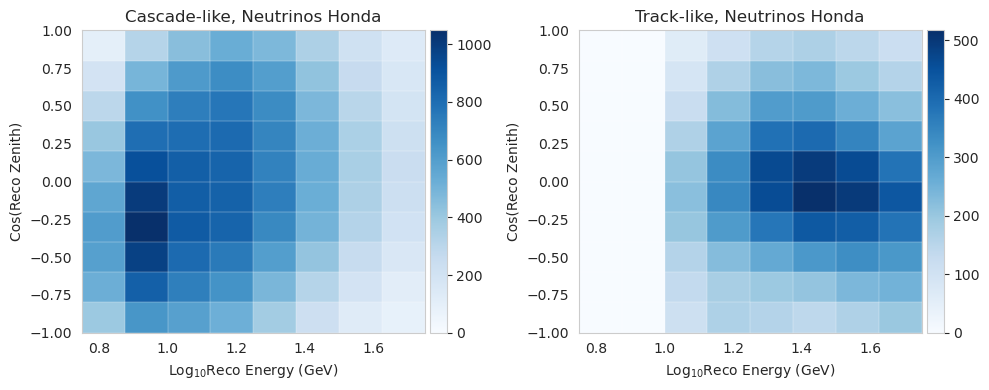

In [94]:
# Make a plot of the neutrinos just to verify the shape is correct (Honda)
bins_en = np.log10([5.623413,  7.498942, 10. , 
                    13.335215, 17.782795, 23.713737, 
                    31.622776, 42.16965 , 56.23413])

bins_cz = np.array([-1., -0.8, -0.6 , -0.4, -0.2, 
                    0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bins_pid = np.array([0, 1, 2])

# Choose the nuisance parameters for the detector systematics
#neutrino_weights = neutrino_muons()
neutrino_weights = apply_neutrinos(**best_fit)

# A flux model must be assumed for the neutrinos
# Here, use a simple flux of phi=800*E^-3.7 
# Note that this is only for the purposes of an
# example: fits performed using this sample should
# use a numerical flux calculation such as the one
# presented in PhysRevD.92.023004
# I also apply neutrino oscillation probabilities
neutrino_weights *= apply_flux_honda(**best_fit)

# Apply the spectral index systematic
neutrino_weights *= apply_spectral_index()

# Apply nue/numu ratio 
neutrino_weights *= apply_nue_numu_ratio(neutrino_weights=neutrino_weights)

# Scale to the livetime of the data
neutrino_weights *= 1006*24*3600. 
# Scale neutrino weights based on the normalization constants for NC and nu_tau nuisance parameters
neutrino_weights *= neutrino_norm(**best_fit)
# Scale the neutrino weights based on the total number of neutrinos according to table I
neutrino_weights *= neutrino_total_norm(neutrino_weights=neutrino_weights, n_neutrinos=62203-5022-93)

# Make the histogram, binning in energy, zenith, and pid
nu_hist_honda, edges = np.histogramdd([np.log10(neutrinos['reco_energy']),
                                 neutrinos['reco_coszen'],
                                 neutrinos['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights)
nu_hist_honda = np.swapaxes(nu_hist_honda, 0, 1)

# Calculate the weighted error of each bin on the histogram
# TODO this might be an incorrect way of calculating the statistical error 
# caused by the limited MC statistics
# Source: https://stackoverflow.com/questions/48227037/error-on-weighted-histogram-in-python
nu_err = np.sqrt(
    np.histogramdd([np.log10(neutrinos['reco_energy']),
                    neutrinos['reco_coszen'],
                    neutrinos['pid']],
    bins = [bins_en, bins_cz, bins_pid],
    weights = neutrino_weights**2)[0]
)
# Swap axis 0 and 1 to match the data formagridflat and for easier plotting
nu_err = np.swapaxes(nu_err, 0, 1)

# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist_honda[:,:,0],
                       cmap='Blues',
                       vmin=0, vmax=nu_hist_honda.max())
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist_honda[:,:,1],
                       cmap='Blues',
                       vmin=0, vmax=nu_hist_honda[:,:,1].max())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

# Add grid lines at bin edges
for bin_edge in bins_en:
    ax1.vlines(bin_edge, bins_cz[0], bins_cz[-1], colors='white', linewidth=.2)
    ax2.vlines(bin_edge, bins_cz[0], bins_cz[-1], colors='white', linewidth=.2)
for bin_edge in bins_cz:
    ax1.hlines(bin_edge, bins_en[0], bins_en[-1], colors='white', linewidth=0.2)
    ax2.hlines(bin_edge, bins_en[0], bins_en[-1], colors='white', linewidth=0.2)

ax1.set_title('Cascade-like, Neutrinos Honda')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Neutrinos Honda')

fig.tight_layout()

#### MC Honda without normalization

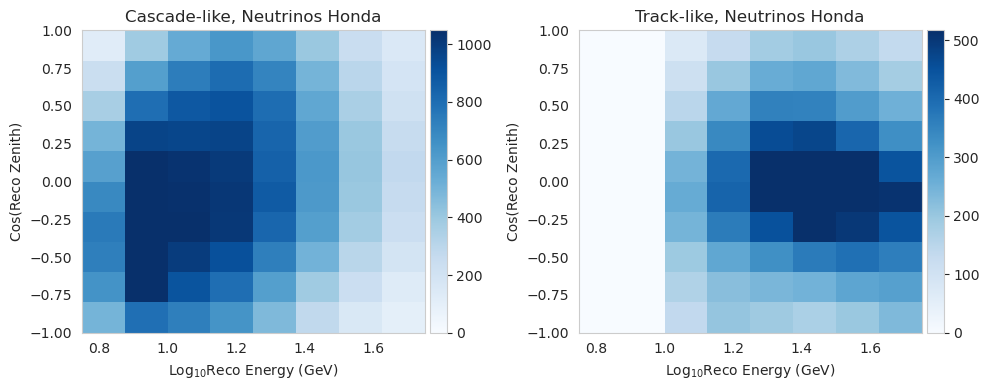

In [95]:
# Make a plot of the neutrinos just to verify the shape is correct (Honda)
bins_en = np.log10([5.623413,  7.498942, 10. , 
                    13.335215, 17.782795, 23.713737, 
                    31.622776, 42.16965 , 56.23413])

bins_cz = np.array([-1., -0.8, -0.6 , -0.4, -0.2, 
                    0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bins_pid = np.array([0, 1, 2])

# Choose the nuisance parameters for the detector systematics
#neutrino_weights = neutrino_muons()
neutrino_weights_no_normalization = apply_neutrinos(**best_fit)

# A flux model must be assumed for the neutrinos
# Here, use a simple flux of phi=800*E^-3.7 
# Note that this is only for the purposes of an
# example: fits performed using this sample should
# use a numerical flux calculation such as the one
# presented in PhysRevD.92.023004
# I also apply neutrino oscillation probabilities
neutrino_weights_no_normalization *= apply_flux_honda(**best_fit)

# Scale to the livetime of the data
neutrino_weights_no_normalization *= 1006*24*3600. 
# Scale neutrino weights based on the normalization constants for NC and nu_tau nuisance parameters
#neutrino_weights *= neutrino_norm(**best_fit)
# Scale the neutrino weights based on the total number of neutrinos according to table I
#neutrino_weights *= neutrino_total_norm(neutrino_weights=neutrino_weights, n_neutrinos=62203-5022-93)

# Make the histogram, binning in energy, zenith, and pid
nu_hist_honda_no_normalization, edges = np.histogramdd([np.log10(neutrinos['reco_energy']),
                                 neutrinos['reco_coszen'],
                                 neutrinos['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights_no_normalization)
nu_hist_honda_no_normalization  = np.swapaxes(nu_hist_honda_no_normalization , 0, 1)

# Calculate the weighted error of each bin on the histogram
# TODO this might be an incorrect way of calculating the statistical error 
# caused by the limited MC statistics
# Source: https://stackoverflow.com/questions/48227037/error-on-weighted-histogram-in-python
nu_err = np.sqrt(
    np.histogramdd([np.log10(neutrinos['reco_energy']),
                    neutrinos['reco_coszen'],
                    neutrinos['pid']],
    bins = [bins_en, bins_cz, bins_pid],
    weights = neutrino_weights_no_normalization**2)[0]
)
# Swap axis 0 and 1 to match the data formagridflat and for easier plotting
nu_err = np.swapaxes(nu_err, 0, 1)

# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist_honda_no_normalization[:,:,0],
                       cmap='Blues',
                       vmin=0, vmax=nu_hist_honda.max())
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist_honda_no_normalization[:,:,1],
                       cmap='Blues',
                       vmin=0, vmax=nu_hist_honda[:,:,1].max())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, Neutrinos Honda')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Neutrinos Honda')

fig.tight_layout()

#### Plot oscillated vs unoscillated MC Honda

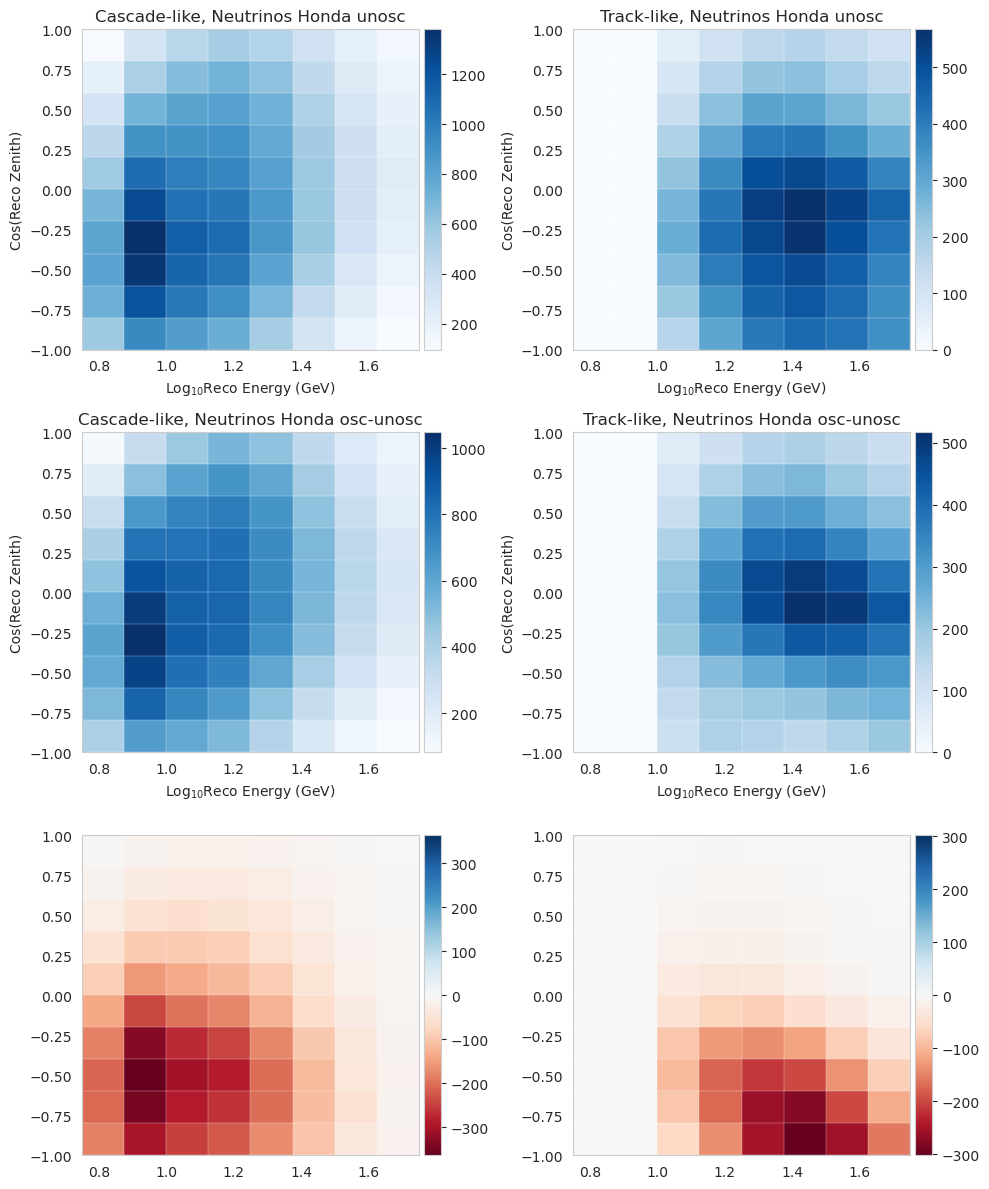

In [96]:
# Calculate unoscillated neutrino weights
unosc_neutrino_weights = neutrino_weights/ oscillation_probabilities(neutrinos=neutrinos, delta_m32=2.53e-3, theta_23=49.8)
unosc_neutrino_weights[np.abs(neutrinos['pdg']) == 16] = 0

unosc_honda_hist, _ = np.histogramdd([np.log10(neutrinos['reco_energy']),
                                 neutrinos['reco_coszen'],
                                 neutrinos['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = unosc_neutrino_weights)

unosc_honda_hist = np.swapaxes(unosc_honda_hist, 0, 1)

# Make a figure
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6) )= plt.subplots(3,2, figsize=(10, 12))
cmesh = ax1.pcolormesh(bins_en,
                       bins_cz,
                       unosc_honda_hist[:,:,0],
                       cmap='Blues')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en,
                          bins_cz,
                          unosc_honda_hist[:,:,1],
                          cmap='Blues')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax3.pcolormesh(bins_en,
                          bins_cz,
                          nu_hist_honda[:,:,0],
                          cmap='Blues')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax4.pcolormesh(bins_en,
                            bins_cz,
                            nu_hist_honda[:,:,1],
                            cmap='Blues')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax5.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist_honda[:,:,0]-unosc_honda_hist[:,:,0],
                       cmap='RdBu',
                       vmin = np.min(nu_hist_honda[:,:,0]-unosc_honda_hist[:,:,0]), 
                       vmax = -np.min(nu_hist_honda[:,:,0]-unosc_honda_hist[:,:,0]))
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax6.pcolormesh(bins_en, 
                        bins_cz,
                        nu_hist_honda[:,:,1]-unosc_honda_hist[:,:,1],
                        cmap='RdBu',
                        vmin = np.min(nu_hist_honda[:,:,1]-unosc_honda_hist[:,:,1]), 
                        vmax = -np.min(nu_hist_honda[:,:,1]-unosc_honda_hist[:,:,1]))
divider = make_axes_locatable(ax6)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

# Add grid lines at bin edges
for bin_edge in bins_en:
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.vlines(bin_edge, bins_cz[0], bins_cz[-1], colors='white', linewidth=.2)
for bin_edge in bins_cz:
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.hlines(bin_edge, bins_en[0], bins_en[-1], colors='white', linewidth=0.2)

ax1.set_title('Cascade-like, Neutrinos Honda unosc')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Neutrinos Honda unosc')
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax3.set_title('Cascade-like, Neutrinos Honda osc-unosc')
ax3.set_ylabel("Cos(Reco Zenith)")
ax3.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax4.set_ylabel("Cos(Reco Zenith)")
ax4.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax4.set_title('Track-like, Neutrinos Honda osc-unosc')

fig.tight_layout()

Maybe I should inlcude the full oscillation probabilities

#### nutau MC

If running the notebook from beginning, run this cell again after all other cells have been run

/tmp/ipykernel_4936/1713304972.py:17: RuntimeWarning: invalid value encountered in divide
  (tau_cc_hist[:, :, 1] + tau_nc_hist[:, :, 1])/np.sqrt((non_tau_hist[:, :, 1]  + muon_hist[:, :, 1])),


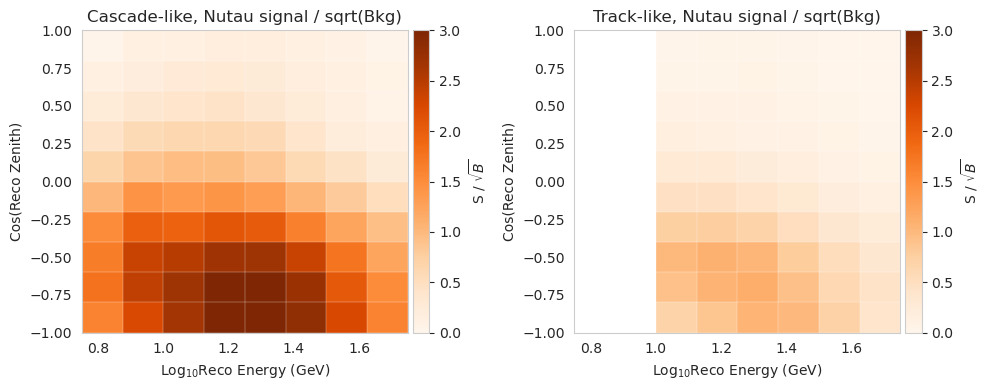

In [97]:
# Plot expected nutau signal (CC+NC) divided by the square root of the expected background (nue, numu, atmospheric muons) 
# as a function of reco energy and reco coszen

# Make a figure
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
cmesh = ax[0].pcolormesh(bins_en,
                        bins_cz,
                        (tau_cc_hist[:, :, 0] + tau_nc_hist[:, :, 0])/np.sqrt((non_tau_hist[:, :, 0]  + muon_hist[:, :, 0])),
                        cmap='Oranges',
                        vmin=0, vmax=3)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax, label = r"S / $\sqrt{B}$")

cmesh = ax[1].pcolormesh(bins_en,
                        bins_cz,
                        (tau_cc_hist[:, :, 1] + tau_nc_hist[:, :, 1])/np.sqrt((non_tau_hist[:, :, 1]  + muon_hist[:, :, 1])),
                        cmap='Oranges',
                        vmin=0, vmax=3)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax, label = r"S / $\sqrt{B}$")

# Add grid lines at bin edges
for bin_edge in bins_en:
    ax[0].vlines(bin_edge, bins_cz[0], bins_cz[-1], colors='white', linewidth=.2)
    ax[1].vlines(bin_edge, bins_cz[0], bins_cz[-1], colors='white', linewidth=.2)
for bin_edge in bins_cz:
    ax[0].hlines(bin_edge, bins_en[0], bins_en[-1], colors='white', linewidth=0.2)
    ax[1].hlines(bin_edge, bins_en[0], bins_en[-1], colors='white', linewidth=0.2)


ax[0].set_title('Cascade-like, Nutau signal / sqrt(Bkg)')
ax[0].set_ylabel("Cos(Reco Zenith)")
ax[0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax[1].grid(color='white', linestyle=':', linewidth=5)
ax[1].set_title('Track-like, Nutau signal / sqrt(Bkg)')
ax[1].set_ylabel("Cos(Reco Zenith)")
ax[1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")

fig.tight_layout()

Using numu flux for nutau, multiplying nutau events with P(nu_mu->nu_tau) and normalizing later seems to work almost perfectly

#### Plot reco vs true values

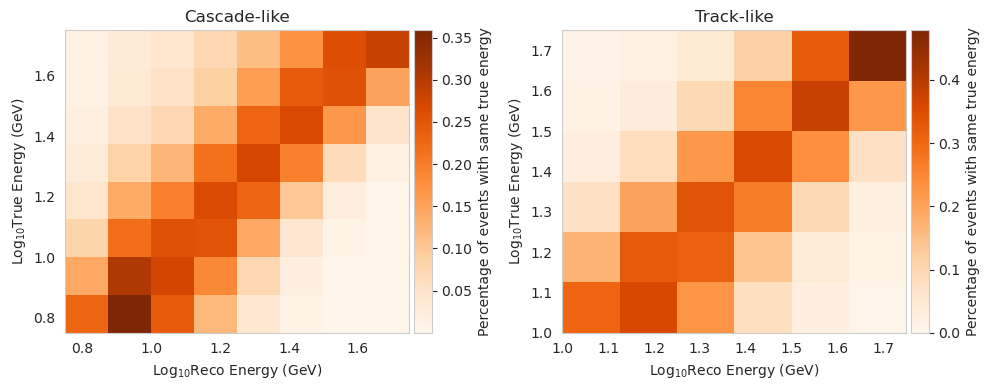

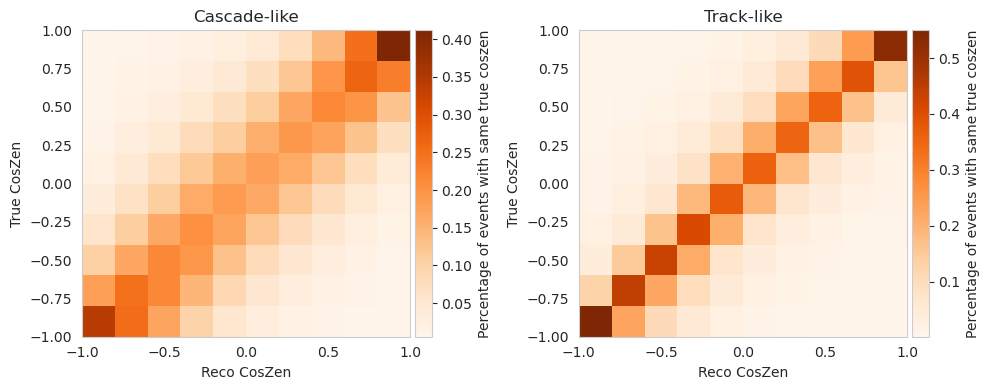

In [98]:
# Plot reco energy vs true energy for neutrinos with number of events as color

cascades_honda = neutrinos[neutrinos['pid'] == 0]
tracks_honda = neutrinos[neutrinos['pid'] == 1]
# Make histograms
reco_energy_vs_true_energy_cascades_hist, _ = np.histogramdd([np.log10(cascades_honda['true_energy']), 
                                                    np.log10(cascades_honda['reco_energy'])],
                                                   bins=[bins_en, bins_en],
                                                   weights=neutrino_weights[neutrinos['pid'] == 0])

reco_energy_vs_true_energy_tracks_hist, _ = np.histogramdd([np.log10(tracks_honda['true_energy']),
                                                    np.log10(tracks_honda['reco_energy'])],
                                                   bins=[bins_en, bins_en],
                                                   weights=neutrino_weights[neutrinos['pid'] == 1])

reco_cz_vs_true_cz_cascades_hist, _ = np.histogramdd([cascades_honda['true_coszen'],
                                                    cascades_honda['reco_coszen']],
                                                   bins=[bins_cz, bins_cz],
                                                   weights=neutrino_weights[neutrinos['pid'] == 0])

reco_cz_vs_true_cz_tracks_hist, _ = np.histogramdd([tracks_honda['true_coszen'],
                                                    tracks_honda['reco_coszen']],
                                                   bins=[bins_cz, bins_cz],
                                                   weights=neutrino_weights[neutrinos['pid'] == 1])


# Make a figure
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Cascade-like
cmesh = ax[0].pcolormesh(bins_en,
                        bins_en,
                        reco_energy_vs_true_energy_cascades_hist / np.sum(reco_energy_vs_true_energy_cascades_hist, axis=1)[:, np.newaxis],
                        cmap='Oranges')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax, label='Percentage of events with same true energy')

# Track-like
cmesh = ax[1].pcolormesh(bins_en,
                        bins_en,
                        reco_energy_vs_true_energy_tracks_hist / np.sum(reco_energy_vs_true_energy_tracks_hist, axis=1)[:, np.newaxis],
                        cmap='Oranges')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax, label='Percentage of events with same true energy')

ax[0].set_title('Cascade-like')
ax[0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax[0].set_ylabel(r"Log$_{10}$True Energy (GeV)")
ax[0].set_xlim(bins_en[0], bins_en[-1])
ax[0].set_ylim(bins_en[0], bins_en[-1])
ax[1].set_title('Track-like')
ax[1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax[1].set_ylabel(r"Log$_{10}$True Energy (GeV)")
ax[1].set_xlim(bins_en[2], bins_en[-1])
ax[1].set_ylim(bins_en[2], bins_en[-1])


fig.tight_layout()

# Make a figure
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Cascade-like
cmesh = ax[0].pcolormesh(bins_cz,
                        bins_cz,
                        reco_cz_vs_true_cz_cascades_hist / np.sum(reco_cz_vs_true_cz_cascades_hist, axis=1)[:, np.newaxis],
                        cmap='Oranges')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax, label='Percentage of events with same true coszen')

# Track-like
cmesh = ax[1].pcolormesh(bins_cz,
                        bins_cz,
                        reco_cz_vs_true_cz_tracks_hist / np.sum(reco_cz_vs_true_cz_tracks_hist, axis=1)[:, np.newaxis],
                        cmap='Oranges')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax, label='Percentage of events with same true coszen')

ax[0].set_title('Cascade-like')
ax[0].set_ylabel("True CosZen")
ax[0].set_xlabel("Reco CosZen")
ax[0].set_xlim(bins_cz[0], bins_cz[-1])
ax[0].set_ylim(bins_cz[0], bins_cz[-1])
ax[1].set_title('Track-like')
ax[1].set_ylabel("True CosZen")
ax[1].set_xlabel("Reco CosZen")
ax[1].set_xlim(bins_cz[0], bins_cz[-1])
ax[1].set_ylim(bins_cz[0], bins_cz[-1])

fig.tight_layout()


## Plot comparison of MC with MCEq and MC with Honda flux

In the end, we want to use the Honda flux, because it is the one that was used by the IceCube collaboraiton

In [99]:
# Plot Honda and MCEq MC next to each other and their difference
if use_MCEq:
    # Make a figure
    fig, axs = plt.subplots(3,2, figsize=(10, 12))
    cmesh = axs[0,0].pcolormesh(bins_en, 
                        bins_cz,
                        nu_hist[:,:,0],
                        cmap='Blues',
                        vmin=0, vmax=nu_hist_honda.max())
    divider = make_axes_locatable(axs[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(cmesh, cax)

    cmesh = axs[0,1].pcolormesh(bins_en, 
                        bins_cz,
                        nu_hist[:,:,1],
                        cmap='Blues',
                        vmin=0, vmax=nu_hist_honda[:,:,1].max())
    divider = make_axes_locatable(axs[0,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(cmesh, cax)

    cmesh = axs[1,0].pcolormesh(bins_en,
                            bins_cz,
                            nu_hist_honda[:,:,0],
                            cmap='Blues',
                        vmin=0, vmax=nu_hist_honda.max())
    divider = make_axes_locatable(axs[1,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(cmesh, cax)

    cmesh = axs[1,1].pcolormesh(bins_en,
                            bins_cz,
                            nu_hist_honda[:,:,1],
                            cmap='Blues',
                        vmin=0, vmax=nu_hist_honda[:,:,1].max())
    divider = make_axes_locatable(axs[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(cmesh, cax)

    cmesh = axs[2,0].pcolormesh(bins_en,
                            bins_cz,
                            nu_hist[:,:,0] - nu_hist_honda[:,:,0],
                            cmap='RdBu',
                            vmin=-130, vmax=130)
    divider = make_axes_locatable(axs[2,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(cmesh, cax)

    cmesh = axs[2,1].pcolormesh(bins_en,
                            bins_cz,
                            nu_hist[:,:,1] - nu_hist_honda[:,:,1],
                            cmap='RdBu',
                            vmin=-90, vmax=90)
    divider = make_axes_locatable(axs[2,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(cmesh, cax)

    axs[0,0].set_title('Cascade-like, Neutrinos MCEq')
    axs[0,0].set_ylabel("Cos(Reco Zenith)")
    axs[0,0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
    axs[0,1].set_ylabel("Cos(Reco Zenith)")
    axs[0,1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
    axs[0,1].set_title('Track-like, Neutrinos MCEq')
    axs[1,0].set_title('Cascade-like, Neutrinos Honda')
    axs[1,0].set_ylabel("Cos(Reco Zenith)")
    axs[1,0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
    axs[1,1].set_title('Track-like, Neutrinos Honda')
    axs[1,1].set_ylabel("Cos(Reco Zenith)")
    axs[1,1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
    axs[2,0].set_title('Cascade-like, Neutrinos MCEq - Neutrinos Honda')
    axs[2,0].set_ylabel("Cos(Reco Zenith)")
    axs[2,0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
    axs[2,1].set_title('Track-like, Neutrinos MCEq - Neutrinos Honda')
    axs[2,1].set_ylabel("Cos(Reco Zenith)")
    axs[2,1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")

    fig.tight_layout()

10% difference is significant... 
TODO: Find out why this happens even though fluxes (on log scale) appear similar

## Plot muon MC

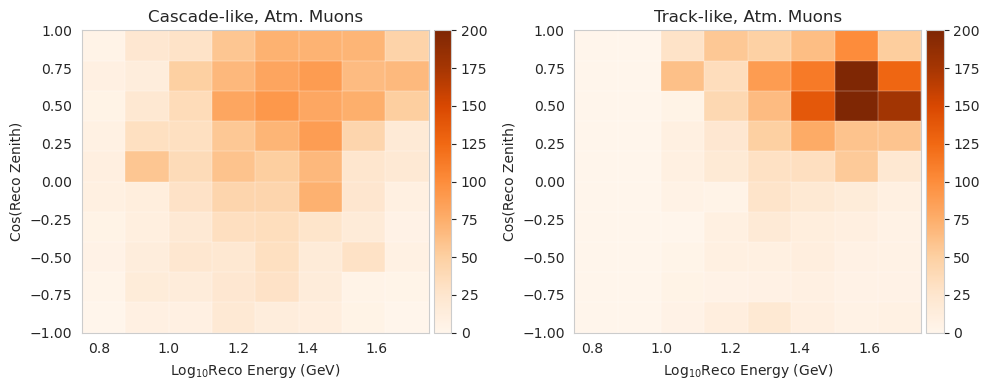

In [100]:
# Choose the nuisance parameters for the detector systematics
muon_weights = apply_muons(**best_fit)

# Weights are in Hz. Convert to about the 
# livetime given in Section IV
# Corresponding to the number of seconds that the experiment was live. 
# Roughly 3 years.
muon_weights *= 1006*24*3600. 
muon_weigths_no_normalization = muon_weights
# Scale the number of events so that they match the numbers in table I
muon_weights *= muon_norm(muon_weights, 5022)

# Make the histogram, binning in energy, zenith, and pid
muon_hist, edges = np.histogramdd([np.log10(muons['reco_energy']),
                                   muons['reco_coszen'],
                                   muons['pid']],
                                  bins = [bins_en, bins_cz, bins_pid],
                                  weights = muon_weights)
muon_hist = np.swapaxes(muon_hist, 0, 1)

muon_hist_no_normalization, edges = np.histogramdd([np.log10(muons['reco_energy']),
                                      muons['reco_coszen'],
                                        muons['pid']],
                                        bins = [bins_en, bins_cz, bins_pid],
                                        weights = muon_weigths_no_normalization)
muon_hist_no_normalization = np.swapaxes(muon_hist_no_normalization, 0, 1)

# Calculate the weighted error of each bin on the histogram
# TODO this might be an incorrect way of calculating the statistical error 
# caused by the limited MC statistics. See same code above for neutrinos
muon_err = np.sqrt(
    np.histogramdd([np.log10(muons['reco_energy']),
                    muons['reco_coszen'],
                    muons['pid']],
        bins = [bins_en, bins_cz, bins_pid],
        weights = muon_weights**2)[0]
)
muon_err = np.swapaxes(muon_err, 0, 1)

# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       muon_hist[:,:,0],
                       cmap='Oranges', 
                       vmax=200)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en, 
                       bins_cz,
                       muon_hist[:,:,1],
                       cmap='Oranges',
                       vmax=200)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

# Add grid lines at bin edges
for bin_edge in bins_en:
    ax1.vlines(bin_edge, bins_cz[0], bins_cz[-1], colors='white', linewidth=.2)
    ax2.vlines(bin_edge, bins_cz[0], bins_cz[-1], colors='white', linewidth=.2)
for bin_edge in bins_cz:
    ax1.hlines(bin_edge, bins_en[0], bins_en[-1], colors='white', linewidth=0.2)
    ax2.hlines(bin_edge, bins_en[0], bins_en[-1], colors='white', linewidth=0.2)

ax1.set_title('Cascade-like, Atm. Muons')

ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Atm. Muons')

fig.tight_layout()

This plot should look like Figure 12 in the paper, but does not. 
Something with the weights is wrong, or I have misunderstood the output or the plot in the paper.

## Plot detected data

In [101]:
# Read in data and sort it
data = np.genfromtxt("./data.csv", delimiter=',', names=True)

cascades = data[data["pid"] == 0]
tracks = data[data["pid"] == 1]

# Reshape the count column in the cascade array into a 2D array. 
# The rows should correspond to a sorted reco_coszen and the columns should be the sorted reco_energy
cascades_count = cascades["count"].reshape((len(bins_en)-1, len(bins_cz)-1)).T[::-1, ...]
track_count = tracks["count"].reshape((len(bins_en)-1-2, len(bins_cz)-1)).T[::-1, ...]

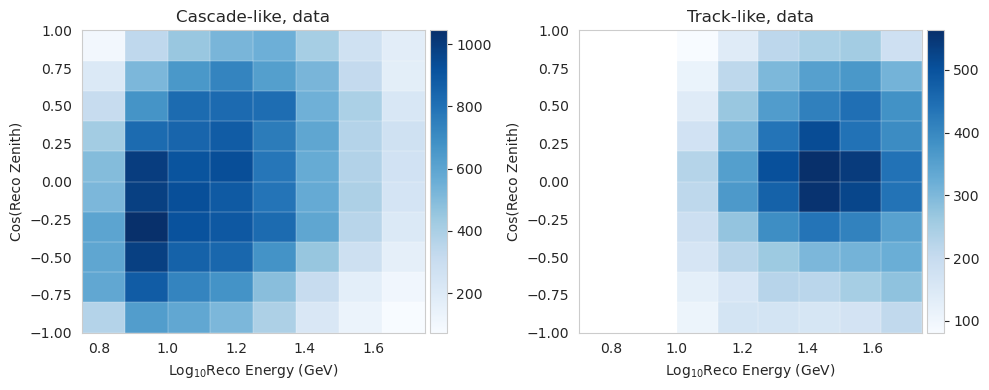

In [102]:
# Make a figure of neutrino data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       cascades_count,
                       cmap='Blues')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en[2:], 
                       bins_cz,
                       track_count,
                       cmap='Blues')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, data')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, data')

ax2.grid(False)

# Add grid lines at bin edges
for bin_edge in bins_en:
    ax1.vlines(bin_edge, bins_cz[0], bins_cz[-1], colors='white', linewidth=.2)
    ax2.vlines(bin_edge, bins_cz[0], bins_cz[-1], colors='white', linewidth=.2)
for bin_edge in bins_cz:
    ax1.hlines(bin_edge, bins_en[0], bins_en[-1], colors='white', linewidth=0.2)
    ax2.hlines(bin_edge, bins_en[0], bins_en[-1], colors='white', linewidth=0.2)

fig.tight_layout()


## Plot comparison of data with MC prediction

/tmp/ipykernel_4936/2787211110.py:37: RuntimeWarning: invalid value encountered in divide
  (nu_hist_honda[:,:,1] + muon_hist[:,:,1]-track_padded)/track_padded,


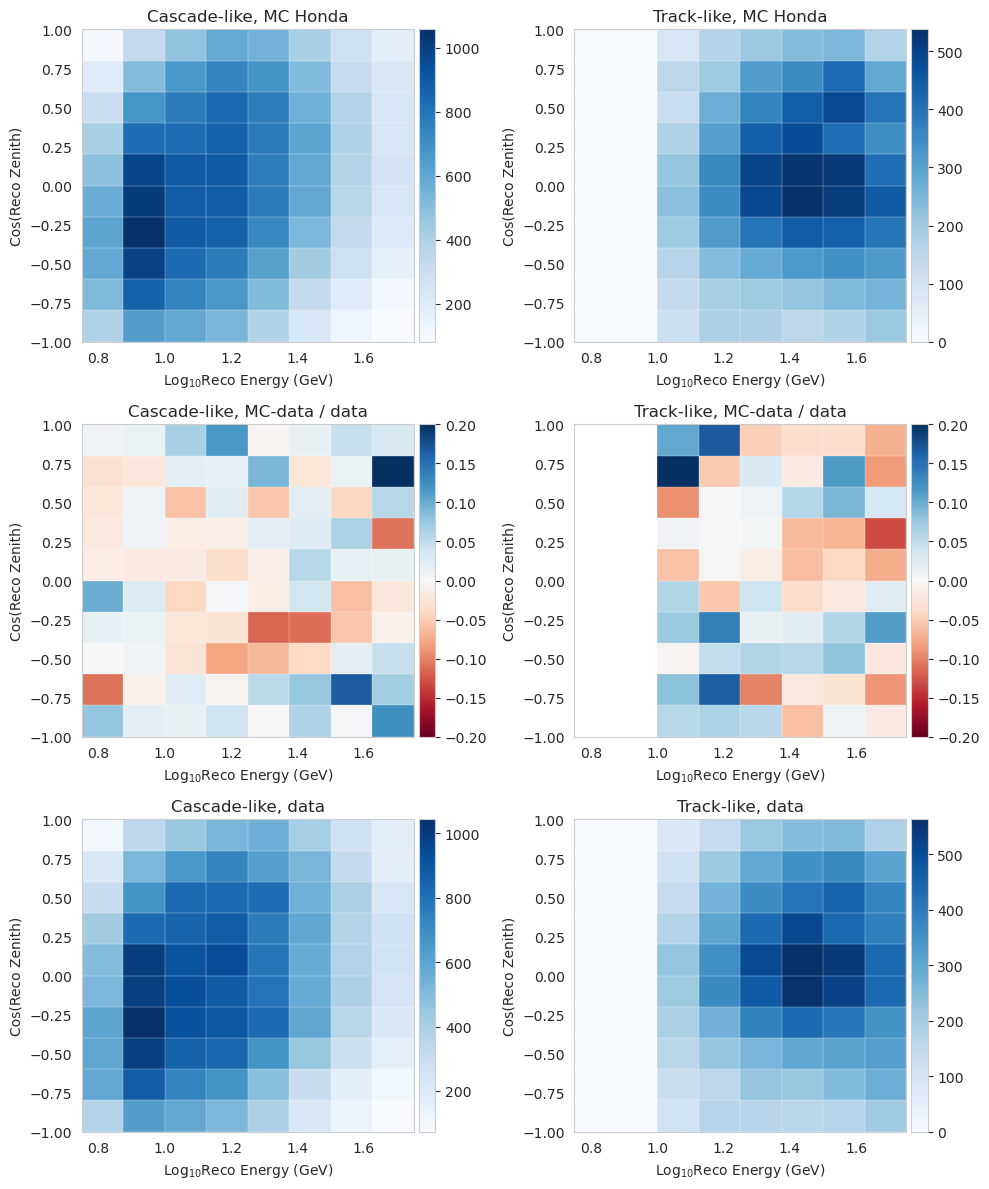

In [103]:
# Data and MC comparison with MCEq and Honda fluxes
# Make a a 3x2 grid of subplots with 2D histograms. 
# The top two rows should be the combined MC data (i.e. neutrinos and muons)
# The bottom row should be the data
fig, ((ax_1,ax0), (ax1, ax2), (ax3, ax4)) = plt.subplots(3,2, figsize=(10, 12))
cmesh = ax_1.pcolormesh(bins_en,
                        bins_cz,
                        nu_hist_honda[:,:,0] + muon_hist[:,:,0],
                        cmap='Blues')
ax_1.set_title('Cascade-like, MC Honda')
divider = make_axes_locatable(ax_1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

cmesh = ax0.pcolormesh(bins_en,
                        bins_cz,
                        nu_hist_honda[:,:,1] + muon_hist[:,:,1],
                        cmap='Blues')
ax0.set_title('Track-like, MC Honda')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       (nu_hist_honda[:,:,0] + muon_hist[:,:,0]-cascades_count)/cascades_count,
                       cmap='RdBu',
                        vmin = -.2, vmax = .2)
ax1.set_title('Cascade-like, MC-data / data')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

track_padded = np.pad(track_count, ((0,0),(2,0)), 'constant', constant_values=0)
cmesh = ax2.pcolormesh(bins_en,
                        bins_cz,
                        (nu_hist_honda[:,:,1] + muon_hist[:,:,1]-track_padded)/track_padded,
                        cmap='RdBu',
                        vmin = -.2, vmax = .2)
ax2.set_title('Track-like, MC-data / data')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

cmesh = ax3.pcolormesh(bins_en,
                        bins_cz,
                        cascades_count,
                        cmap='Blues')
ax3.set_title('Cascade-like, data')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)


cmesh = ax4.pcolormesh(bins_en,
                        bins_cz,
                        track_padded,
                        cmap='Blues')
ax4.set_title('Track-like, data')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

for ax in (ax_1, ax0, ax1, ax2, ax3, ax4):
    ax.set_ylabel("Cos(Reco Zenith)")
    ax.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
    ax.grid(False)

# Add grid lines at bin edges
for bin_edge in bins_en:
    for ax in [ax_1, ax0, ax1, ax2, ax3, ax4]:
        ax.vlines(bin_edge, bins_cz[0], bins_cz[-1], colors='white', linewidth=.2)
for bin_edge in bins_cz:
    for ax in [ax_1, ax0, ax1, ax2, ax3, ax4]:
        ax.hlines(bin_edge, bins_en[0], bins_en[-1], colors='white', linewidth=0.2)

fig.tight_layout()

TODO: find out why the oscillation bands appear here? 
Only detector systematics are being considered, other nuissance parameters (neutrino flux and cross-section, atmospheric muons not accounted for)

### Compare data with Honda MC on 1D projections

### Tracks and Cascades stacked

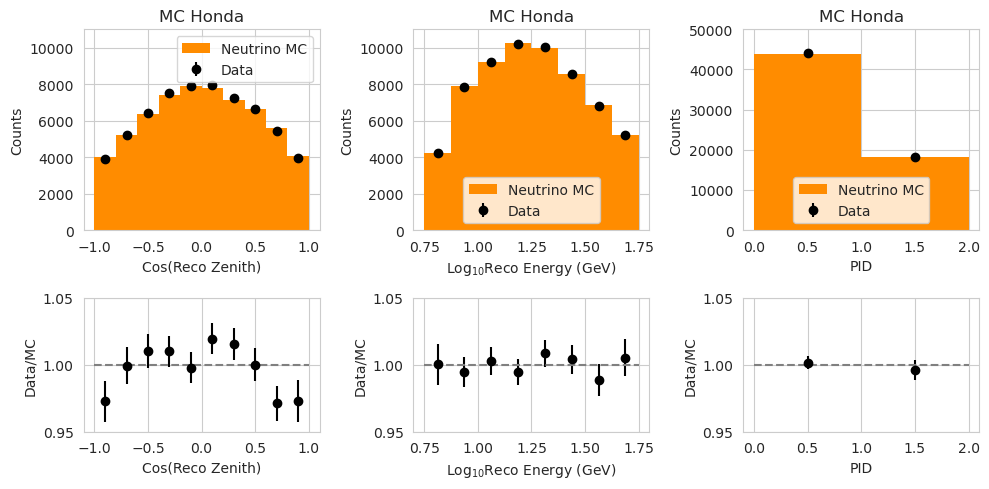

In [138]:
# Make a 3D histogram of the data where the track histogram has been padded with 0s to have the same shape as the cascades
track_padded = np.zeros_like(cascades_count)
track_padded[:, 2:] = track_count
data_hist = np.stack([cascades_count, track_padded], axis=-1)
nu_mc_one_normalization = nu_hist_honda_no_normalization + muon_hist_no_normalization
nu_mc_one_normalization[:, :, 0] *= (data_hist.sum(axis=(0, 1))/nu_mc_one_normalization.sum(axis=(0, 1)))[0]
nu_mc_one_normalization[:, :, 1] *= (data_hist.sum(axis=(0, 1))/nu_mc_one_normalization.sum(axis=(0, 1)))[1]
# Make a projection on each 3D axis of histogram for both the data and MC
# Plot each projection on the same figure but in separate subplots
# Subtract the muon MC from the data histogram
# The MC data is a filled histogram, while the data is a scatter plot
fig, axs = plt.subplots(2,3, figsize=(10, 5), height_ratios=[3, 2])
for j in range(2):
    axes= axs[j]
    for i, (ax, bins, xlabel) in enumerate(zip(axes, [bins_cz, bins_en, bins_pid], ("Cos(Reco Zenith)", r"Log$_{10}$Reco Energy (GeV)", "PID"))):
        axes_to_sum = tuple(set(range(3)) - set([i]))
        if j == 0:
            nu_mc_proj = nu_hist_honda.sum(axis=axes_to_sum) + muon_hist.sum(axis=axes_to_sum)
            # set title
            ax.set_title("MC Honda")
            data_proj = data_hist.sum(axis=axes_to_sum)
            ax.stairs(nu_mc_proj, bins, fill=True, alpha=1, label="Neutrino MC", color="darkorange")
            ax.errorbar((bins[1:] + bins[:-1])/2, data_proj, yerr=np.sqrt(data_proj), fmt='o', label="Data", c="k")
            ax.set_xlabel(xlabel)
            ax.set_ylabel("Counts")
            ax.set_ylim(0,11000) if i != 2 else ax.set_ylim(0, 50000)
            ax.legend()

        else: 
            # Ratio of data to MC
            ratio = data_hist.sum(axis=axes_to_sum)/(nu_hist_honda.sum(axis=axes_to_sum) + muon_hist.sum(axis=axes_to_sum))
            ax.errorbar((bins[1:] + bins[:-1])/2, ratio, yerr=np.sqrt(data_hist.sum(axis=axes_to_sum))/(nu_hist_honda.sum(axis=axes_to_sum) + muon_hist.sum(axis=axes_to_sum)), fmt='o', c='k')
            ax.set_ylabel("Data/MC")
            ax.set_xlabel(xlabel)
            ax.set_ylim(0.95, 1.05)
            ax.hlines(1, bins[0], bins[-1], colors='grey', linestyles='--')
        # else:
        #    nu_mc_proj = nu_hist.sum(axis=axes_to_sum) + muon_hist.sum(axis=axes_to_sum)
        #    # set title
        #    ax.set_title("MC MCEq")

        
        


fig.tight_layout()

/tmp/ipykernel_4936/3673877988.py:89: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axs[1, 0].plot(np.linspace(0, 2, 10), np.ones(10), 'k--', color="grey")
/tmp/ipykernel_4936/3673877988.py:90: RuntimeWarning: invalid value encountered in divide
  axs[1, 1].errorbar((bins_en[1:] + bins_en[:-1])/2, data_hist.sum(axis=0)[:, 1]/(nu_hist_honda.sum(axis=0)[:,1] + muon_hist.sum(axis=0)[:,1]), yerr=np.sqrt(data_hist.sum(axis=0)[:, 1])/(nu_hist_honda.sum(axis=0)[:,1] + muon_hist.sum(axis=0)[:,1]), alpha=1, label="Track-like",  fmt='o', color="k")
/tmp/ipykernel_4936/3673877988.py:91: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axs[1, 1].plot(np.linspace(0, 2, 10), np.ones(10), 'k--', color="grey")


Text(0, 0.5, 'Counts')

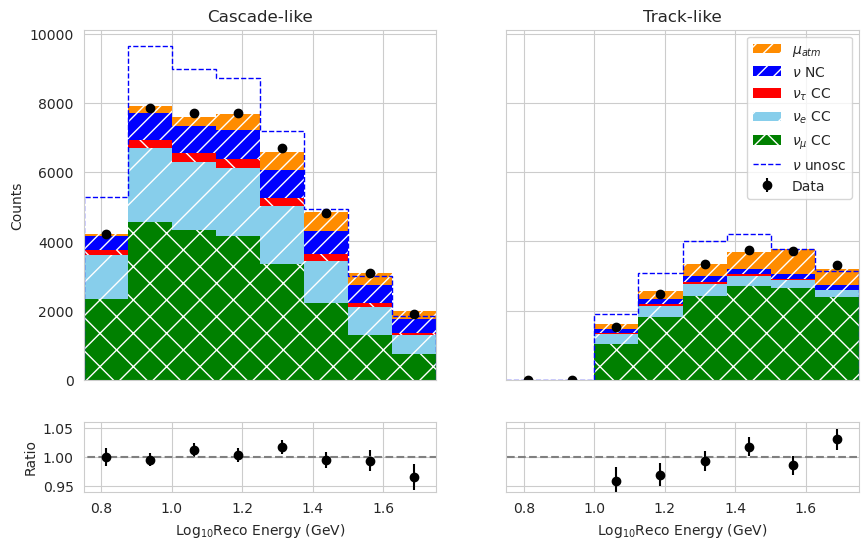

In [105]:
# Extract NC neutrinos
# - type: interaction type where 0 = any neutral current (NC), 1 = charged current quasi elastic (CC_QE), 2 = charged current resonant (CC_RES), 3 = charged current deep inelastic (CC_DIS), 4 = coherent scattering
NC_int_type = (neutrinos["type"] == 0).astype(int) # NC is 0
CC_int_type = (neutrinos["type"] > 0).astype(int) # CC is 1, 2, 3, (4 not, but only .7% of the data)
CC_int_type[(CC_int_type == 1) & (np.abs(neutrinos["pdg"]) == 14)] = 2 # CC_mu is 2
CC_int_type[(CC_int_type == 1) & (np.abs(neutrinos["pdg"]) == 16)] = 3 # CC_tau is 3

nc_nu = neutrinos[NC_int_type == 1]
e_CC = neutrinos[CC_int_type == 1]
mu_CC = neutrinos[CC_int_type == 2]
tau_CC = neutrinos[CC_int_type == 3]


# Make histograms
nc_hist, _ = np.histogramdd([np.log10(nc_nu['reco_energy']),
                             nc_nu['reco_coszen'],
                             nc_nu['pid']],
                            bins = [bins_en, bins_cz, bins_pid],
                            weights = neutrino_weights[NC_int_type == 1])
nc_hist = np.swapaxes(nc_hist, 0, 1)

e_cc_hist, _ = np.histogramdd([np.log10(e_CC['reco_energy']),
                                 e_CC['reco_coszen'],
                                 e_CC['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[CC_int_type == 1])
e_cc_hist = np.swapaxes(e_cc_hist, 0, 1)

mu_cc_hist, _ = np.histogramdd([np.log10(mu_CC['reco_energy']),
                                 mu_CC['reco_coszen'],
                                 mu_CC['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[CC_int_type == 2])
mu_cc_hist = np.swapaxes(mu_cc_hist, 0, 1)

tau_cc_hist, _ = np.histogramdd([np.log10(tau_CC['reco_energy']),
                                 tau_CC['reco_coszen'],
                                 tau_CC['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[CC_int_type == 3])
tau_cc_hist = np.swapaxes(tau_cc_hist, 0, 1)


# Make histogram of unoscillated neutrinos
unosc_neutrino_weights = neutrino_weights / oscillation_probabilities(neutrinos=neutrinos, delta_m32=2.53e-3, theta_23=49.8)

unosc_nu_hist_honda, _ = np.histogramdd([np.log10(neutrinos['reco_energy']),
                                    neutrinos['reco_coszen'],
                                    neutrinos['pid']],
                                    bins = [bins_en, bins_cz, bins_pid],
                                    weights = unosc_neutrino_weights)

unosc_nu_hist_honda = np.swapaxes(unosc_nu_hist_honda, 0, 1)

# Make a 3D histogram of the data where the track histogram has been padded with 0s to have the same shape as the cascades
track_padded = np.zeros_like(cascades_count)
track_padded[:, 2:] = track_count
data_hist = np.stack([cascades_count, track_padded], axis=-1)

# Make a projection on each 3D axis of histogram for both the data and MC
# Plot each projection on the same figure but in separate subplots
# Subtract the muon MC from the data histogram
# The MC data is a filled histogram, while the data is a scatter plot
fig, axs = plt.subplots(2,2, figsize=(10, 6), sharex=True, sharey='row',  gridspec_kw={'height_ratios': [5, 1]})
axs[0, 0].errorbar((bins_en[1:] + bins_en[:-1])/2, data_hist.sum(axis=0)[:, 0], yerr=np.sqrt(data_hist.sum(axis=0)[:, 0]), fmt='o', label="Data", c="k")

axs[0, 0].stairs(nu_hist_honda.sum(axis=0)[:,0] + muon_hist.sum(axis=0)[:, 0], bins_en, fill=True, alpha=1, label=r"$\mu_{atm}$", color="darkorange", hatch='//')
axs[0, 0].stairs(nu_hist_honda.sum(axis=0)[:,0], bins_en, fill=True, alpha=1, label=r"$\nu$ NC", color="blue", hatch='//')
axs[0, 0].stairs(nu_hist_honda.sum(axis=0)[:,0] - nc_hist.sum(axis=0)[:, 0], bins_en, fill=True, alpha=1, label=r"$\nu_\tau$ CC", color="red", hatch='\\')
axs[0, 0].stairs(nu_hist_honda.sum(axis=0)[:,0] - nc_hist.sum(axis=0)[:, 0] - tau_cc_hist.sum(axis=0)[:, 0], bins_en, fill=True, alpha=1, label=r"$\nu_e$ CC", color="skyblue", hatch='/')
axs[0, 0].stairs(nu_hist_honda.sum(axis=0)[:,0] - nc_hist.sum(axis=0)[:, 0] - tau_cc_hist.sum(axis=0)[:, 0] - e_cc_hist.sum(axis=0)[:, 0], bins_en, fill=True, alpha=1, label=r"$\nu_\mu$ CC", color="green", hatch='x')
#axs[0].stairs(nu_hist_honda.sum(axis=0)[:,0] - nc_hist.sum(axis=0)[:, 0] - e_cc_hist.sum(axis=0)[:, 0] - mu_cc_hist.sum(axis=0)[:, 0] - tau_cc_hist.sum(axis=0)[:, 0], bins_en, fill=True, alpha=1, label=r"should be zero", color="yellow", hatch='//')

axs[0, 0].stairs(unosc_honda_hist.sum(axis=0)[:,0], bins_en, fill=False, alpha=1, label=r"$\nu$ unosc", color="blue", linestyle='--')

axs[0, 1].errorbar((bins_en[1:] + bins_en[:-1])/2, data_hist.sum(axis=0)[:, 1], yerr=np.sqrt(data_hist.sum(axis=0)[:, 1]), fmt='o', label="Data", c="k")

axs[0, 1].stairs(nu_hist_honda.sum(axis=0)[:,1] + muon_hist.sum(axis=0)[:, 1], bins_en, fill=True, alpha=1, label=r"$\mu_{atm}$", color="darkorange",  hatch='//')
axs[0, 1].stairs(nu_hist_honda.sum(axis=0)[:,1], bins_en, fill=True, alpha=1, label=r"$\nu$ NC", color="blue",  hatch='//')
axs[0, 1].stairs(nu_hist_honda.sum(axis=0)[:,1] - nc_hist.sum(axis=0)[:, 1], bins_en, fill=True, alpha=1, label=r"$\nu_\tau$ CC", color="red")
axs[0, 1].stairs(nu_hist_honda.sum(axis=0)[:,1] - nc_hist.sum(axis=0)[:, 1] - tau_cc_hist.sum(axis=0)[:, 1], bins_en, fill=True, alpha=1, label=r"$\nu_e$ CC", color="skyblue",  hatch='/')
axs[0, 1].stairs(nu_hist_honda.sum(axis=0)[:,1] - nc_hist.sum(axis=0)[:, 1] - tau_cc_hist.sum(axis=0)[:, 1] - e_cc_hist.sum(axis=0)[:, 1], bins_en, fill=True, alpha=1, label=r"$\nu_\mu$ CC", color="green",  hatch='x')
#axs[1].stairs(nu_hist_honda.sum(axis=0)[:,1] - nc_hist.sum(axis=0)[:, 1] - e_cc_hist.sum(axis=0)[:, 1] - mu_cc_hist.sum(axis=0)[:, 1] - tau_cc_hist.sum(axis=0)[:, 1], bins_en, fill=True, alpha=1, label=r"should be zero", color="yellow",  hatch='//')

axs[0, 1].stairs(unosc_honda_hist.sum(axis=0)[:,1], bins_en, fill=False, alpha=1, label=r"$\nu$ unosc", color="blue", linestyle='--')

# Plot the ratio
axs[1, 0].errorbar((bins_en[1:] + bins_en[:-1])/2, data_hist.sum(axis=0)[:, 0]/(nu_hist_honda.sum(axis=0)[:,0] + muon_hist.sum(axis=0)[:,0]), yerr=np.sqrt(data_hist.sum(axis=0)[:, 0])/(nu_hist_honda.sum(axis=0)[:,0] + muon_hist.sum(axis=0)[:,0]), alpha=1, label="Cascade-like", fmt='o', color="k")
axs[1, 0].plot(np.linspace(0, 2, 10), np.ones(10), 'k--', color="grey")
axs[1, 1].errorbar((bins_en[1:] + bins_en[:-1])/2, data_hist.sum(axis=0)[:, 1]/(nu_hist_honda.sum(axis=0)[:,1] + muon_hist.sum(axis=0)[:,1]), yerr=np.sqrt(data_hist.sum(axis=0)[:, 1])/(nu_hist_honda.sum(axis=0)[:,1] + muon_hist.sum(axis=0)[:,1]), alpha=1, label="Track-like",  fmt='o', color="k")
axs[1, 1].plot(np.linspace(0, 2, 10), np.ones(10), 'k--', color="grey")

axs[1, 0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
axs[1, 1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
axs[1, 0].set_ylabel("Ratio")
axs[1, 0].set_ylim(0.94, 1.06)  # Adjust the y-axis limits as needed
axs[0, 0].set_xlim(min(bins_en), max(bins_en))
axs[0, 1].set_xlim(min(bins_en), max(bins_en))
axs[0, 1].set_title("Track-like")
axs[0, 1].legend()
axs[0, 0].set_title("Cascade-like")
axs[0, 0].set_ylabel("Counts")

Number of tau_nc events: 635.216173130815
Number of tau_cc events: 1796.1611667263853


/tmp/ipykernel_4936/1431027266.py:61: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar((bins[1:] + bins[:-1])/2, ratio, yerr=np.sqrt(tau_data_signal_hist.sum(axis=axes_to_sum))/(tau_nc_hist.sum(axis=axes_to_sum) + tau_cc_hist.sum(axis=axes_to_sum)), fmt='o', c='k')


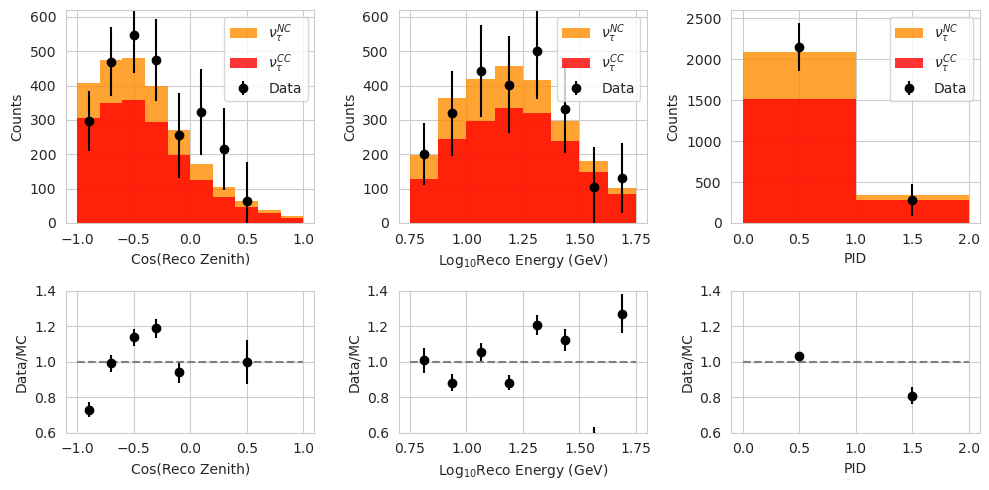

In [149]:
# Extract tau neutrinos
tau_int_type = (np.abs(neutrinos["pdg"]) == 16).astype(int) # non-tau neutrino is 0, tau neutrino is 1
tau_int_type[(tau_int_type == 1) & (neutrinos["type"] > 0)] = 2 # CC is 2, NC is 1

non_tau_nu = neutrinos[tau_int_type == 0]
tau_nc = neutrinos[(tau_int_type == 1)]

# Make histograms
non_tau_hist, _ = np.histogramdd([np.log10(non_tau_nu['reco_energy']),
                                  non_tau_nu['reco_coszen'],
                                  non_tau_nu['pid']],
                                 bins = [bins_en, bins_cz, bins_pid],
                                 weights = neutrino_weights[tau_int_type == 0])
non_tau_hist = np.swapaxes(non_tau_hist, 0, 1)

tau_nc_hist, _ = np.histogramdd([np.log10(tau_nc['reco_energy']),
                                    tau_nc['reco_coszen'],
                                    tau_nc['pid']],
                                    bins = [bins_en, bins_cz, bins_pid],
                                    weights = neutrino_weights[tau_int_type == 1])
tau_nc_hist = np.swapaxes(tau_nc_hist, 0, 1)

# tau neutrino histograms
tau_data_signal_hist = data_hist - non_tau_hist - muon_hist

# print number of tau_nc and tau_cc events
print(f"Number of tau_nc events: {tau_nc_hist.sum()}")
print(f"Number of tau_cc events: {tau_cc_hist.sum()}")

# Make a projection on each 3D axis of histogram for both the data and MC
# Plot each projection on the same figure but in separate subplots
# Subtract the muon MC and nontua MC from the data histogram
# The MC data is a filled histogram, while the data is a scatter plot
fig, axs = plt.subplots(2,3, figsize=(10, 5), height_ratios=[3, 2])
for j in range(2):
    axes= axs[j]
    for i, (ax, bins, xlabel) in enumerate(zip(axes, [bins_cz, bins_en, bins_pid], ("Cos(Reco Zenith)", r"Log$_{10}$Reco Energy (GeV)", "PID"))):
        axes_to_sum = tuple(set(range(3)) - set([i]))
        if j == 0:
            tau_nc_mc_proj = tau_nc_hist.sum(axis=axes_to_sum)
            tau_cc_mc_proj = tau_cc_hist.sum(axis=axes_to_sum)

            data_proj = tau_data_signal_hist.sum(axis=axes_to_sum)
            # NOTE This is not perfectly accurate, since the MC errors are not a simple Poisson error
            data_proj_err = np.sqrt(
                np.sqrt(data_hist.sum(axis=axes_to_sum))**2 
                + np.sqrt(muon_hist.sum(axis=axes_to_sum))**2 
                + np.sqrt(non_tau_hist.sum(axis=axes_to_sum))**2)

            ax.stairs(tau_cc_mc_proj + tau_nc_mc_proj, bins, fill=True, alpha=0.8, label=r"$\nu_\tau^{NC}$", color="darkorange")
            ax.stairs(tau_cc_mc_proj, bins, fill=True, alpha=0.8, label=r"$\nu_\tau^{CC}$", color="red")
            ax.errorbar((bins[1:] + bins[:-1])/2, data_proj, yerr=data_proj_err, fmt='o', label="Data", c="k")
            ax.set_xlabel(xlabel)
            ax.set_ylabel("Counts")
            ax.set_ylim(0, 620 if i < 2 else 2600)
            ax.legend()

        else:
            # Ratio of data to MC
            ratio = tau_data_signal_hist.sum(axis=axes_to_sum)/(tau_nc_hist.sum(axis=axes_to_sum) + tau_cc_hist.sum(axis=axes_to_sum))
            ax.errorbar((bins[1:] + bins[:-1])/2, ratio, yerr=np.sqrt(tau_data_signal_hist.sum(axis=axes_to_sum))/(tau_nc_hist.sum(axis=axes_to_sum) + tau_cc_hist.sum(axis=axes_to_sum)), fmt='o', c='k')
            ax.set_ylabel("Data/MC")
            ax.set_xlabel(xlabel)
            ax.set_ylim(0.6, 1.4)
            ax.hlines(1, bins[0], bins[-1], colors='grey', linestyles='--')
            
    fig.tight_layout()


Tried only applying the flux, as described in readme.txt, but without inclusion of oscillation probabilities, the data MC agreement becomes worse.

# Leggett-Garg inequality

## Functions

In [166]:
import seaborn as sns

def Kn(n,theta):
    '''
    Definition Leggett-Garg parameter 
    '''
    sumCos = 0
    sumAngles = 0
    for m in range(n-1):
        sumCos += np.cos(theta[m])
        sumAngles += theta[m]
    return sumCos - np.cos(sumAngles)
   

## Theoretical signal

<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_4936/2823286669.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xticklabels(['$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'], fontsize=16)
/tmp/ipykernel_4936/2823286669.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xticklabels(['$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'], fontsize=16)
/tmp/ipykernel_4936/2823286669.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xticklabels(['$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'], fontsize=16)
/tmp/ipykernel_4936/2823286669.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xticklabels(['$\pi/2$

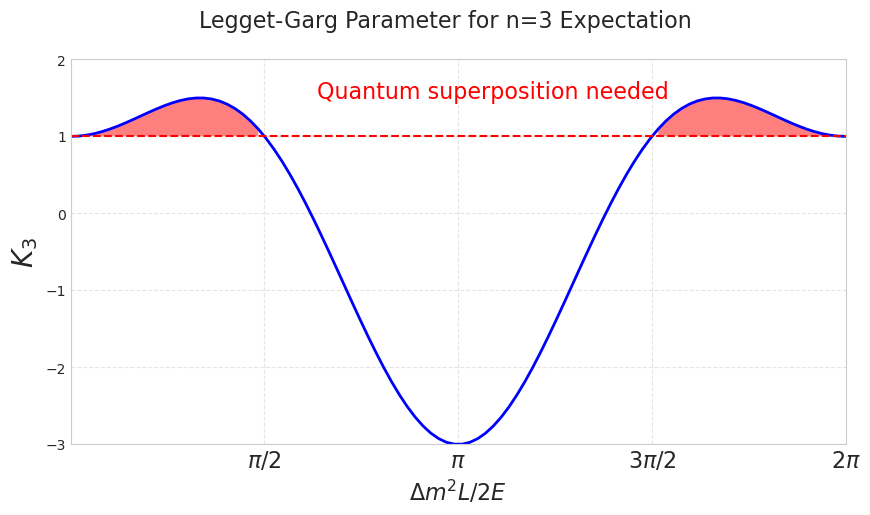

In [167]:
# Plotting for n=3
n=3
theta = np.linspace(0,2*np.pi,100)

K = np.zeros(100)
for i in range(100):
    K[i] = Kn(n,[theta[i],theta[i],theta[i]])

# Set seaborn style
sns.set_style("whitegrid")

# Plot the Legget-Garg parameter
fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(theta, K, color='blue', linewidth=2) 
plt.axhline(y=1, color='r', linestyle='--') # Dashed line at y=1
plt.fill_between(theta, K, 1, where=K>1, facecolor='red', alpha=0.5) # Fill the region where K>1
plt.text(2, 1.5, "Quantum superposition needed", fontsize=16, color='red')

# Set xticks
ax.set_xticks([np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax.set_xticklabels(['$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'], fontsize=16)

ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-3, 2)

ax.set_xlabel(r"$\Delta m^2L/2E$", fontsize=16)
ax.set_ylabel(r"$K_3$", fontsize=20)
fig.suptitle("Legget-Garg Parameter for n=3 Expectation", fontsize=16)

plt.grid(True, linestyle='--', alpha=0.5)
# Remove top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# Make ticks face inwards
ax.tick_params(direction='in')


## Neutrino MC extraction

In [168]:
# Extract mu neutrinos
int_type = (np.abs(neutrinos["pdg"]) == 14).astype(int) # non-mu neutrino is 0, mu neutrino NC is 1
int_type[(int_type == 1) & (neutrinos["type"] > 0)] = 2 # mu CC is 2

nonmu = neutrinos[int_type == 0]
mu_nc = neutrinos[int_type == 1]
mu_cc = neutrinos[int_type == 2]

# Make histograms
nonmu_hist, _ = np.histogramdd([np.log10(nonmu['reco_energy']),
                                 nonmu['reco_coszen'],
                                 nonmu['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[int_type == 0])

nonmu_hist = np.swapaxes(nonmu_hist, 0, 1)

mu_nc_hist, _ = np.histogramdd([np.log10(mu_nc['reco_energy']),
                                 mu_nc['reco_coszen'],
                                 mu_nc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[int_type == 1])

mu_nc_hist = np.swapaxes(mu_nc_hist, 0, 1)

mu_cc_hist, _ = np.histogramdd([np.log10(mu_cc['reco_energy']),
                                 mu_cc['reco_coszen'],
                                 mu_cc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[int_type == 2])

mu_cc_hist = np.swapaxes(mu_cc_hist, 0, 1)

## Muon Neutrinos with Honda MC

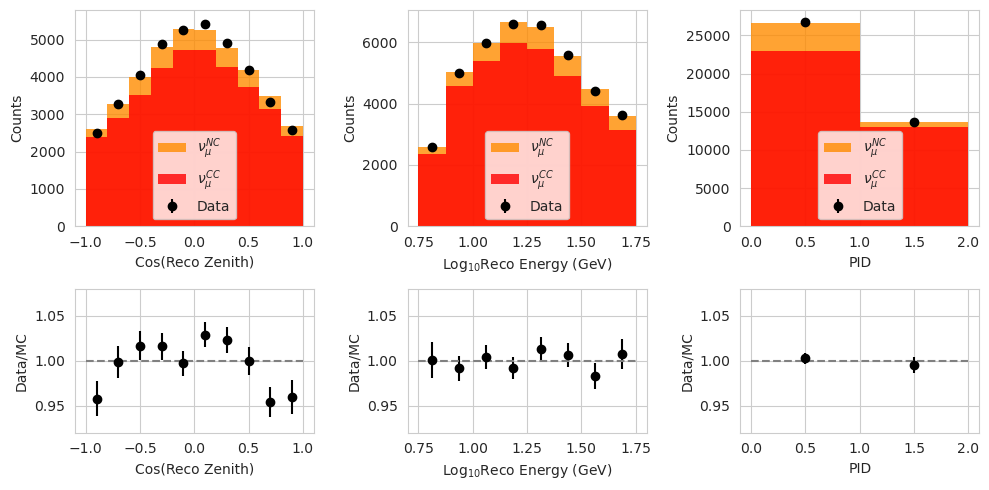

In [169]:
# Make a 3D histogram of the data where the track histogram has been padded with 0s to have the same shape as the cascades
track_padded = np.zeros_like(cascades_count)
track_padded[:, 2:] = track_count

data_signal_hist = data_hist - muon_hist - nonmu_hist


# Make a projection on each 3D axis of histogram for both the data and MC
# Plot each projection on the same figure but in separate subplots
# Subtract the muon MC from the data histogram
# The MC data is a filled histogram, while the data is a scatter plot
fig, axs = plt.subplots(2,3, figsize=(10, 5), height_ratios=[3, 2])
for j in range(2):
    axes= axs[j]
    for i, (ax, bins, xlabel) in enumerate(zip(axes, [bins_cz, bins_en, bins_pid], ("Cos(Reco Zenith)", r"Log$_{10}$Reco Energy (GeV)", "PID"))):
        axes_to_sum = tuple(set(range(3)) - set([i]))
        if j == 0:
            mu_nc_mc_proj = mu_nc_hist.sum(axis=axes_to_sum)
            mu_cc_mc_proj = mu_cc_hist.sum(axis=axes_to_sum)

            data_proj = data_signal_hist.sum(axis=axes_to_sum)
            # NOTE This is not perfectly accurate, since the MC errors are not a simple Poisson error
            data_proj_err = np.sqrt(
                np.sqrt(data_hist.sum(axis=axes_to_sum))**2 
                + np.sqrt(muon_hist.sum(axis=axes_to_sum))**2 
                + np.sqrt(nonmu_hist.sum(axis=axes_to_sum))**2)

            ax.stairs(mu_nc_mc_proj + mu_cc_mc_proj, bins, fill=True, alpha=0.8, label=r"$\nu_\mu^{NC}$", color="darkorange")
            ax.stairs(mu_cc_mc_proj, bins, fill=True, alpha=0.8, label=r"$\nu_\mu^{CC}$", color="red")
            ax.errorbar((bins[1:] + bins[:-1])/2, data_proj, yerr=data_proj_err, fmt='o', label="Data", c="k")
            ax.set_xlabel(xlabel)
            ax.set_ylabel("Counts")
            ax.legend()
        else:
            # Ratio of data to MC
            ratio = data_signal_hist.sum(axis=axes_to_sum)/(mu_nc_hist.sum(axis=axes_to_sum) + mu_cc_hist.sum(axis=axes_to_sum))
            ax.errorbar((bins[1:] + bins[:-1])/2, ratio, yerr=np.sqrt(data_signal_hist.sum(axis=axes_to_sum))/(mu_nc_hist.sum(axis=axes_to_sum) + mu_cc_hist.sum(axis=axes_to_sum)), fmt='o', c='k')
            ax.set_ylabel("Data/MC")
            ax.set_xlabel(xlabel)
            ax.set_ylim(0.92, 1.08)
            ax.hlines(1, bins[0], bins[-1], colors='grey', linestyles='--')

fig.tight_layout()

### Muon neutrinos as a function of L/E

In [299]:
# Calculate distance from bin center to bin edge for each bin
bin_widths_en = np.diff(bins_en)
bin_centers_en = (bins_en[1:] + bins_en[:-1])/2
bin_edges_en = np.array([bins_en[:-1], bins_en[1:]]).T
bin_distances_en = np.abs(bin_centers_en.reshape(-1, 1) - bin_edges_en)

bin_widths_cz = np.diff(bins_cz)
bin_centers_cz = (bins_cz[1:] + bins_cz[:-1])/2
bin_edges_cz = np.array([bins_cz[:-1], bins_cz[1:]]).T
bin_distances_cz = np.abs(bin_centers_cz.reshape(-1, 1) - bin_edges_cz)

bins_pathlength = calc_path_length_from_coszen(bins_cz)
bin_widths_pathlength = np.diff(bins_pathlength)
bin_centers_pathlength = (bins_pathlength[1:] + bins_pathlength[:-1])/2
bin_centers_pathlength = calc_path_length_from_coszen(bin_centers_cz)
bin_edges_pathlength = np.array([bins_pathlength[:-1], bins_pathlength[1:]]).T
bin_distances_pathlength = np.abs(bin_centers_pathlength.reshape(-1, 1) - bin_edges_pathlength)

# combine bins_pathlength and bins_en
L_over_E = bins_pathlength[:, np.newaxis] / 10**bins_en
L_over_E_bin_centers = bin_centers_pathlength[:, np.newaxis] / 10**bin_centers_en

# Calculate xerr for each L/E bin (distance from L_over_E_bin_center to bin edges)
xmin = L_over_E_bin_centers - L_over_E[1:, 1:]
xmax = L_over_E[:-1, :-1] - L_over_E_bin_centers


# Calculate yerr for each L/E bin (max and min probabilities over the bin)
xvals = np.linspace(L_over_E_bin_centers - xmin, L_over_E_bin_centers + xmax, 100)
ymin = np.zeros_like(L_over_E_bin_centers)
ymax = np.zeros_like(L_over_E_bin_centers)
for i in range(len(bins_cz)-1):
    for j in range(len(bins_en)-1):
        yvals = muon_survival_prob(L_km_over_E_GeV=xvals[:, i, j])
        ymin[i, j] = muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers[i, j])-min(yvals)
        ymax[i, j] = max(yvals)-muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers[i, j])
        if muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers[i, j]) - ymin[i, j] < 0:
            print("something is wrong")
        if muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers[i, j]) + ymax[i, j] > 1:
            print("something is wrong")

#### What bins have a high fraction of muon neutrinos?

/tmp/ipykernel_4936/3745729017.py:26: RuntimeWarning: invalid value encountered in divide
  cmesh = ax[1].pcolormesh(bins_en, bins_cz, (unosc_mu_cc_hist[:, :, 1] + unosc_mu_nc_hist[:, :, 1])/(unosc_honda_hist[:, :, 1] + muon_hist[:, :, 1]), cmap='Blues', vmin=0, vmax=1)
/tmp/ipykernel_4936/3745729017.py:34: RuntimeWarning: invalid value encountered in scalar divide
  ax[1].text(bin_centers_en[j], bin_centers_cz[i], f"{((mu_cc_hist[i, j, 1] + mu_nc_hist[i, j, 1])/(nu_hist_honda[i, j, 1] + muon_hist[i, j, 1]))*100:.1f}%", ha='center', va='center', color='black')


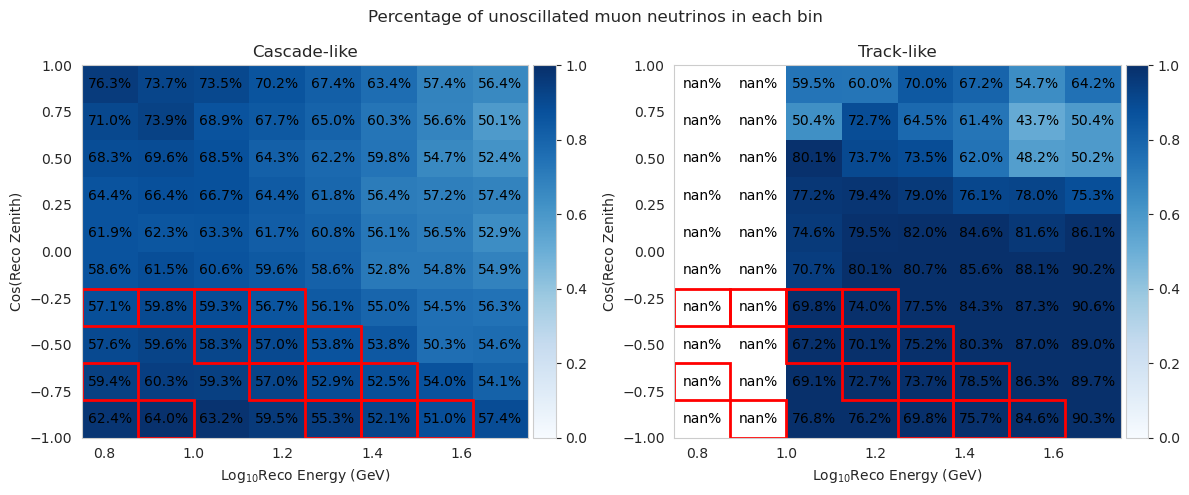

In [296]:
# Calculate unoscillated neutrino weights
unosc_neutrino_weights = neutrino_weights_no_normalization / oscillation_probabilities(neutrinos=neutrinos, delta_m32=2.53e-3, theta_23=49.8)
unosc_mu_nc_hist, _ = np.histogramdd([np.log10(mu_nc['reco_energy']),
                                 mu_nc['reco_coszen'],
                                 mu_nc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = unosc_neutrino_weights[int_type == 1])

unosc_mu_nc_hist = np.swapaxes(unosc_mu_nc_hist, 0, 1)

unosc_mu_cc_hist, _ = np.histogramdd([np.log10(mu_cc['reco_energy']),
                                 mu_cc['reco_coszen'],
                                 mu_cc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = unosc_neutrino_weights[int_type == 2])

unosc_mu_cc_hist = np.swapaxes(unosc_mu_cc_hist, 0, 1)

# Make a 2D plot of the percentage of the muon neutrinos in each bin. Write the exact percentages into the rectangles
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
cmesh = ax[0].pcolormesh(bins_en, bins_cz, (unosc_mu_cc_hist[:, :, 0] + unosc_mu_nc_hist[:, :, 0])/(unosc_honda_hist[:, :, 0] + muon_hist[:, :, 0]), cmap='Blues', vmin=0, vmax=1)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax[1].pcolormesh(bins_en, bins_cz, (unosc_mu_cc_hist[:, :, 1] + unosc_mu_nc_hist[:, :, 1])/(unosc_honda_hist[:, :, 1] + muon_hist[:, :, 1]), cmap='Blues', vmin=0, vmax=1)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

for i in range(len(bins_cz)-1):
    for j in range(len(bins_en)-1):
        ax[0].text(bin_centers_en[j], bin_centers_cz[i], f"{((mu_cc_hist[i, j, 0] + mu_nc_hist[i, j, 0])/(nu_hist_honda[i, j, 0] + muon_hist[i, j, 0]))*100:.1f}%", ha='center', va='center', color='black')
        ax[1].text(bin_centers_en[j], bin_centers_cz[i], f"{((mu_cc_hist[i, j, 1] + mu_nc_hist[i, j, 1])/(nu_hist_honda[i, j, 1] + muon_hist[i, j, 1]))*100:.1f}%", ha='center', va='center', color='black')
        if muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers[i, j]) < 0.5:
            ax[0].add_patch(Rectangle((bins_en[j], bins_cz[i]), bin_widths_en[j], bin_widths_cz[i], edgecolor='red', fill=None, linewidth=2))
            ax[1].add_patch(Rectangle((bins_en[j], bins_cz[i]), bin_widths_en[j], bin_widths_cz[i], edgecolor='red', fill=None, linewidth=2))
            
ax[0].set_title("Cascade-like")
ax[1].set_title("Track-like")
ax[1].grid()
ax[0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax[1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax[0].set_ylabel("Cos(Reco Zenith)")
ax[1].set_ylabel("Cos(Reco Zenith)")

fig.suptitle("Percentage of unoscillated muon neutrinos in each bin")
fig.tight_layout()

Red is where the muon survival probability is smaller than 0.5

#### Percentage of muon neutrinos getting reconstructed correctly?

counts of muon neutrinos with en_reco_type == 1:  841791
 counts of muon neutrions:  842382


/tmp/ipykernel_4936/3542750849.py:73: RuntimeWarning: invalid value encountered in divide
  cmesh = ax[1].pcolormesh(bins_en, bins_cz, (good_reco_mu_cc_hist[:, :, 1] + good_reco_mu_nc_hist[:, :, 1])/(mu_cc_hist[:, :, 1] + mu_nc_hist[:, :, 1]), cmap='Blues', vmin=0, vmax=1)
/tmp/ipykernel_4936/3542750849.py:82: RuntimeWarning: invalid value encountered in scalar divide
  ax[1].text(bin_centers_en[j], bin_centers_cz[i], f"{((good_reco_mu_cc_hist[i, j, 1] + good_reco_mu_nc_hist[i, j, 1])/(mu_cc_hist[i, j, 1] + mu_nc_hist[i, j, 1]))*100:.1f}%", ha='center', va='center', color='black')
/tmp/ipykernel_4936/3542750849.py:101: RuntimeWarning: invalid value encountered in divide
  ax[1].pcolormesh(bins_en, bins_cz, (good_reco_mu_nc_hist[:, :, 1] + good_reco_mu_cc_hist[:, :, 1])/(nu_hist_honda[:, :, 1] + muon_hist[:, :, 1]), cmap='Blues', vmin=0, vmax=1)
/tmp/ipykernel_4936/3542750849.py:105: RuntimeWarning: invalid value encountered in scalar divide
  ax[1].text(bin_centers_en[j], bin_centers_c

mu_neutrinos_hist == mu_cc_hist + mu_nc_hist:  True


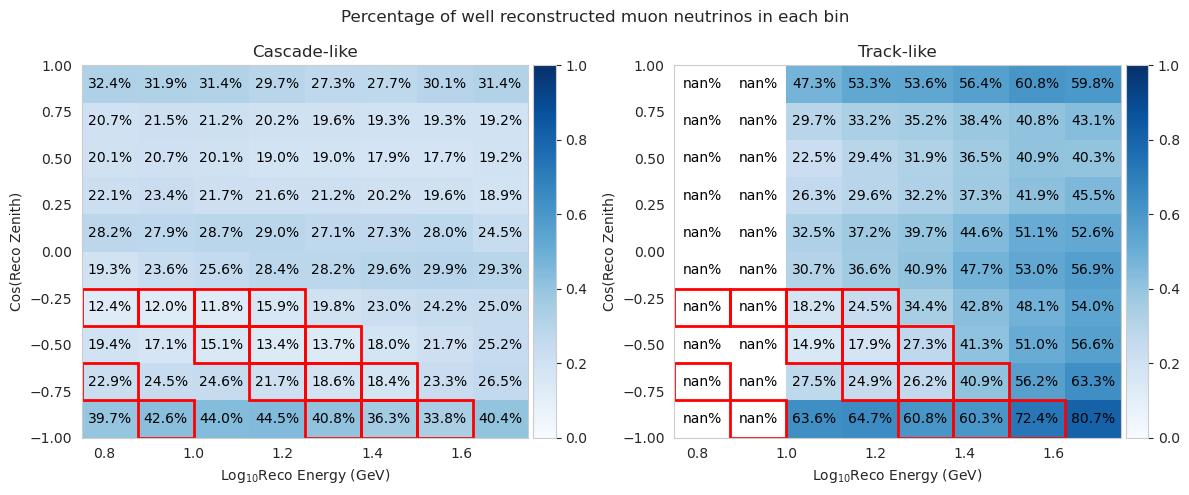

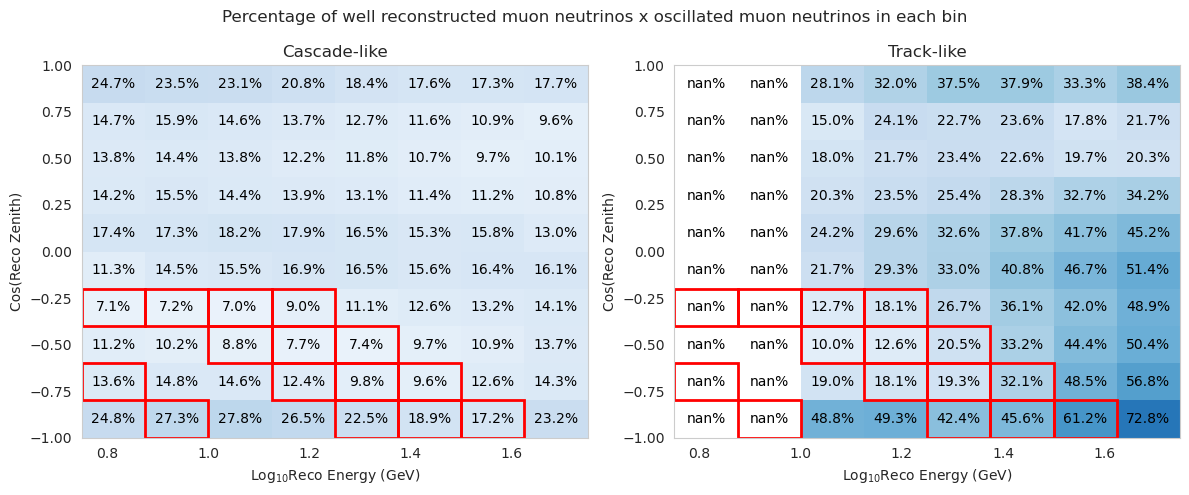

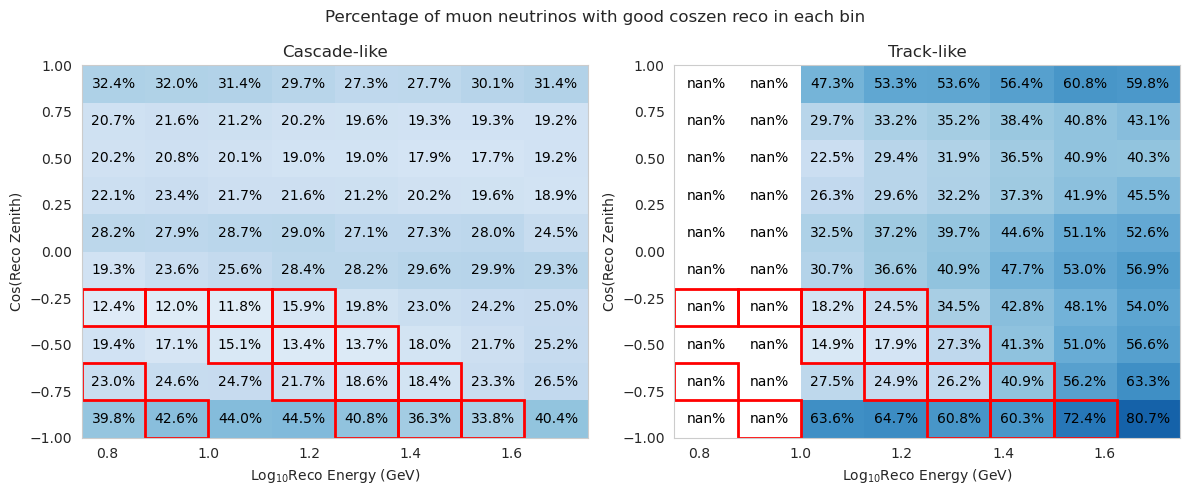

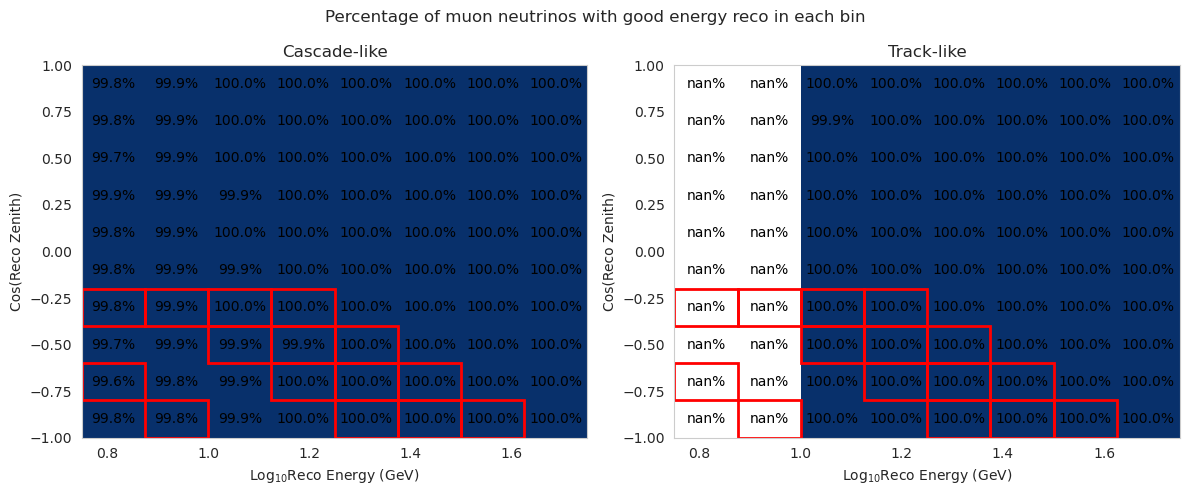

In [297]:
# Of the muon neutrinos in each bin, plot the percentage of them that have true energy and true coszen within the bin

# Extract NC and CC mu neutrinos
int_type = (np.abs(neutrinos["pdg"]) == 14).astype(int) # non-mu neutrino is 0, mu neutrino is 1
int_type[(int_type == 1) & (neutrinos["type"] > 0)] = 2 # mu CC is 2

# Check if the reconstructed energy and coszenith are in the same bin as the true energy and coszenith
en_reco_type = (np.digitize(neutrinos["reco_energy"], bins_en) == np.digitize(neutrinos["true_energy"], bins_en)).astype(int)
cz_reco_type = (np.digitize(neutrinos["reco_coszen"], bins_cz) == np.digitize(neutrinos["true_coszen"], bins_cz)).astype(int)


# Make histograms 
mu_neutrinos_hist, _ = np.histogramdd([np.log10(neutrinos[int_type > 0]['reco_energy']),
                                        neutrinos[int_type > 0]['reco_coszen'],
                                        neutrinos[int_type > 0]['pid']],
                                          bins = [bins_en, bins_cz, bins_pid],
                                          weights = neutrino_weights[int_type > 0])

mu_neutrinos_hist = np.swapaxes(mu_neutrinos_hist, 0, 1)

good_cz_reco_mu_hist, _ = np.histogramdd([np.log10(neutrinos[(int_type > 0) & (cz_reco_type == 1)]['reco_energy']),
                                            neutrinos[(int_type > 0) & (cz_reco_type == 1)]['reco_coszen'],
                                            neutrinos[(int_type > 0) & (cz_reco_type == 1)]['pid']],
                                             bins = [bins_en, bins_cz, bins_pid],
                                                weights = neutrino_weights[(int_type > 0) & (cz_reco_type == 1)])

good_cz_reco_mu_hist = np.swapaxes(good_cz_reco_mu_hist, 0, 1)

good_en_reco_mu_hist, _ = np.histogramdd([np.log10(neutrinos[(int_type > 0) & (en_reco_type == 1)]['reco_energy']),
                                            neutrinos[(int_type > 0) & (en_reco_type == 1)]['reco_coszen'],
                                            neutrinos[(int_type > 0) & (en_reco_type == 1)]['pid']],
                                             bins = [bins_en, bins_cz, bins_pid],
                                                weights = neutrino_weights[(int_type > 0) & (en_reco_type == 1)])

good_en_reco_mu_hist = np.swapaxes(good_en_reco_mu_hist, 0, 1)

good_reco_mu_nc_hist, _ = np.histogramdd([np.log10(neutrinos[(int_type == 1) & (en_reco_type == 1) & (cz_reco_type == 1)]['reco_energy']),
                                            neutrinos[(int_type == 1) & (en_reco_type == 1) & (cz_reco_type == 1)]['reco_coszen'],
                                            neutrinos[(int_type == 1) & (en_reco_type == 1) & (cz_reco_type == 1)]['pid']],
                                             bins = [bins_en, bins_cz, bins_pid],
                                                weights = neutrino_weights[(int_type == 1) & (en_reco_type == 1) & (cz_reco_type == 1)])

good_reco_mu_nc_hist = np.swapaxes(good_reco_mu_nc_hist, 0, 1)

good_reco_mu_cc_hist, _ = np.histogramdd([np.log10(neutrinos[(int_type == 2) & (en_reco_type == 1) & (cz_reco_type == 1)]['reco_energy']),
                                            neutrinos[(int_type == 2) & (en_reco_type == 1) & (cz_reco_type == 1)]['reco_coszen'],
                                            neutrinos[(int_type == 2) & (en_reco_type == 1) & (cz_reco_type == 1)]['pid']],
                                             bins = [bins_en, bins_cz, bins_pid],
                                                weights = neutrino_weights[(int_type == 2) & (en_reco_type == 1) & (cz_reco_type == 1)])

good_reco_mu_cc_hist = np.swapaxes(good_reco_mu_cc_hist, 0, 1)


print("counts of muon neutrinos with en_reco_type == 1: ", len(neutrinos[(int_type > 0) & (en_reco_type == 1)]))
print(" counts of muon neutrions: ", len(neutrinos[int_type > 0]))
# print("counts of neutrinos with cz_reco_type == 1: ", len(neutrinos[cz_reco_type == 1]))
# print("counts of neutrinos with both en_reco_type == 1 and en_reco_type == 1] == 1]e == 1: ", len(neutrinos[(en_reco_type == 1) & (cz_reco_type == 1)]))
# print(" counts of NC muon neutrinos with both en_reco_type == 1 and cz_reco_type == 1: ", len(neutrinos[(int_type == 1) & (en_reco_type == 1) & (cz_reco_type == 1)]))
# print(" counts of CC muon neutrinos with both en_reco_type == 1 and cz_reco_type == 1: ", len(neutrinos[(int_type == 2) & (en_reco_type == 1) & (cz_reco_type == 1)]))
# print(" Counts of good reco mu NC: ", good_reco_mu_nc_hist.sum())
# print(" Counts of good reco mu CC: ", good_reco_mu_cc_hist.sum())


# Plot the percentage of the muon neutrinos in each bin that have true energy and true coszen within the bin
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cmesh = ax[0].pcolormesh(bins_en, bins_cz, (good_reco_mu_cc_hist[:, :, 0] + good_reco_mu_nc_hist[:, :, 0])/(mu_cc_hist[:, :, 0] + mu_nc_hist[:, :, 0]), cmap='Blues', vmin=0, vmax=1)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)

plt.colorbar(cmesh, cax)

cmesh = ax[1].pcolormesh(bins_en, bins_cz, (good_reco_mu_cc_hist[:, :, 1] + good_reco_mu_nc_hist[:, :, 1])/(mu_cc_hist[:, :, 1] + mu_nc_hist[:, :, 1]), cmap='Blues', vmin=0, vmax=1)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)

plt.colorbar(cmesh, cax)

for i in range(len(bins_cz)-1):
    for j in range(len(bins_en)-1):
        ax[0].text(bin_centers_en[j], bin_centers_cz[i], f"{((good_reco_mu_cc_hist[i, j, 0] + good_reco_mu_nc_hist[i, j, 0])/(mu_cc_hist[i, j, 0] + mu_nc_hist[i, j, 0]))*100:.1f}%", ha='center', va='center', color='black')
        ax[1].text(bin_centers_en[j], bin_centers_cz[i], f"{((good_reco_mu_cc_hist[i, j, 1] + good_reco_mu_nc_hist[i, j, 1])/(mu_cc_hist[i, j, 1] + mu_nc_hist[i, j, 1]))*100:.1f}%", ha='center', va='center', color='black')
        if muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers[i, j]) < 0.5:
            ax[0].add_patch(Rectangle((bins_en[j], bins_cz[i]), bin_widths_en[j], bin_widths_cz[i], edgecolor='red', fill=None, linewidth=2))
            ax[1].add_patch(Rectangle((bins_en[j], bins_cz[i]), bin_widths_en[j], bin_widths_cz[i], edgecolor='red', fill=None, linewidth=2))

ax[0].set_title("Cascade-like")
ax[1].set_title("Track-like")
ax[1].grid()
ax[0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax[1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax[0].set_ylabel("Cos(Reco Zenith)")
ax[1].set_ylabel("Cos(Reco Zenith)")

fig.suptitle("Percentage of well reconstructed muon neutrinos in each bin")
fig.tight_layout()

# Plot the percentage of the neutrinos in each bin that have true energy and true coszen within the bin and are muon neutrinos
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pcolormesh(bins_en, bins_cz, (good_reco_mu_nc_hist[:, :, 0] + good_reco_mu_cc_hist[:, :, 0])/(nu_hist_honda[:, :, 0] + muon_hist[:, :, 0]), cmap='Blues', vmin=0, vmax=1)
ax[1].pcolormesh(bins_en, bins_cz, (good_reco_mu_nc_hist[:, :, 1] + good_reco_mu_cc_hist[:, :, 1])/(nu_hist_honda[:, :, 1] + muon_hist[:, :, 1]), cmap='Blues', vmin=0, vmax=1)
for i in range(len(bins_cz)-1):
    for j in range(len(bins_en)-1):
        ax[0].text(bin_centers_en[j], bin_centers_cz[i], f"{((good_reco_mu_nc_hist[i, j, 0] + good_reco_mu_cc_hist[i, j, 0])/(nu_hist_honda[i, j, 0] + muon_hist[i, j, 0]))*100:.1f}%", ha='center', va='center', color='black')
        ax[1].text(bin_centers_en[j], bin_centers_cz[i], f"{((good_reco_mu_nc_hist[i, j, 1] + good_reco_mu_cc_hist[i, j, 1])/(nu_hist_honda[i, j, 1] + muon_hist[i, j, 1]))*100:.1f}%", ha='center', va='center', color='black')
        if muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers[i, j]) < 0.5:
            ax[0].add_patch(Rectangle((bins_en[j], bins_cz[i]), bin_widths_en[j], bin_widths_cz[i], edgecolor='red', fill=None, linewidth=2))
            ax[1].add_patch(Rectangle((bins_en[j], bins_cz[i]), bin_widths_en[j], bin_widths_cz[i], edgecolor='red', fill=None, linewidth=2))

ax[0].set_title("Cascade-like")
ax[1].set_title("Track-like")
ax[1].grid()
ax[0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax[1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax[0].set_ylabel("Cos(Reco Zenith)")
ax[1].set_ylabel("Cos(Reco Zenith)")

fig.suptitle("Percentage of well reconstructed muon neutrinos x oscillated muon neutrinos in each bin")
fig.tight_layout()


# Plot the percentage of the neutrinos in each bin that have true coszen within the bin and are muon neutrinos
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pcolormesh(bins_en, bins_cz, (good_cz_reco_mu_hist[:, :, 0])/(mu_neutrinos_hist[:, :, 0]), cmap='Blues', vmin=0, vmax=1)
ax[1].pcolormesh(bins_en, bins_cz, (good_cz_reco_mu_hist[:, :, 1])/(mu_neutrinos_hist[:, :, 1]), cmap='Blues', vmin=0, vmax=1)
for i in range(len(bins_cz)-1):
    for j in range(len(bins_en)-1):
        ax[0].text(bin_centers_en[j], bin_centers_cz[i], f"{(good_cz_reco_mu_hist[i, j, 0])/(mu_neutrinos_hist[i, j, 0])*100:.1f}%", ha='center', va='center', color='black')
        ax[1].text(bin_centers_en[j], bin_centers_cz[i], f"{(good_cz_reco_mu_hist[i, j, 1])/(mu_neutrinos_hist[i, j, 1])*100:.1f}%", ha='center', va='center', color='black')
        if muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers[i, j]) < 0.5:
            ax[0].add_patch(Rectangle((bins_en[j], bins_cz[i]), bin_widths_en[j], bin_widths_cz[i], edgecolor='red', fill=None, linewidth=2))
            ax[1].add_patch(Rectangle((bins_en[j], bins_cz[i]), bin_widths_en[j], bin_widths_cz[i], edgecolor='red', fill=None, linewidth=2))

ax[0].set_title("Cascade-like")
ax[1].set_title("Track-like")
ax[1].grid()
ax[0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax[1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax[0].set_ylabel("Cos(Reco Zenith)")
ax[1].set_ylabel("Cos(Reco Zenith)")

fig.suptitle("Percentage of muon neutrinos with good coszen reco in each bin")
fig.tight_layout()

# Plot the percentage of the neutrinos in each bin that have true energy within the bin and are muon neutrinos
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pcolormesh(bins_en, bins_cz, (good_en_reco_mu_hist[:, :, 0])/(mu_neutrinos_hist[:, :, 0]), cmap='Blues', vmin=0, vmax=1)
ax[1].pcolormesh(bins_en, bins_cz, (good_en_reco_mu_hist[:, :, 1])/(mu_neutrinos_hist[:, :, 1]), cmap='Blues', vmin=0, vmax=1)
for i in range(len(bins_cz)-1):
    for j in range(len(bins_en)-1):
        ax[0].text(bin_centers_en[j], bin_centers_cz[i], f"{(good_en_reco_mu_hist[i, j, 0])/(mu_neutrinos_hist[i, j, 0])*100:.1f}%", ha='center', va='center', color='black')
        ax[1].text(bin_centers_en[j], bin_centers_cz[i], f"{(good_en_reco_mu_hist[i, j, 1])/(mu_neutrinos_hist[i, j, 1])*100:.1f}%", ha='center', va='center', color='black')
        if muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers[i, j]) < 0.5:
            ax[0].add_patch(Rectangle((bins_en[j], bins_cz[i]), bin_widths_en[j], bin_widths_cz[i], edgecolor='red', fill=None, linewidth=2))
            ax[1].add_patch(Rectangle((bins_en[j], bins_cz[i]), bin_widths_en[j], bin_widths_cz[i], edgecolor='red', fill=None, linewidth=2))

ax[0].set_title("Cascade-like")
ax[1].set_title("Track-like")
ax[1].grid()
ax[0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax[1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax[0].set_ylabel("Cos(Reco Zenith)")
ax[1].set_ylabel("Cos(Reco Zenith)")

fig.suptitle("Percentage of muon neutrinos with good energy reco in each bin")
fig.tight_layout()

# Check whether mu_neutrinos_hist is the same as mu_cc_hist + mu_nc_hist
print("mu_neutrinos_hist == mu_cc_hist + mu_nc_hist: ", np.allclose(mu_neutrinos_hist, mu_cc_hist + mu_nc_hist))


#### L/E MC-Data agreement

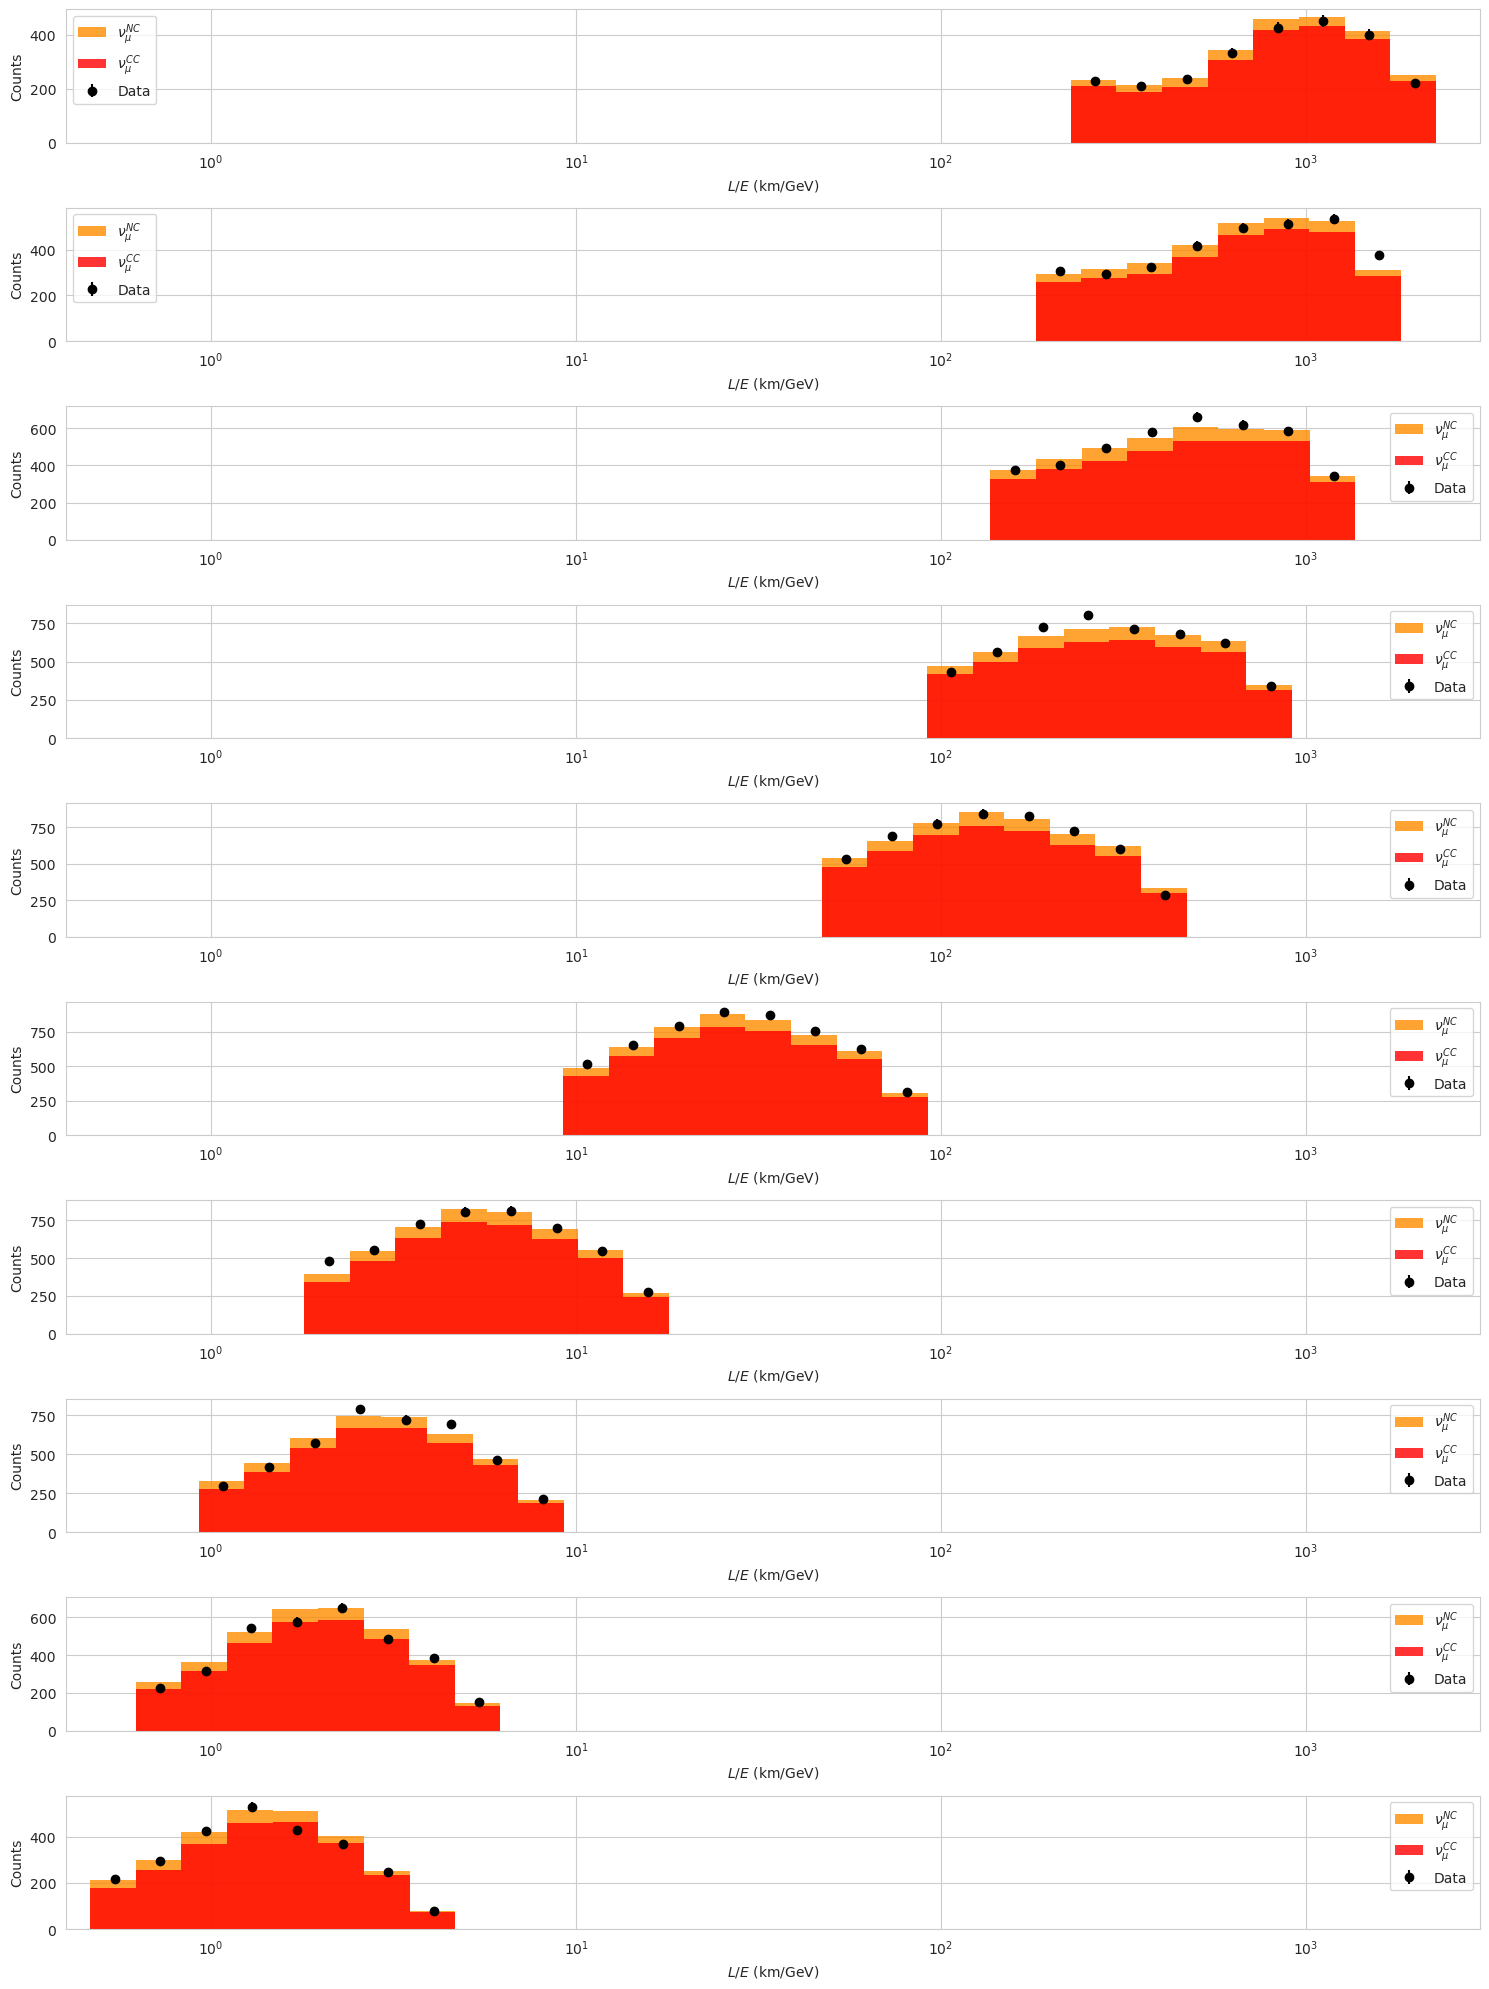

In [272]:
fig, axs= plt.subplots(10,1, figsize=(15, 20))
for i, ax in zip(range(len(bins_cz)-1), axs):
    ax.stairs(mu_nc_hist.sum(axis=2)[i] + mu_cc_hist.sum(axis=2)[i], L_over_E[i], fill=True, alpha=0.8, label=r"$\nu_\mu^{NC}$", color="darkorange")
    ax.stairs(mu_cc_hist.sum(axis=2)[i], L_over_E[i], fill=True, alpha=0.8, label=r"$\nu_\mu^{CC}$", color="red")
    ax.errorbar((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist.sum(axis=2)[i], yerr=np.sqrt(data_signal_hist.sum(axis=2)[i]), fmt='o', label="Data", c="k")
    #ax.errorbar(L_over_E_bin_centers[i], data_signal_hist.sum(axis=2)[i], fmt='o', label="Muon survival probability", c="blue")
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(.4, 3000)
    ax.set_ylabel("Counts")
    ax.legend()
    # make x axis logarithmic
    ax.set_xscale('log')

fig.tight_layout()

Maybe we could do a fit with PISA not to get the best Data MC agreement overall, but to improve the numu/track data MC agreement....

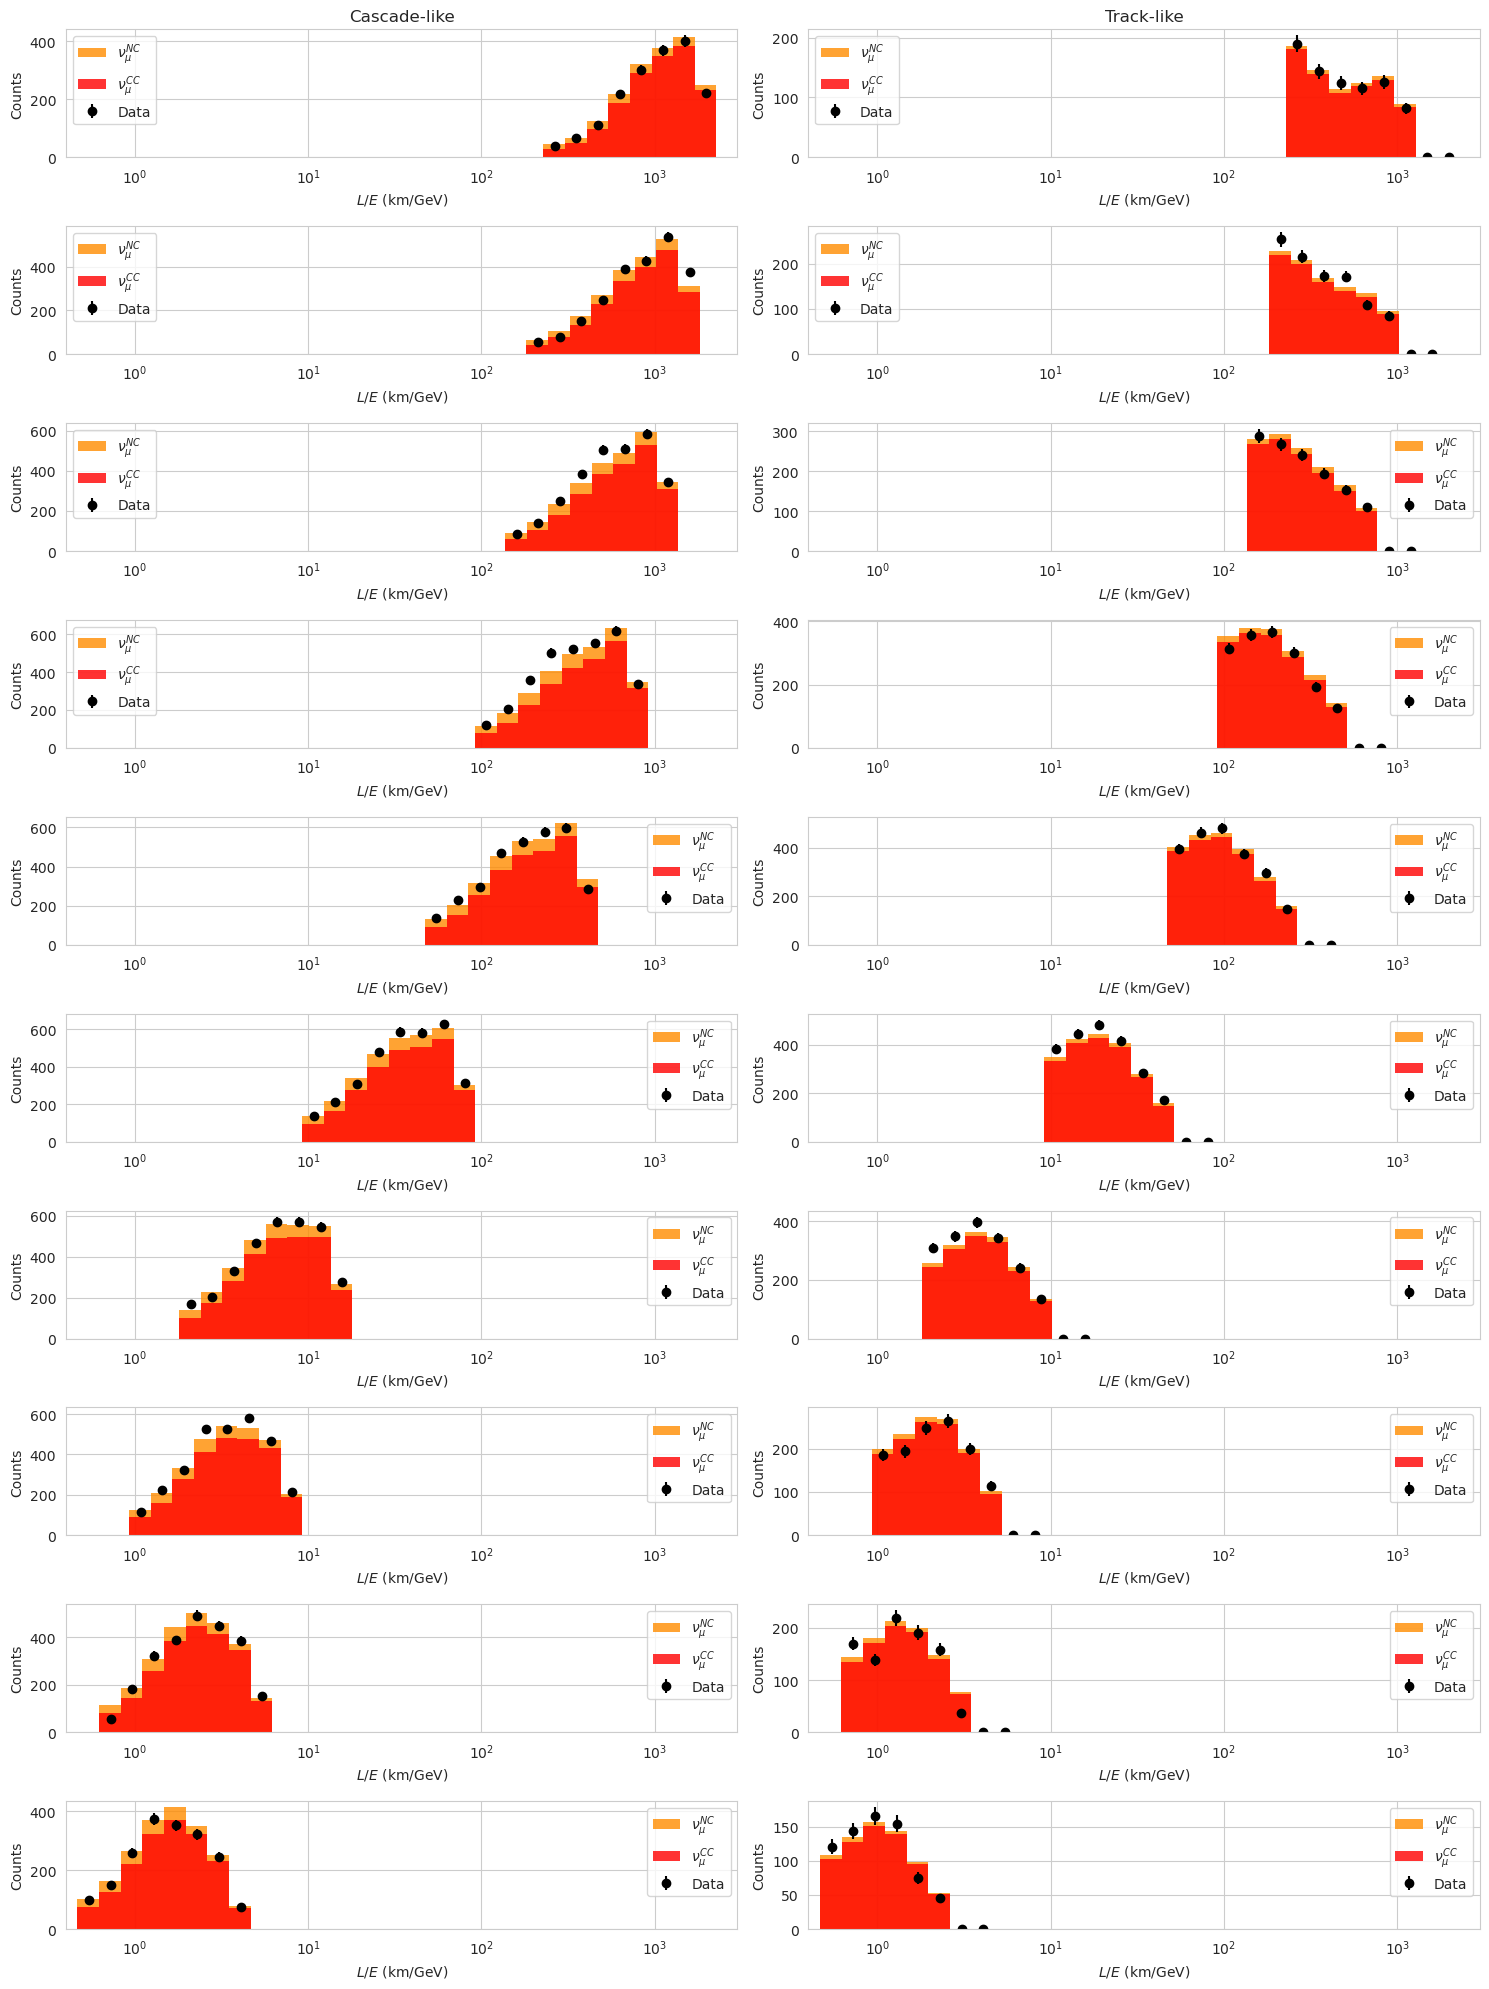

In [273]:
fig, axs= plt.subplots(10,2, figsize=(15, 20))
for i, ax in zip(range(len(bins_cz)-1), axs[:, 0]):
    ax.stairs(mu_nc_hist[:, :, 0][i] + mu_cc_hist[:, :, 0][i], L_over_E[i], fill=True, alpha=0.8, label=r"$\nu_\mu^{NC}$", color="darkorange")
    ax.stairs(mu_cc_hist[:, :, 0][i], L_over_E[i], fill=True, alpha=0.8, label=r"$\nu_\mu^{CC}$", color="red")
    ax.errorbar((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist[:, :, 0][i], yerr=np.sqrt(data_signal_hist[:, :, 0][i]), fmt='o', label="Data", c="k")
    #ax.errorbar(L_over_E_bin_centers[i], data_signal_hist.sum(axis=2)[i], fmt='o', label="Muon survival probability", c="blue")
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(.4, 3000)
    ax.set_ylabel("Counts")
    ax.legend()
    ax.set_title("Cascade-like" if i == 0 else None)
    ax.set_xscale('log')

for i, ax in zip(range(len(bins_cz)-1), axs[:, 1]):
    ax.stairs(mu_nc_hist[:, :, 1][i] + mu_cc_hist[:, :, 1][i], L_over_E[i], fill=True, alpha=0.8, label=r"$\nu_\mu^{NC}$", color="darkorange")
    ax.stairs(mu_cc_hist[:, :, 1][i], L_over_E[i], fill=True, alpha=0.8, label=r"$\nu_\mu^{CC}$", color="red")
    ax.errorbar((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist[:, :, 1][i], yerr=np.sqrt(data_signal_hist[:, :, 1][i]), fmt='o', label="Data", c="k")
    #ax.errorbar(L_over_E_bin_centers[i], data_signal_hist.sum(axis=2)[i], fmt='o', label="Muon survival probability", c="blue")
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(.4, 3000)
    ax.set_ylabel("Counts")
    ax.legend()
    ax.set_title("Track-like" if i == 0 else None)
    ax.set_xscale('log')

fig.tight_layout()

/tmp/ipykernel_4936/893544558.py:15: RuntimeWarning: invalid value encountered in divide
  ax.errorbar((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist[:, :, 1][i]/(mu_nc_hist[:, :, 1][i] + mu_cc_hist[:, :, 1][i]), yerr=np.sqrt(data_signal_hist[:, :, 1][i])/(mu_nc_hist[:, :, 1][i] + mu_cc_hist[:, :, 1][i])  if np.any(mu_nc_hist[:, :, 0][i] + mu_cc_hist[:, :, 0][i]) != 0 else 0, fmt='o', c='k')


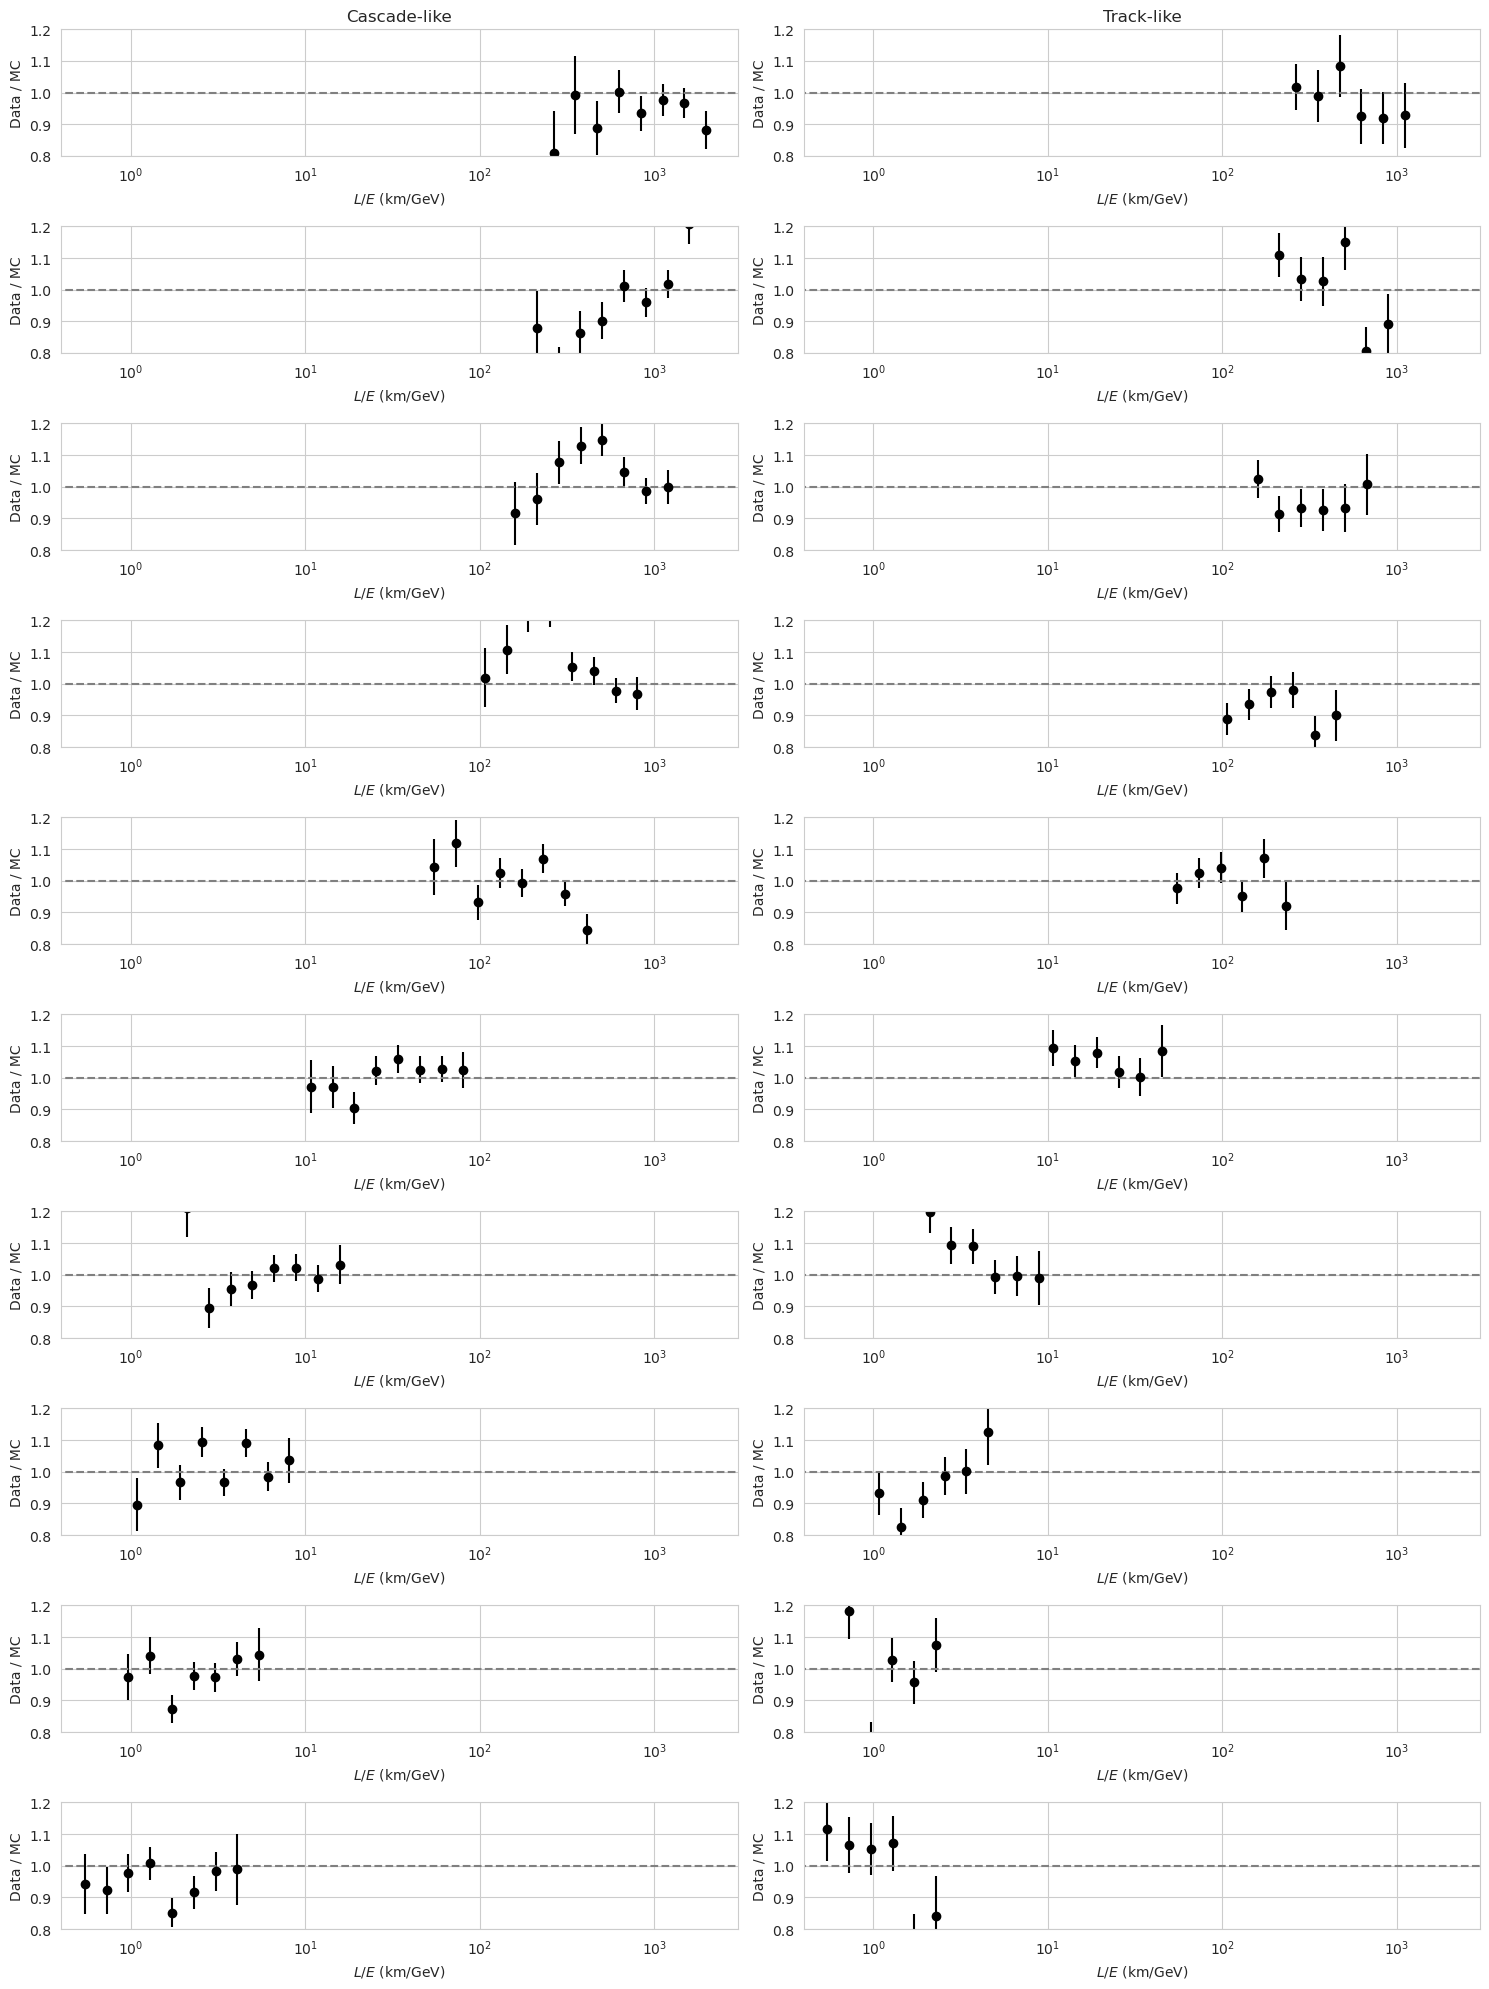

In [274]:
fig, axs= plt.subplots(10,2, figsize=(15, 20))
ratio = data_signal_hist[:, :, 0][i]/(mu_nc_hist[:, :, 0][i] + mu_cc_hist[:, :, 0][i]) if np.any(mu_nc_hist[:, :, 0][i] + mu_cc_hist[:, :, 0][i]) != 0 else 0

for i, ax in zip(range(len(bins_cz)-1), axs[:, 0]):
    ax.errorbar((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist[:, :, 0][i]/(mu_nc_hist[:, :, 0][i] + mu_cc_hist[:, :, 0][i]), yerr=np.sqrt(data_signal_hist[:, :, 0][i])/(mu_nc_hist[:, :, 0][i] + mu_cc_hist[:, :, 0][i]) if np.any(mu_nc_hist[:, :, 0][i] + mu_cc_hist[:, :, 0][i]) != 0 else 0, fmt='o', c='k')
    ax.plot(np.logspace(-1, 10000, 100), np.ones(100), color = 'grey', linestyle='--')
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(.4, 3000)
    ax.set_ylim(0.8, 1.2)
    ax.set_ylabel("Data / MC")
    ax.set_title("Cascade-like" if i == 0 else None)
    ax.set_xscale('log')

for i, ax in zip(range(len(bins_cz)-1), axs[:, 1]):
    ax.errorbar((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist[:, :, 1][i]/(mu_nc_hist[:, :, 1][i] + mu_cc_hist[:, :, 1][i]), yerr=np.sqrt(data_signal_hist[:, :, 1][i])/(mu_nc_hist[:, :, 1][i] + mu_cc_hist[:, :, 1][i])  if np.any(mu_nc_hist[:, :, 0][i] + mu_cc_hist[:, :, 0][i]) != 0 else 0, fmt='o', c='k')
    ax.plot(np.logspace(-1, 10000, 100), np.ones(100), color = 'grey', linestyle='--')
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(.4, 3000)
    ax.set_ylim(0.8, 1.2)
    ax.set_ylabel("Data / MC")
    ax.set_title("Track-like" if i == 0 else None)
    ax.set_xscale('log')

fig.tight_layout()

## Plot muon neutrino survival probability

### Survival probability MC

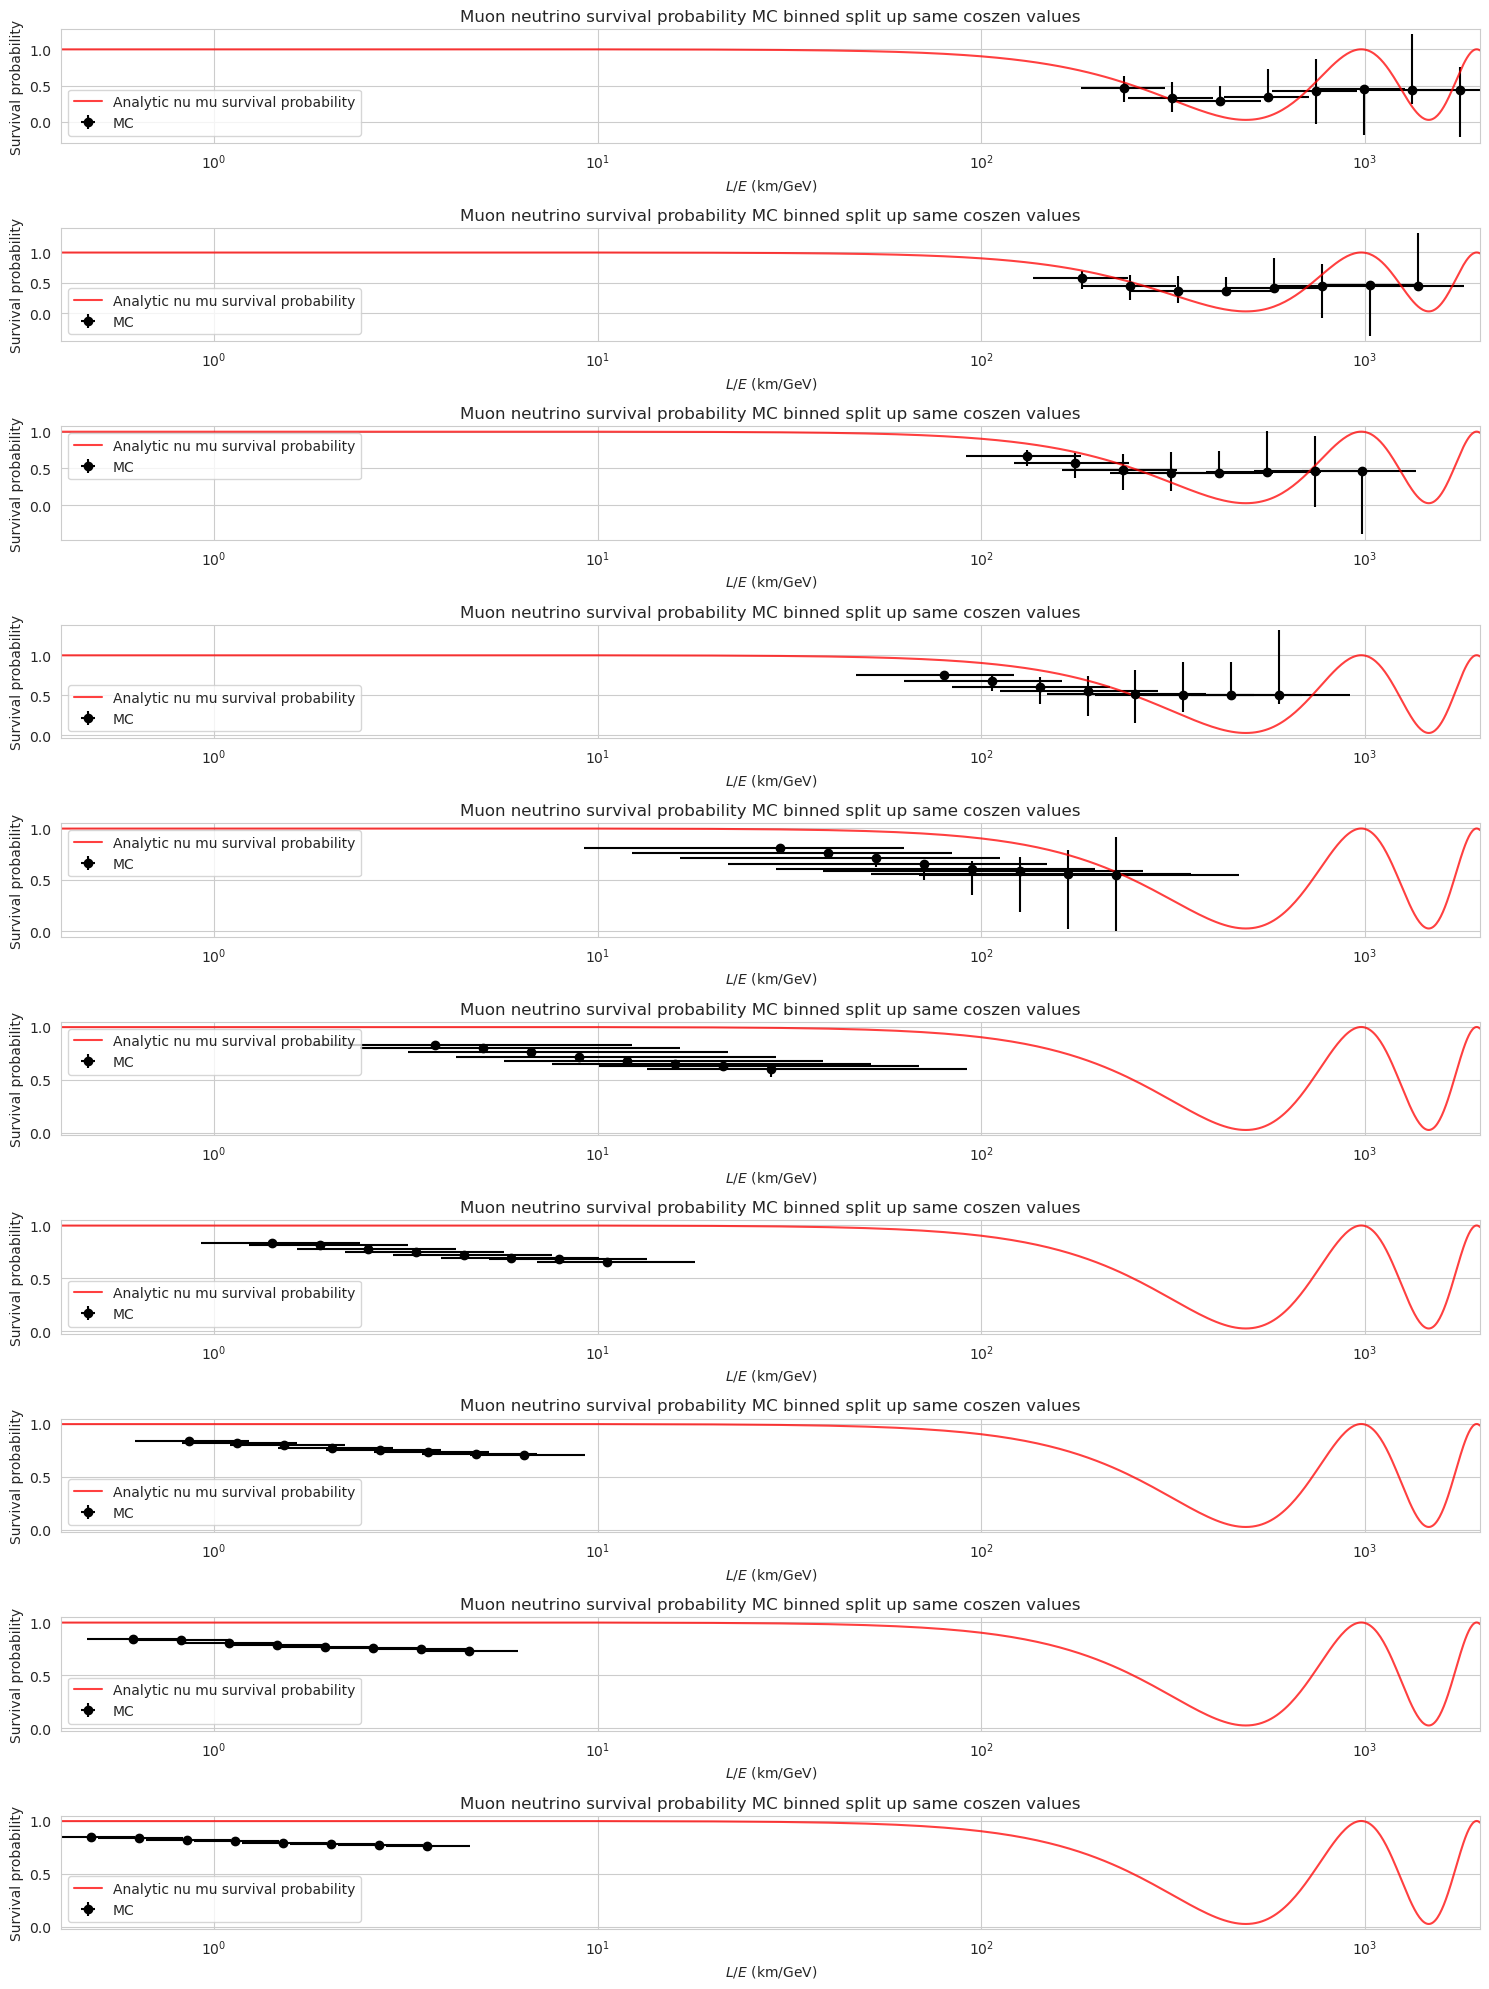

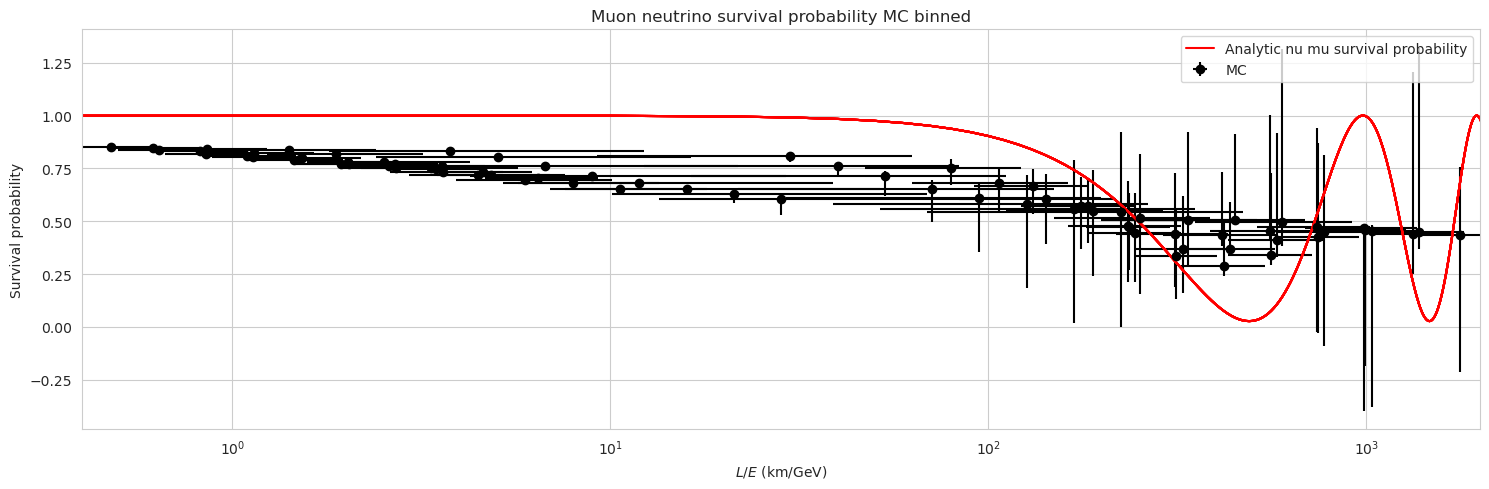

In [300]:
fig, axs= plt.subplots(10,1, figsize=(15, 20))
for i, ax in zip(range(len(bins_cz)-1), axs):
    ax.errorbar(L_over_E_bin_centers[i], (mu_nc_hist.sum(axis=2)[i] + mu_cc_hist.sum(axis=2)[i])/(unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC", c="k")
    ax.plot(np.linspace(0, 1e5, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 1e5, 10000)), color='red', label='Analytic nu mu survival probability', alpha=0.75) # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(.4, 2000)
    ax.set_ylabel("Survival probability")
    ax.set_title("Muon neutrino survival probability MC binned split up same coszen values")
    ax.legend()
    ax.set_xscale('log')

fig.tight_layout()

fig, ax = plt.subplots(figsize=(15, 5))
for i in range(len(bins_cz)-1):
    ax.plot(np.linspace(0, 1e5, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 1e5, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)
    ax.errorbar(L_over_E_bin_centers[i], (mu_nc_hist.sum(axis=2)[i] + mu_cc_hist.sum(axis=2)[i])/(unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC" if i == 0 else None, c="k")
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(.4, 2000)
    ax.set_ylabel("Survival probability")
    ax.set_title("Muon neutrino survival probability MC binned")
    ax.legend()
    ax.set_xscale('log')
        

fig.tight_layout()

In [276]:
print("Munu MC osc.: ", (mu_nc_hist[:, :, 0][0] + mu_cc_hist[:, :, 0][0]), "\nMunu MC unosc.: ", (unosc_mu_nc_hist[:, :, 0][0] + unosc_mu_cc_hist[:, :, 0][0]), "\nMunu MC osc/unosc: ", (mu_nc_hist[:, :, 0][0] + mu_cc_hist[:, :, 0][0])/(unosc_mu_nc_hist[:, :, 0][0] + unosc_mu_cc_hist[:, :, 0][0]), "\nMunu survival prob.: ", muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers[0]))
print("Munu CC MC osc.: ", mu_cc_hist[:, :, 0][0], "\nMunu CC MC unosc.: ", unosc_mu_cc_hist[:, :, 0][0], "\nMunu CC MC osc/unosc: ", mu_cc_hist[:, :, 0][0]/unosc_mu_cc_hist[:, :, 0][0])

Munu MC osc.:  [249.06591282 413.26585488 377.5191413  320.96565913 217.48872866
 123.78018407  67.04203562  46.97594136] 
Munu MC unosc.:  [569.34519661 939.32355672 832.29487376 731.48319531 535.17402218
 313.565798   151.81784509  87.02190981] 
Munu MC osc/unosc:  [0.43746029 0.43996113 0.45358821 0.43878747 0.4063888  0.39475027
 0.44159523 0.5398174 ] 
Munu survival prob.:  [0.67987213 0.21863605 0.99776086 0.5485545  0.07529839 0.07652237
 0.30401128 0.54210697]
Munu CC MC osc.:  [230.17030595 385.08319805 347.4623596  289.21812378 187.55447381
  97.60129765  48.67121078  30.19213754] 
Munu CC MC unosc.:  [529.69182042 877.65687871 771.18371665 667.59841636 481.01030849
 269.07382407 124.67419826  64.68605134] 
Munu CC MC osc/unosc:  [0.43453627 0.43876281 0.45055718 0.4332217  0.38991778 0.36273056
 0.3903872  0.46674881]


In [318]:
np.array([[xmin[0, 0]], [xmax[0, 0]]]).shape

(2, 1)

/tmp/ipykernel_4936/1968871414.py:53: RuntimeWarning: invalid value encountered in scalar divide
  (mu_nc_hist[:, :, 1][i, j] + mu_cc_hist[:, :, 1][i, j]) /
/tmp/ipykernel_4936/1968871414.py:61: RuntimeWarning: invalid value encountered in divide
  (mu_nc_hist[:, :, 1][i] + mu_cc_hist[:, :, 1][i]) /


995.0903468822494
xmin:  228.7115678740737  xmax:  281.2096531177506  ymin:  0.6404359451205313  ymax:  0.0021739906819279176
746.2124700146153
xmin:  171.50946131932812  xmax:  210.87746066891714  ymin:  0.4509134227778723  ymax:  0.44616096853970855
559.5804250966484
xmin:  128.61394395909053  xmax:  158.1357719353706  ymin:  0.04747312764442624  ymax:  0.38459737133432725
419.6261350420627
xmin:  96.44686104311  xmax:  118.58511356881633  ymin:  0.0487091841973728  ymax:  0.20391009529942228
314.67520965618394
xmin:  72.32494614886272  xmax:  88.92629579039658  ymin:  0.2034333725762888  ymax:  0.21823871727118316
235.97312058199344
xmin:  54.236054684263564  xmax:  66.68530793235277  ymin:  0.20373085939907876  ymax:  0.1636588874731515


/tmp/ipykernel_4936/1968871414.py:94: RuntimeWarning: invalid value encountered in divide
  ax[1].errorbar(L_over_E_bin_centers[i], (mu_nc_hist[:, :, 1][i] + mu_cc_hist[:, :, 1][i])/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC Track-like" if i == 0 else None, c="k")
/tmp/ipykernel_4936/1968871414.py:111: RuntimeWarning: invalid value encountered in divide
  ax.errorbar(L_over_E_bin_centers[i], (mu_nc_hist[:, :, 1][i] + mu_cc_hist[:, :, 1][i])/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC Track-like" if i == 0 else None, c="b", alpha=0.5)


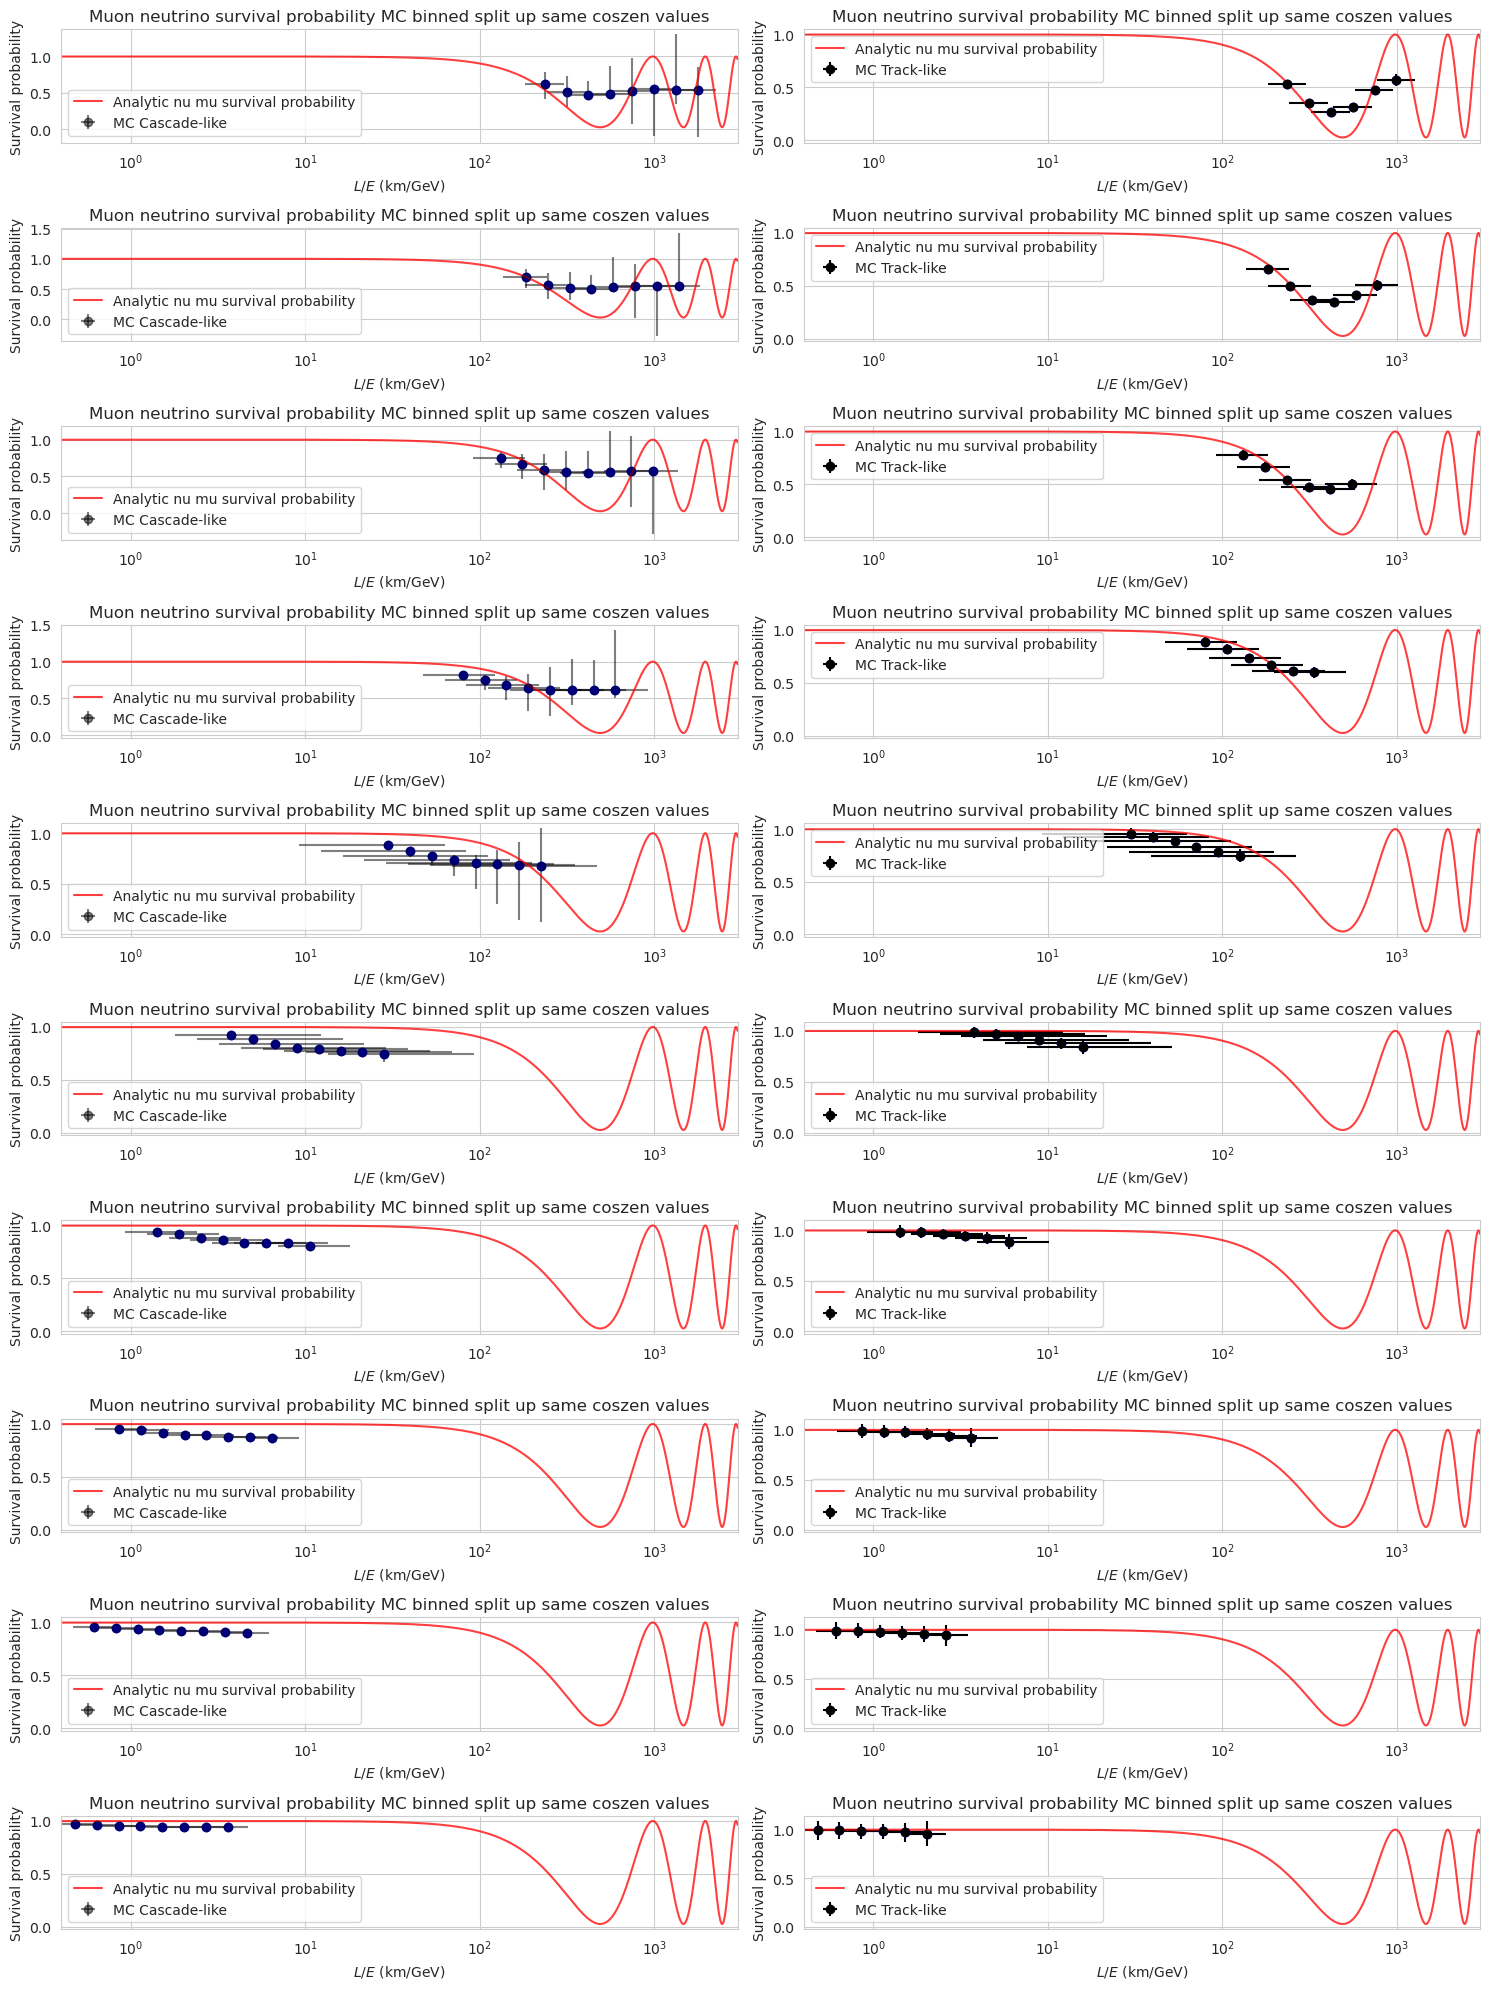

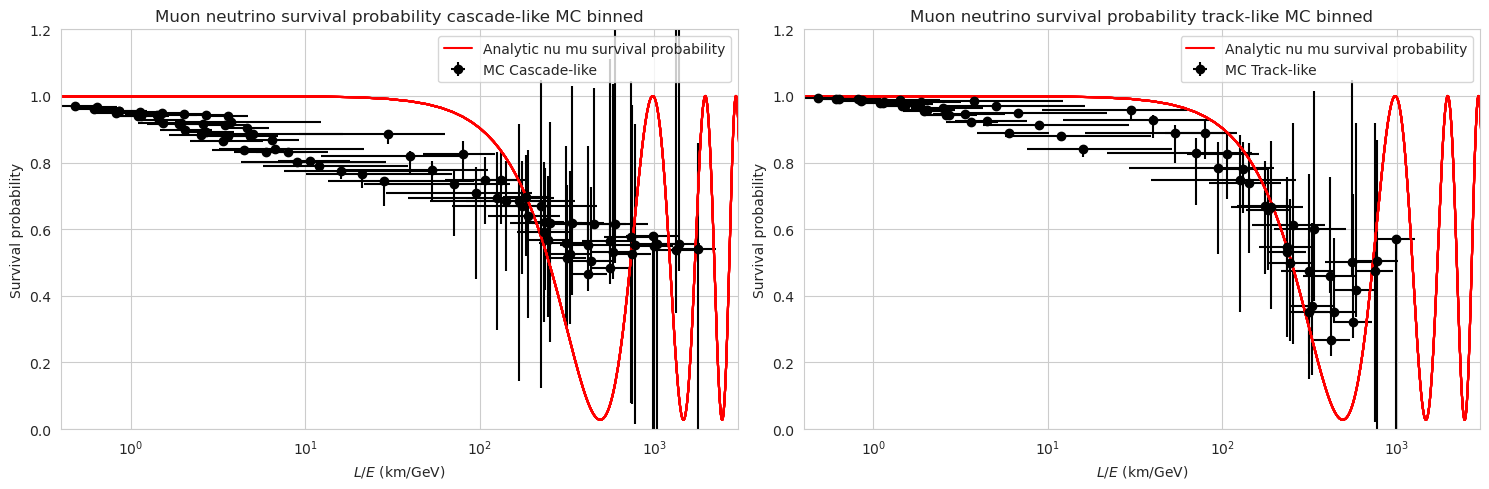

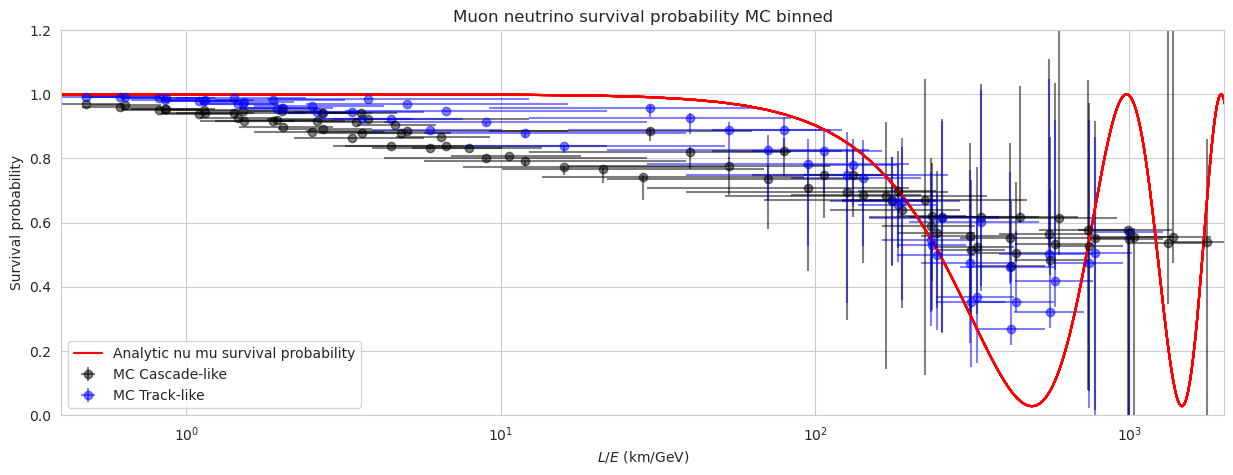

In [331]:
# Calculate unoscillated neutrino weights
unosc_neutrino_weights = neutrino_weights / oscillation_probabilities(neutrinos=neutrinos, delta_m32=2.53e-3, theta_23=49.8)
unosc_neutrino_weights_2 = unosc_neutrino_weights
unosc_neutrino_weights_2[np.abs(neutrinos['pdg']) == 16] = 0

unosc_mu_nc_hist, _ = np.histogramdd([np.log10(mu_nc['reco_energy']),
                                 mu_nc['reco_coszen'],
                                 mu_nc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = unosc_neutrino_weights[int_type == 1])
unosc_mu_nc_hist = np.swapaxes(unosc_mu_nc_hist, 0, 1)

unosc_mu_cc_hist, _ = np.histogramdd([np.log10(mu_cc['reco_energy']),
                                 mu_cc['reco_coszen'],
                                 mu_cc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = unosc_neutrino_weights[int_type == 2])
unosc_mu_cc_hist = np.swapaxes(unosc_mu_cc_hist, 0, 1)

unosc_mu_nc_hist_2, _ = np.histogramdd([np.log10(mu_nc['reco_energy']),
                                    mu_nc['reco_coszen'],
                                    mu_nc['pid']],
                                    bins = [bins_en, bins_cz, bins_pid],
                                    weights = unosc_neutrino_weights_2[int_type == 1])
unosc_mu_nc_hist_2 = np.swapaxes(unosc_mu_nc_hist_2, 0, 1)

unosc_mu_cc_hist_2, _ = np.histogramdd([np.log10(mu_cc['reco_energy']),
                                    mu_cc['reco_coszen'],
                                    mu_cc['pid']],
                                    bins = [bins_en, bins_cz, bins_pid],
                                    weights = unosc_neutrino_weights_2[int_type == 2])
unosc_mu_cc_hist_2 = np.swapaxes(unosc_mu_cc_hist_2, 0, 1)

fig, axs= plt.subplots(10,2, figsize=(15, 20))
for i, ax in zip(range(len(bins_cz)-1), axs[:, 0]):
    ax.errorbar(L_over_E_bin_centers[i], (mu_nc_hist[:, :, 0][i] + mu_cc_hist[:, :, 0][i])/(unosc_mu_nc_hist[:, :, 0][i] + unosc_mu_cc_hist[:, :, 0][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC Cascade-like", c="k", alpha=0.5)
    ax.plot(L_over_E_bin_centers[i], (mu_nc_hist[:, :, 0][i] + mu_cc_hist[:, :, 0][i])/(unosc_mu_nc_hist_2[:, :, 0][i] + unosc_mu_cc_hist_2[:, :, 0][i]), 'o', c="blue")
    ax.plot(np.linspace(0, 1e5, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 1e5, 10000)), color='red', label='Analytic nu mu survival probability', alpha=0.75) # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(.4, 3000)
    ax.set_ylabel("Survival probability")
    ax.set_title("Muon neutrino survival probability MC binned split up same coszen values")
    ax.legend()
    ax.set_xscale('log')

for i, ax in zip(range(len(bins_cz)-1), axs[:, 1]):
    for j in range(len(bins_en)-1):
        xerr = np.array([[xmin[i, j]], [xmax[i, j]]])
        yerr = np.array([[ymin[i, j]], [ymax[i, j]]])
        yerr = np.sqrt((mu_nc_hist[:, :, 1][i, j] + mu_cc_hist[:, :, 1][i, j]))/(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]) if np.any(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]) != 0 else 0
        
        ax.errorbar(L_over_E_bin_centers[i, j], 
                    (mu_nc_hist[:, :, 1][i, j] + mu_cc_hist[:, :, 1][i, j]) / 
                    (unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]), 
                    xerr=xerr, yerr=yerr, fmt='o', label="MC Track-like"  if j == 0 else None, c="k")
        
        if i == 0 and j >= 2:
            print(L_over_E_bin_centers[i, j])
            print("xmin: ", xmin[i,j], " xmax: ", xmax[i,j], " ymin: ", ymin[i,j], " ymax: ", ymax[i,j])
    ax.plot(L_over_E_bin_centers[i], 
                (mu_nc_hist[:, :, 1][i] + mu_cc_hist[:, :, 1][i]) / 
                (unosc_mu_nc_hist_2[:, :, 1][i] + unosc_mu_cc_hist_2[:, :, 1][i]), 
                'o', c="b")
        
    ax.plot(np.linspace(0, 1e5, 10000), 
                muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 1e5, 10000)), 
                color='red', label='Analytic nu mu survival probability', alpha=0.75)
        


    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(.4, 3000)
    ax.set_ylabel("Survival probability")
    ax.set_title("Muon neutrino survival probability MC binned split up same coszen values")
    ax.legend()
    ax.set_xscale('log')

fig.tight_layout()

fig, ax = plt.subplots(1,2, figsize=(15, 5))
for i in range(len(bins_cz)-1):
    ax[0].plot(np.linspace(0, 1e5, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 1e5, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)
    ax[0].errorbar(L_over_E_bin_centers[i], (mu_nc_hist[:, :, 0][i] + mu_cc_hist[:, :, 0][i])/(unosc_mu_nc_hist[:, :, 0][i] + unosc_mu_cc_hist[:, :, 0][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC Cascade-like" if i == 0 else None, c="k")
    ax[0].set_xlabel(r"$L/E$ (km/GeV)")
    ax[0].set_xlim(.4, 3000)
    ax[0].set_ylabel("Survival probability")
    ax[0].set_title("Muon neutrino survival probability cascade-like MC binned")
    ax[0].set_ylim(0, 1.2)
    ax[0].legend()
    ax[0].set_xscale('log')

for i in range(len(bins_cz)-1):
    ax[1].plot(np.linspace(0, 1e5, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 1e5, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)
    ax[1].errorbar(L_over_E_bin_centers[i], (mu_nc_hist[:, :, 1][i] + mu_cc_hist[:, :, 1][i])/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC Track-like" if i == 0 else None, c="k")
    ax[1].set_xlabel(r"$L/E$ (km/GeV)")
    ax[1].set_xlim(.4, 3000)
    ax[1].set_ylabel("Survival probability")
    ax[1].set_title("Muon neutrino survival probability track-like MC binned")
    ax[1].set_ylim(0, 1.2)
    ax[1].legend()
    ax[1].set_xscale('log')
        

fig.tight_layout()

fig, ax = plt.subplots(figsize=(15, 5))

for i in range(len(bins_cz)-1):
    ax.plot(np.linspace(0, 1e5, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 1e5, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)
    ax.errorbar(L_over_E_bin_centers[i], (mu_nc_hist[:, :, 0][i] + mu_cc_hist[:, :, 0][i])/(unosc_mu_nc_hist[:, :, 0][i] + unosc_mu_cc_hist[:, :, 0][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC Cascade-like" if i == 0 else None, c="k" ,alpha=0.5)
    ax.errorbar(L_over_E_bin_centers[i], (mu_nc_hist[:, :, 1][i] + mu_cc_hist[:, :, 1][i])/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC Track-like" if i == 0 else None, c="b", alpha=0.5)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(.4, 2000)
    ax.set_ylabel("Survival probability")
    ax.set_title("Muon neutrino survival probability MC binned")
    ax.set_ylim(0, 1.2)
    ax.legend()
    ax.set_xscale('log')


The errorbars >1 and <0 happen because I calculate the max and min probability over the whole width of the x bin, whereas the survival probability is given by divding the oscillated weights by the unoscillated weights. 

Can probably discard the first 4 coszen values b/c no oscillations. Would get rid of most atm. muons this way :=) 

In [377]:
flux_interpolators = get_honda_fluxes()
interpolator = flux_interpolators[14]
adjustment_factor = np.zeros((len(bins_cz)-1, len(bins_en[2:])-1))
# Adjustmet factor per bin for the flux
for i in range(len(bins_cz)-1):
    for j in range(len(bins_en[2:])-1):
        mu_bin_condition = (neutrinos['reco_coszen'] >= bins_cz[i]) & (neutrinos['reco_coszen'] < bins_cz[i+1]) & (neutrinos['reco_energy'] >= 10**bins_en[j+2]) & (neutrinos['reco_energy'] < 10**bins_en[j+3]) & (np.abs(neutrinos['pdg']) == 14)
        neutrinos_in_LE_bin = neutrinos[mu_bin_condition]

        # Make histogram
        neutrinos_in_LE_bin_hist = np.histogramdd([np.log10(neutrinos_in_LE_bin['reco_energy']), 
                                                         neutrinos_in_LE_bin['reco_coszen'], 
                                                         neutrinos_in_LE_bin['pid']], 
                                                         bins = [bins_en, bins_cz, bins_pid],
                                                         weights=neutrino_weights[mu_bin_condition])

        # Calculate average reco_energy and reco_coszen for the highest track LE bin
        average_reco_energy = np.sum(neutrinos_in_LE_bin['reco_energy']*neutrino_weights[mu_bin_condition])/np.sum(neutrino_weights[mu_bin_condition])
        average_reco_coszen = np.sum(neutrinos_in_LE_bin['reco_coszen']*neutrino_weights[mu_bin_condition])/np.sum(neutrino_weights[mu_bin_condition])
        # print("Average reco_energy: ", average_reco_energy, "\nAverage reco_coszen: ", average_reco_coszen, "\n Bin centers: ", 10**bin_centers_en[j+2], bin_centers_cz[i])
        # print('Flux at average reco_energy and reco_coszen: ', interpolator(average_reco_energy, average_reco_coszen))
        # print('Flux at bin center: ', interpolator(10**bin_centers_en[j+2], bin_centers_cz[i]))
        # print('Ratio', interpolator(10**bin_centers_en[j+2], bin_centers_cz[i])/interpolator(average_reco_energy, average_reco_coszen))
        adjustment_factor[i, j] = interpolator(10**bin_centers_en[j+2], bin_centers_cz[i])/interpolator(average_reco_energy, average_reco_coszen)

Average reco_energy:  11.7 
Average reco_coszen:  -0.9000000000000001 
 Bin centers:  11.547820140615283 -0.9
Flux at average reco_energy and reco_coszen:  0.16711192841490144
Flux at bin center:  0.17312242147328832
Ratio 0.9652818334723081
Average reco_energy:  15.600000000000001 
Average reco_coszen:  -0.9 
 Bin centers:  15.399266041793195 -0.9
Flux at average reco_energy and reco_coszen:  0.07088354331013147
Flux at bin center:  0.07400516594326631
Ratio 0.9578188550306348
Average reco_energy:  20.7 
Average reco_coszen:  -0.8999999999999999 
 Bin centers:  20.535250759484647 -0.9
Flux at average reco_energy and reco_coszen:  0.030858685702547253
Flux at bin center:  0.031523706774060536
Ratio 0.9789040966444815
Average reco_energy:  27.7 
Average reco_coszen:  -0.9 
 Bin centers:  27.384196049435378 -0.9
Flux at average reco_energy and reco_coszen:  0.012872417835780319
Flux at bin center:  0.013379455760977219
Ratio 0.96210324737754
Average reco_energy:  36.9 
Average reco_cosze

/tmp/ipykernel_4936/2548964924.py:44: RuntimeWarning: invalid value encountered in divide
  ax.errorbar(L_over_E_bin_centers[i], (nu_hist_honda[:, :, 1][i])/(unosc_honda_hist[:, :, 1][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC Neutrino Track-like", c="k", alpha=0.5)
/tmp/ipykernel_4936/2548964924.py:45: RuntimeWarning: invalid value encountered in divide
  ax.plot(L_over_E_bin_centers[i], (mu_nc_hist[:, :, 1][i] + mu_cc_hist[:, :, 1][i])/(unosc_mu_nc_hist_2[:, :, 1][i] + unosc_mu_cc_hist_2[:, :, 1][i]), 'o', c="b", label="MC Munu Track-like", alpha=0.5)


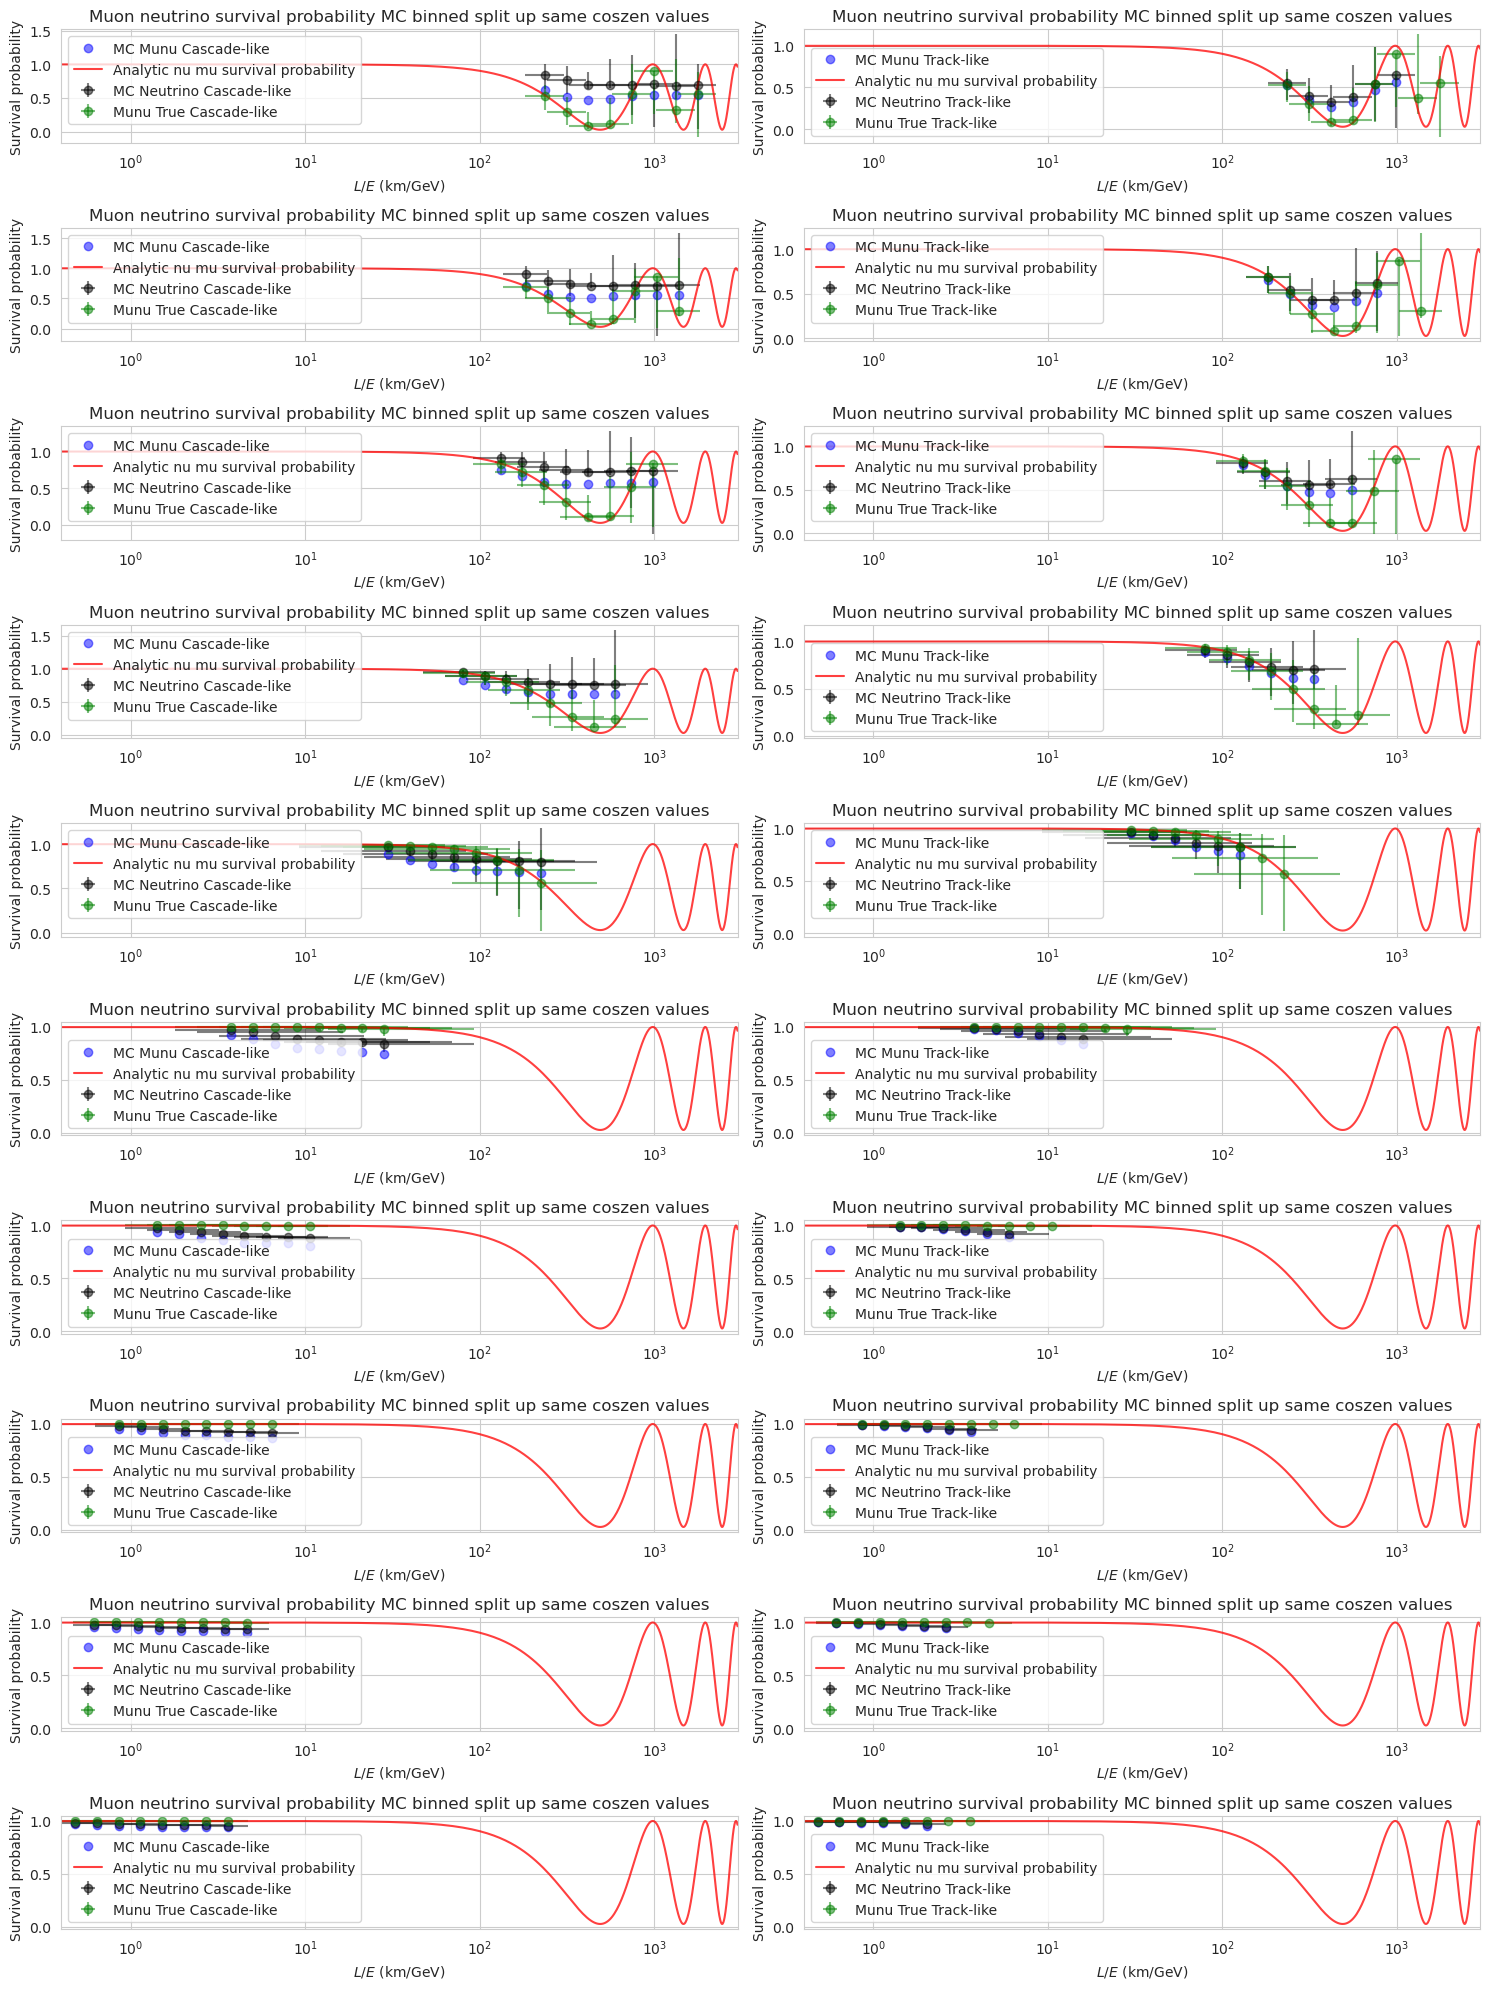

In [278]:
unosc_mu_nc_hist_true_vals, _ = np.histogramdd([np.log10(mu_nc['true_energy']),
                                 mu_nc['true_coszen'],
                                 mu_nc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = unosc_neutrino_weights[int_type == 1])
unosc_mu_nc_hist_true_vals = np.swapaxes(unosc_mu_nc_hist_true_vals, 0, 1)

unosc_mu_cc_hist_true_vals, _ = np.histogramdd([np.log10(mu_cc['true_energy']),
                                 mu_cc['true_coszen'],
                                 mu_cc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = unosc_neutrino_weights[int_type == 2])
unosc_mu_cc_hist_true_vals = np.swapaxes(unosc_mu_cc_hist_true_vals, 0, 1)

mu_nc_hist_true_vals, _ = np.histogramdd([np.log10(mu_nc['true_energy']),
                                    mu_nc['true_coszen'],
                                    mu_nc['pid']],
                                    bins = [bins_en, bins_cz, bins_pid],
                                    weights = neutrino_weights[int_type == 1])
mu_nc_hist_true_vals = np.swapaxes(mu_nc_hist_true_vals, 0, 1)

mu_cc_hist_true_vals, _ = np.histogramdd([np.log10(mu_cc['true_energy']),
                                    mu_cc['true_coszen'],
                                    mu_cc['pid']],
                                    bins = [bins_en, bins_cz, bins_pid],
                                    weights = neutrino_weights[int_type == 2])
mu_cc_hist_true_vals = np.swapaxes(mu_cc_hist_true_vals, 0, 1)


fig, axs= plt.subplots(10,2, figsize=(15, 20))
for i, ax in zip(range(len(bins_cz)-1), axs[:, 0]):
    ax.errorbar(L_over_E_bin_centers[i], (nu_hist_honda[:, :, 0][i])/(unosc_honda_hist[:, :, 0][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC Neutrino Cascade-like", c="k", alpha=0.5)
    ax.plot(L_over_E_bin_centers[i], (mu_nc_hist[:, :, 0][i] + mu_cc_hist[:, :, 0][i])/(unosc_mu_nc_hist_2[:, :, 0][i] + unosc_mu_cc_hist_2[:, :, 0][i]), 'o', c="blue", label="MC Munu Cascade-like", alpha=0.5)
    ax.errorbar(L_over_E_bin_centers[i], (mu_nc_hist_true_vals[:, :, 0][i] + mu_cc_hist_true_vals[:, :, 0][i])/(unosc_mu_nc_hist_true_vals[:, :, 0][i] + unosc_mu_cc_hist_true_vals[:, :, 0][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="Munu True Cascade-like", c="g", alpha=0.5)
    ax.plot(np.linspace(0, 1e5, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 1e5, 10000)), color='red', label='Analytic nu mu survival probability', alpha=0.75) # sin²(m²L/4E)_true_vals
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(.4, 3000)
    ax.set_ylabel("Survival probability")
    ax.set_title("Muon neutrino survival probability MC binned split up same coszen values")
    ax.legend()
    ax.set_xscale('log')

for i, ax in zip(range(len(bins_cz)-1), axs[:, 1]):
    ax.errorbar(L_over_E_bin_centers[i], (nu_hist_honda[:, :, 1][i])/(unosc_honda_hist[:, :, 1][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC Neutrino Track-like", c="k", alpha=0.5)
    ax.plot(L_over_E_bin_centers[i], (mu_nc_hist[:, :, 1][i] + mu_cc_hist[:, :, 1][i])/(unosc_mu_nc_hist_2[:, :, 1][i] + unosc_mu_cc_hist_2[:, :, 1][i]), 'o', c="b", label="MC Munu Track-like", alpha=0.5)
    ax.errorbar(L_over_E_bin_centers[i], (mu_nc_hist_true_vals[:, :, 1][i] + mu_cc_hist_true_vals[:, :, 1][i])/(unosc_mu_nc_hist_true_vals[:, :, 1][i] + unosc_mu_cc_hist_true_vals[:, :, 1][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="Munu True Track-like", c="g", alpha=0.5)
    ax.plot(np.linspace(0, 1e5, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 1e5, 10000)), color='red', label='Analytic nu mu survival probability', alpha=0.75) # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(.4, 3000)
    ax.set_ylabel("Survival probability")
    ax.set_title("Muon neutrino survival probability MC binned split up same coszen values")
    ax.legend()
    ax.set_xscale('log')

fig.tight_layout()


#### Survival probability using the reco values of MC muon neutrinos, no binning

Text(0.5, 1.0, 'MC Muon Neutrino survival probability - Reco values')

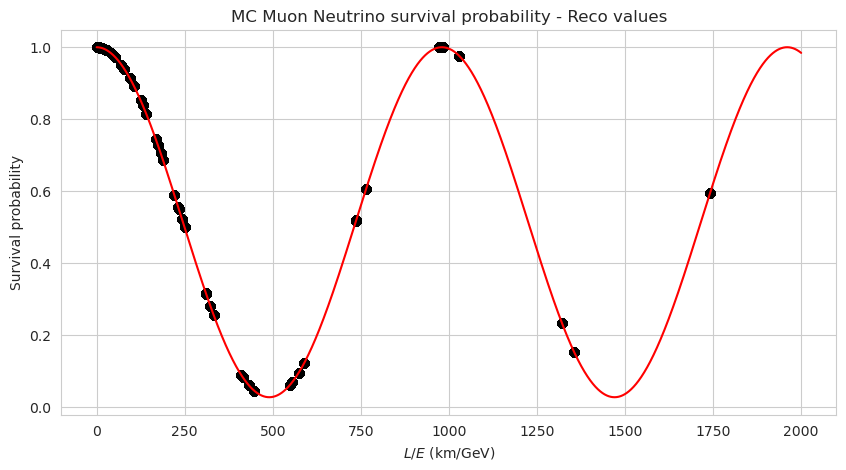

In [279]:
muon_neutrinos = neutrinos[np.abs(neutrinos["pdg"]) == 14]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(calc_path_length_from_coszen(muon_neutrinos['reco_coszen'])/muon_neutrinos['reco_energy'], muon_survival_prob(L_km_over_E_GeV=calc_path_length_from_coszen(muon_neutrinos['reco_coszen'])/muon_neutrinos['reco_energy']), 'o', c="k")
ax.plot(np.linspace(0, 2e3, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 2e3, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)

ax.set_xlabel(r"$L/E$ (km/GeV)")
ax.set_ylabel("Survival probability")
ax.set_title("MC Muon Neutrino survival probability - Reco values")

### Investigation wrong bin reconstruction

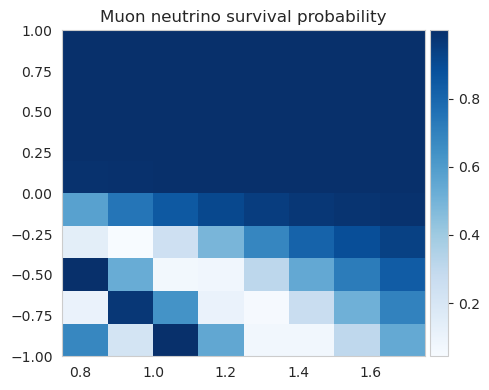

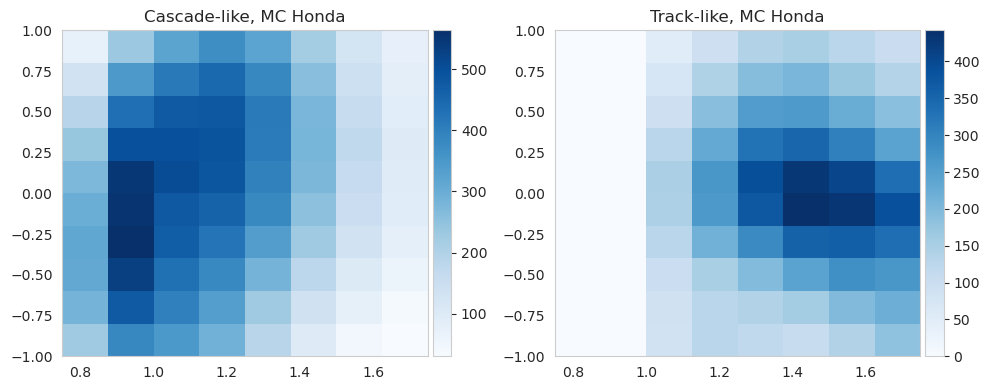

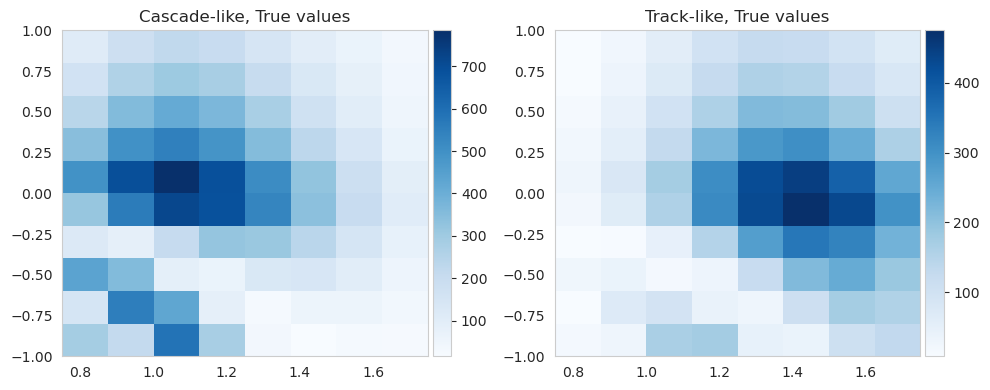

In [280]:
mu_nc_hist_true_vals, _ = np.histogramdd([np.log10(mu_nc['true_energy']),
                                 mu_nc['true_coszen'],
                                 mu_nc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[int_type == 1])

mu_nc_hist_true_vals = np.swapaxes(mu_nc_hist_true_vals, 0, 1)

mu_cc_hist_true_vals, _ = np.histogramdd([np.log10(mu_cc['true_energy']),
                                 mu_cc['true_coszen'],
                                 mu_cc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[int_type == 2])

mu_cc_hist_true_vals = np.swapaxes(mu_cc_hist_true_vals, 0, 1)

fig, ax1 = plt.subplots( figsize=(5, 4))
cmesh = ax1.pcolormesh(bins_en,
                        bins_cz,
                        muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers),
                        cmap='Blues')
ax1.set_title('Muon neutrino survival probability')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

fig.tight_layout()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en,
                        bins_cz,
                        mu_cc_hist[:, :, 0],
                        cmap='Blues')
ax1.set_title('Cascade-like, MC Honda')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en,
                        bins_cz,
                        mu_cc_hist[:, :, 1],
                        cmap='Blues')
ax2.set_title('Track-like, MC Honda')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

fig.tight_layout()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en,
                        bins_cz,
                        mu_cc_hist_true_vals[:, :, 0],
                        cmap='Blues')
ax1.set_title('Cascade-like, True values')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en,
                        bins_cz,
                        mu_cc_hist_true_vals[:, :, 1],
                        cmap='Blues')
ax2.set_title('Track-like, True values')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

fig.tight_layout()

##### What gets reconstructed badly (i.e. into the signal bins)?

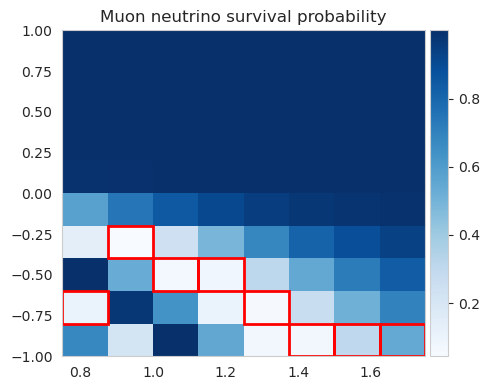

In [281]:
# Calculate the coszen bin widths
bin_widths_cz = np.diff(bins_cz)

# Get the coordinates of bins with the smalles muon neutrino survival probability
min_survival_prob = np.min(muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers), axis=0)
min_survival_prob_idx = np.argmin(muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers), axis=0)

# Highlight the bins with the smallest survival probability with a red frame 
fig, ax = plt.subplots(figsize=(5, 4))
cmesh = ax.pcolormesh(bins_en,
                        bins_cz,
                        muon_survival_prob(L_km_over_E_GeV=L_over_E_bin_centers),
                        cmap='Blues')
ax.set_title('Muon neutrino survival probability')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

for i, j in enumerate(min_survival_prob_idx):
    ax.add_patch(Rectangle((bins_en[i], bins_cz[j]), bin_widths_en[i], bin_widths_cz[j], edgecolor='red', fill=None, linewidth=2))

fig.tight_layout()

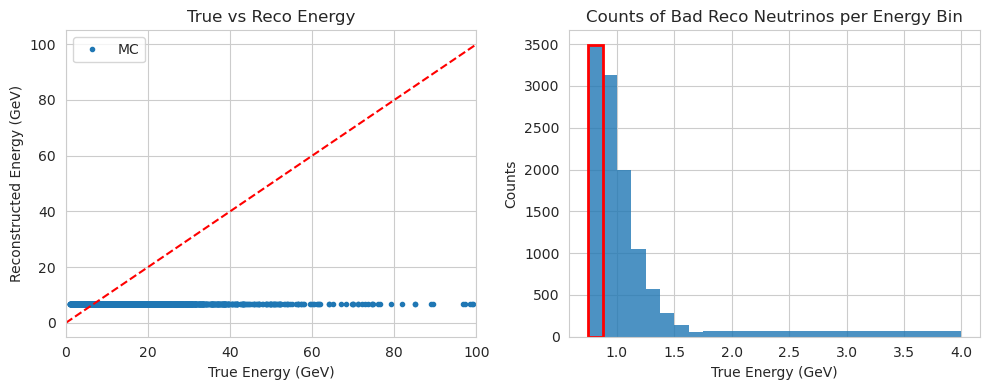

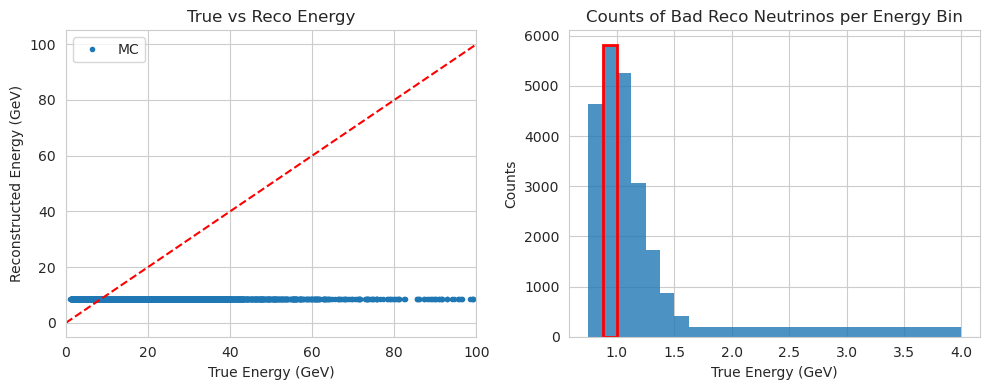

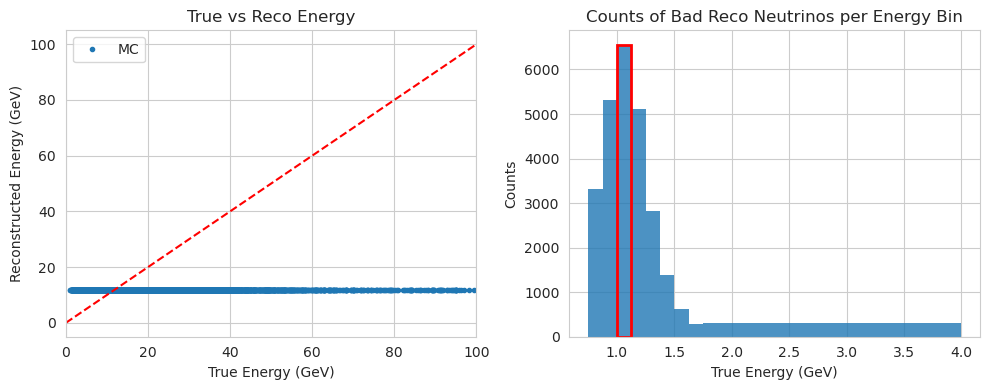

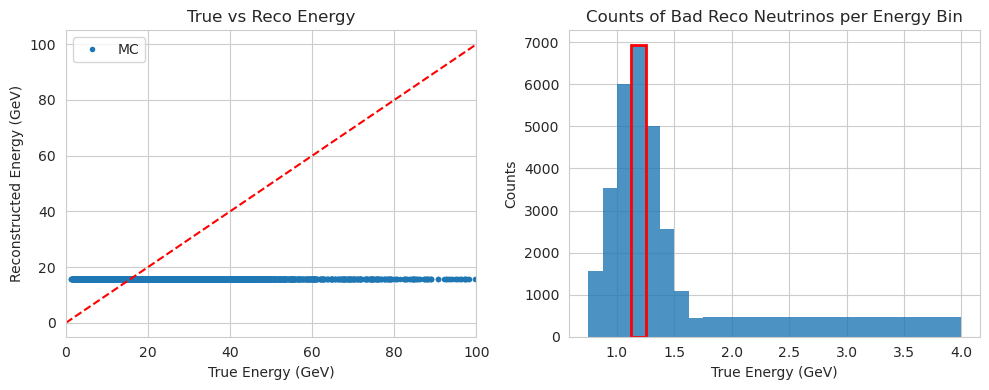

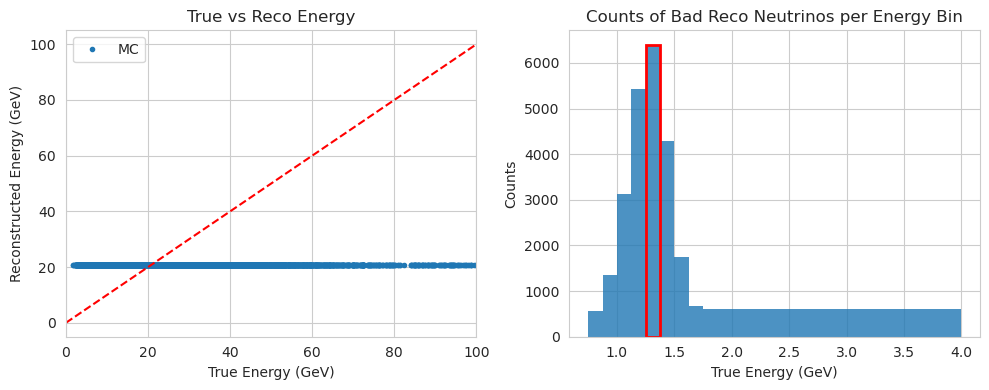

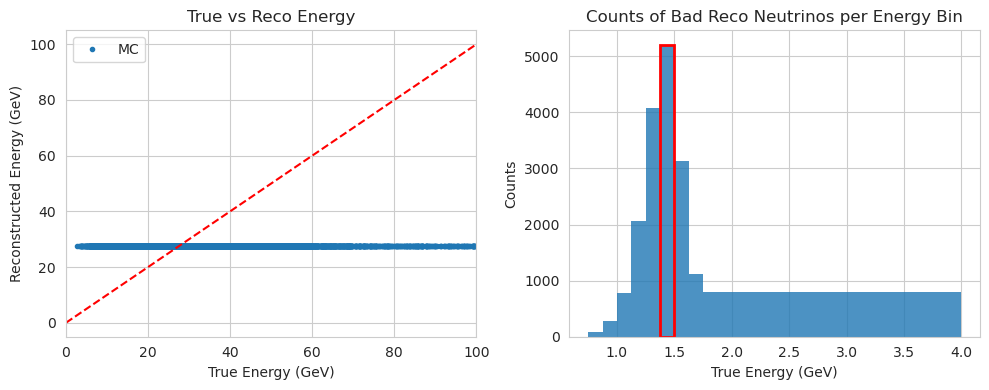

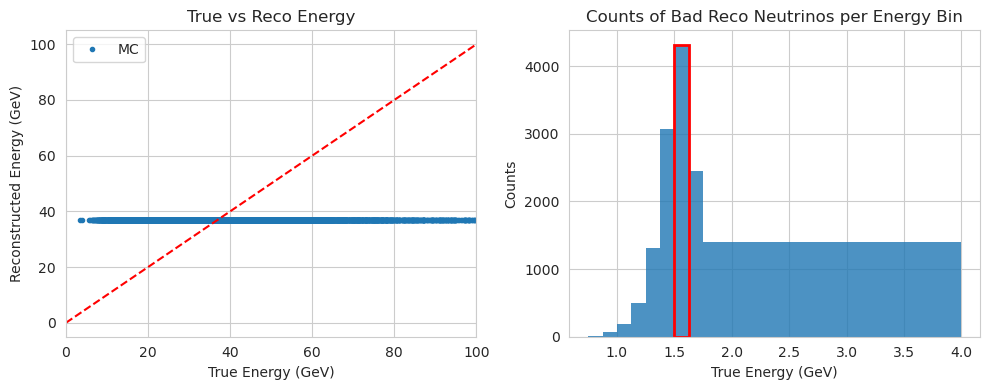

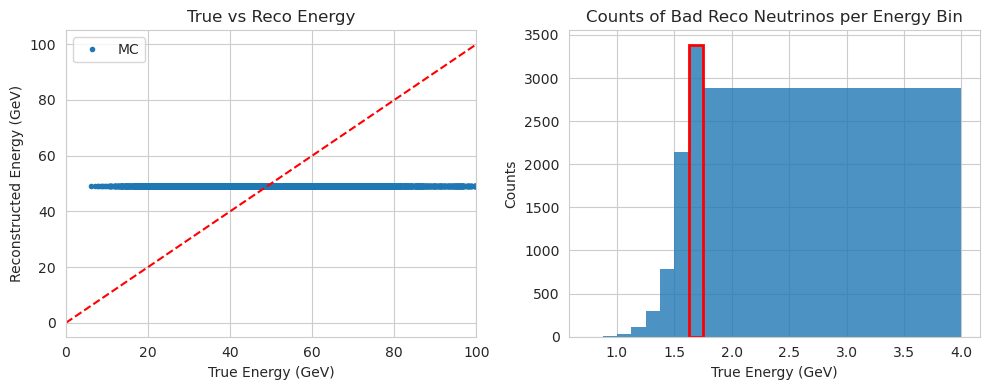

In [282]:
 # Extract mu neutrinos
int_type = (np.abs(neutrinos["pdg"]) == 14).astype(int) # non-mu neutrino is 0, mu neutrino NC is 1
int_type[(int_type == 1) & (neutrinos["type"] > 0)] = 2 # mu CC is 2


# Extract neutrinos that get reconstructed into the bins with the smallest survival probability
for i, j in enumerate(min_survival_prob_idx):
    bad_reco_type = (np.log10(neutrinos["reco_energy"]) >= bins_en[i]) & (np.log10(neutrinos["reco_energy"]) < bins_en[i+1]) & (neutrinos["reco_coszen"] >= bins_cz[j]) & (neutrinos["reco_coszen"] < bins_cz[j+1]).astype(int)
    bad_reco_neutrinos = neutrinos[bad_reco_type == 1]

    # Plot the true energy vs the reconstructed energy of the MC that gets reconstructed into the smallest survival probability bins
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(bad_reco_neutrinos["true_energy"], bad_reco_neutrinos["reco_energy"], '.', label="MC")
    ax1.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), 'r--')
    ax1.set_xlabel('True Energy (GeV)')
    ax1.set_ylabel('Reconstructed Energy (GeV)')
    ax1.set_title('True vs Reco Energy')
    ax1.set_xlim(0, 100)
    ax1.legend()

    # Plot the counts of bad_reco_neutrinos per en_bin
    new_bins_en = np.append(bins_en, 4)
    bad_reco_neutrinos_hist, _ = np.histogramdd([np.log10(bad_reco_neutrinos['true_energy'])],
                                                bins = [new_bins_en],
                                                weights = np.ones_like(bad_reco_neutrinos['true_energy']))
    ax2.stairs(bad_reco_neutrinos_hist, new_bins_en, fill=True, alpha=0.8, label="MC")

    # Add a red dot at the x value where true energy is the same as the reconstructed energy
    ax2.add_patch(Rectangle((bins_en[i], 0), bin_widths_en[i], bad_reco_neutrinos_hist[i], edgecolor='red', fill=None, linewidth=2))


    ax2.set_xlabel('True Energy (GeV)')
    ax2.set_ylabel('Counts')
    ax2.set_title('Counts of Bad Reco Neutrinos per Energy Bin')

    fig.tight_layout()

This was a bit of a waste of time... Of course neutrinos with energies close to the actual signal region get reconstructed into the signal region

### Survival probability data using data_sinal_hist

#### Survival probability cascades + tracks

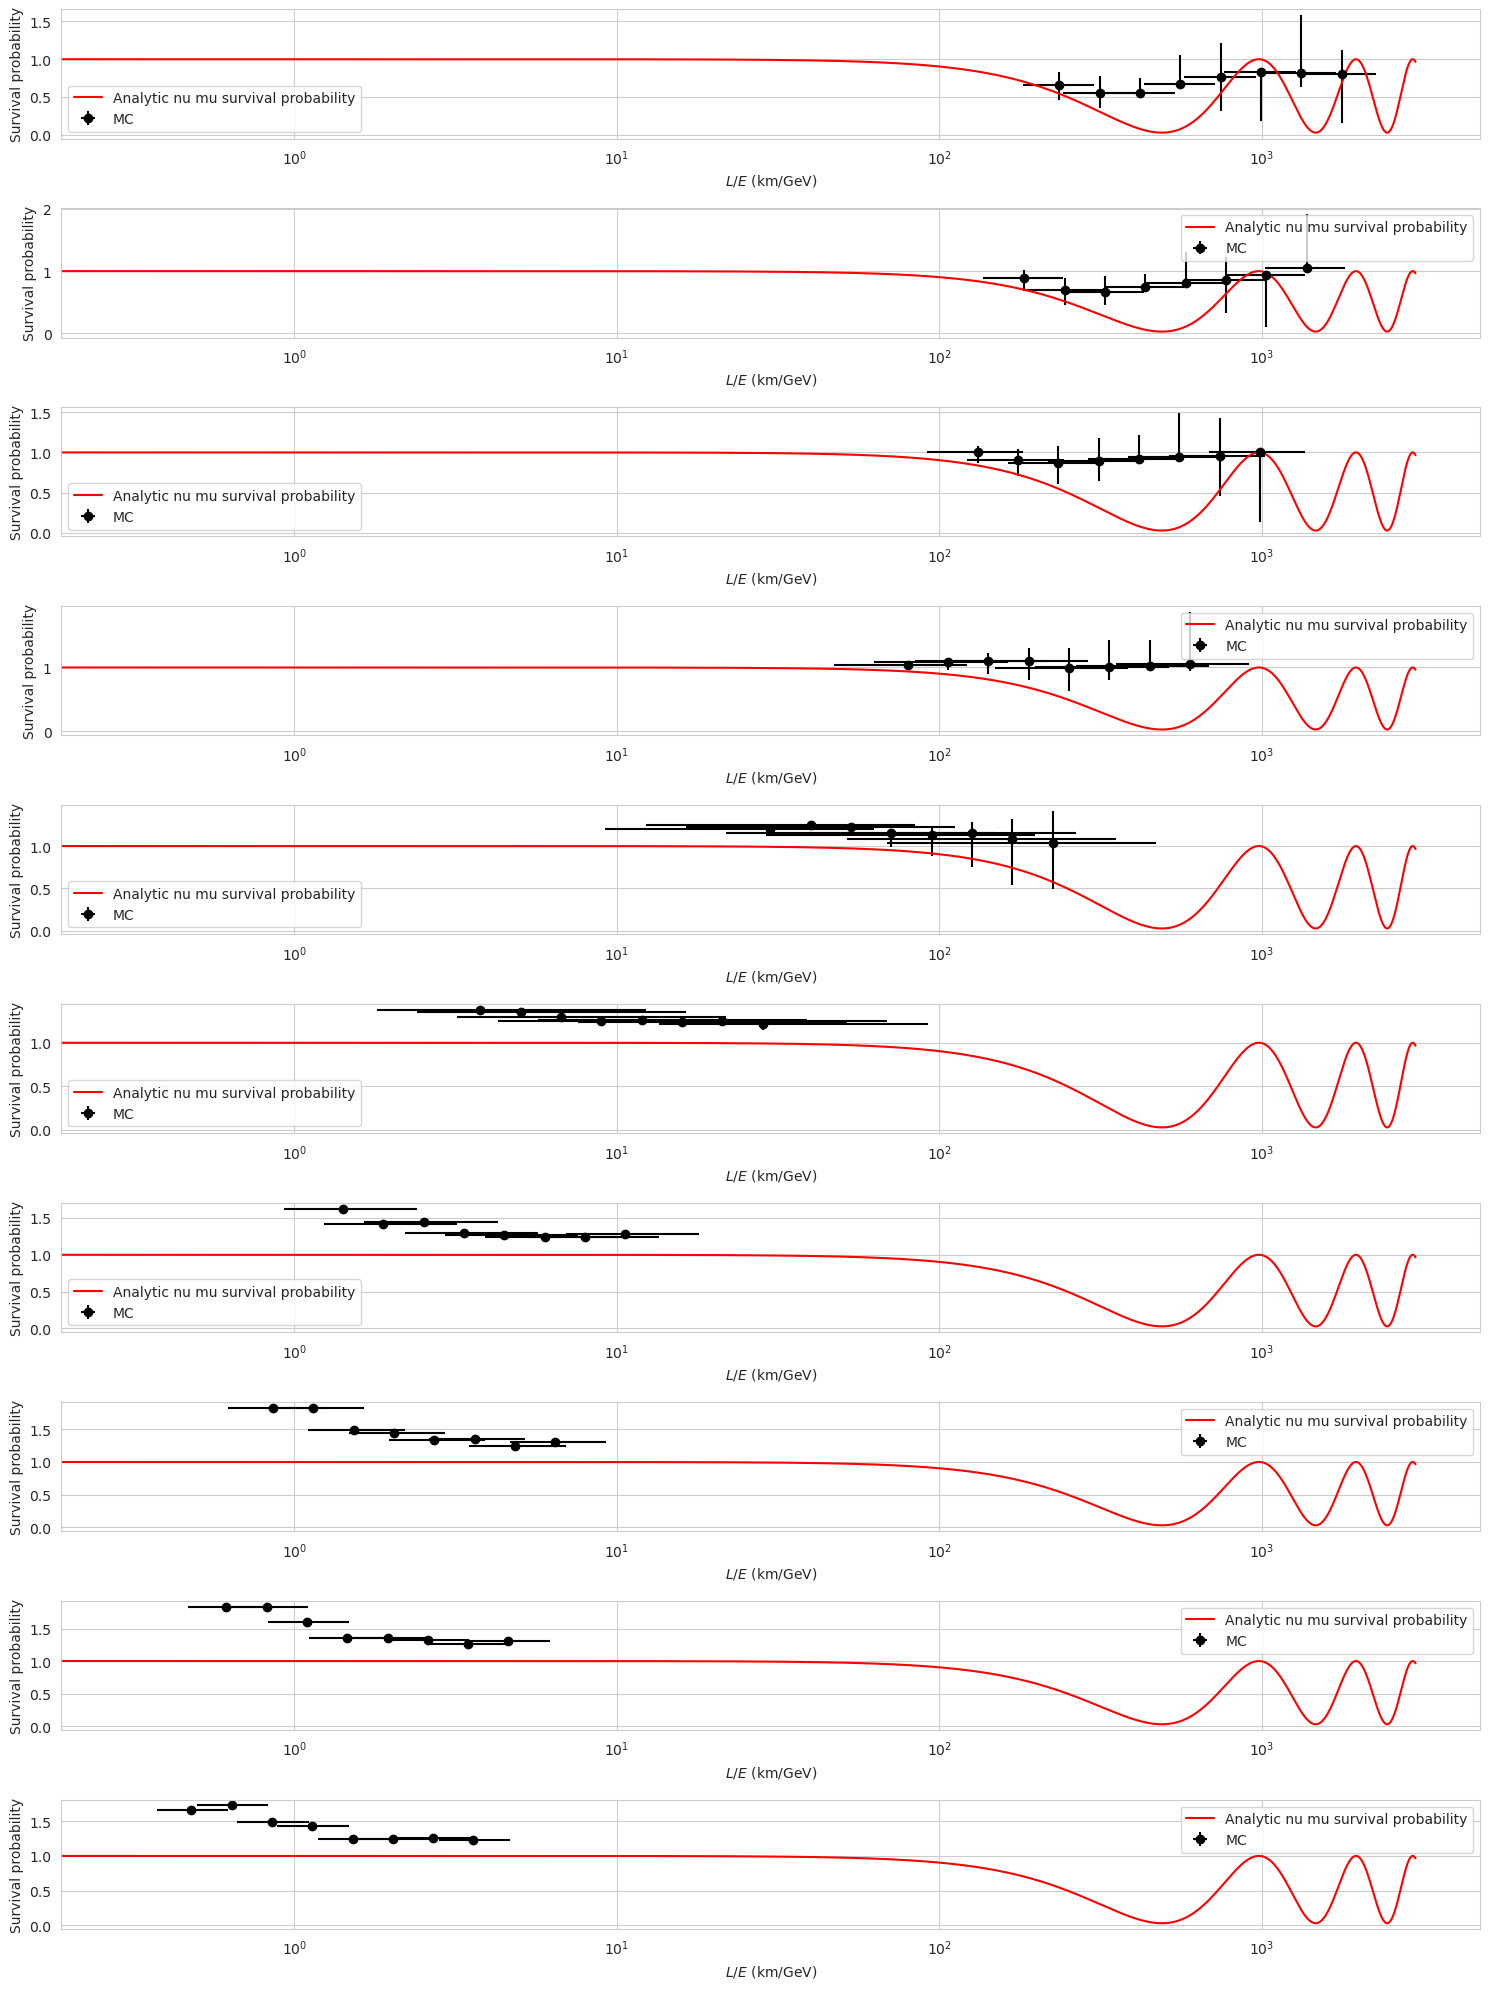

In [283]:
fig, axs= plt.subplots(10,1, figsize=(15, 20))
for i, ax in zip(range(len(bins_cz)-1), axs):
    #ax.errorbar((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist.sum(axis=2)[i]/(unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i]), yerr=np.sqrt(data_signal_hist.sum(axis=2)[i]/(unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i])), fmt='o', label="Data", c="k")
    ax.errorbar(L_over_E_bin_centers[i], data_hist.sum(axis=2)[i]/(unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC", c="k")
    #ax.plot(L_over_E[i], muon_survival_prob(L_km_over_E_GeV=L_over_E[i]), color='blue', label="Muon neutrino survival probability")
    ax.plot(np.linspace(0, 3e3, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 3e3, 10000)), color='red', label='Analytic nu mu survival probability') # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    #ax.set_xlim(10, 18000)
    ax.set_ylabel("Survival probability")
    ax.legend()
    # make x axis logarithmic
    ax.set_xscale('log')


fig.tight_layout()

##### Stacked

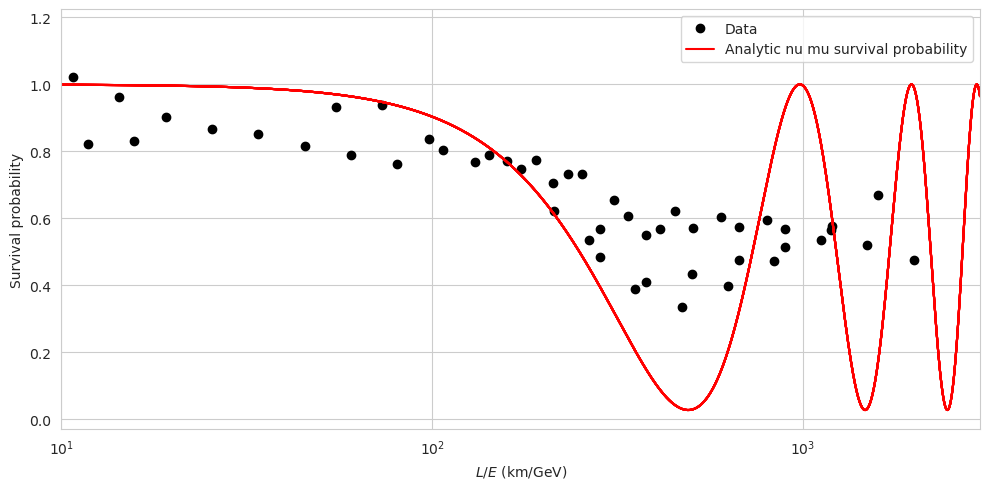

In [284]:
fig, ax= plt.subplots(figsize=(10, 5))
for i in range(len(bins_cz)-1):
    ax.plot((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist.sum(axis=2)[i]/(unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i]), 'o', label="Data" if i == 0 else None, c="k")
    #ax.plot(L_over_E[i], muon_survival_prob(L_km_over_E_GeV=L_over_E[i]), color='blue', label="Muon neutrino survival probability")
    ax.plot(np.linspace(0, 3e3, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 3e3, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(10, 3000)
    ax.set_ylabel("Survival probability")
    ax.legend()
    ax.set_xscale('log')
        

fig.tight_layout()

#### Survival probability tracks


/tmp/ipykernel_4936/1012921051.py:4: RuntimeWarning: invalid value encountered in divide
  ax.errorbar(L_over_E_bin_centers[i], data_signal_hist[:, :, 1][i]/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC", c="k")
/tmp/ipykernel_4936/1012921051.py:35: RuntimeWarning: invalid value encountered in scalar divide
  ax.errorbar(L_over_E_bin_centers[i, j], data_signal_hist[:, :, 1][i, j]/(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]), yerr=np.sqrt(data_signal_hist[:, :, 1][i, j])/(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]), fmt = 'o' , label="Data" if i == 0 and j == 0 else None, c="k")


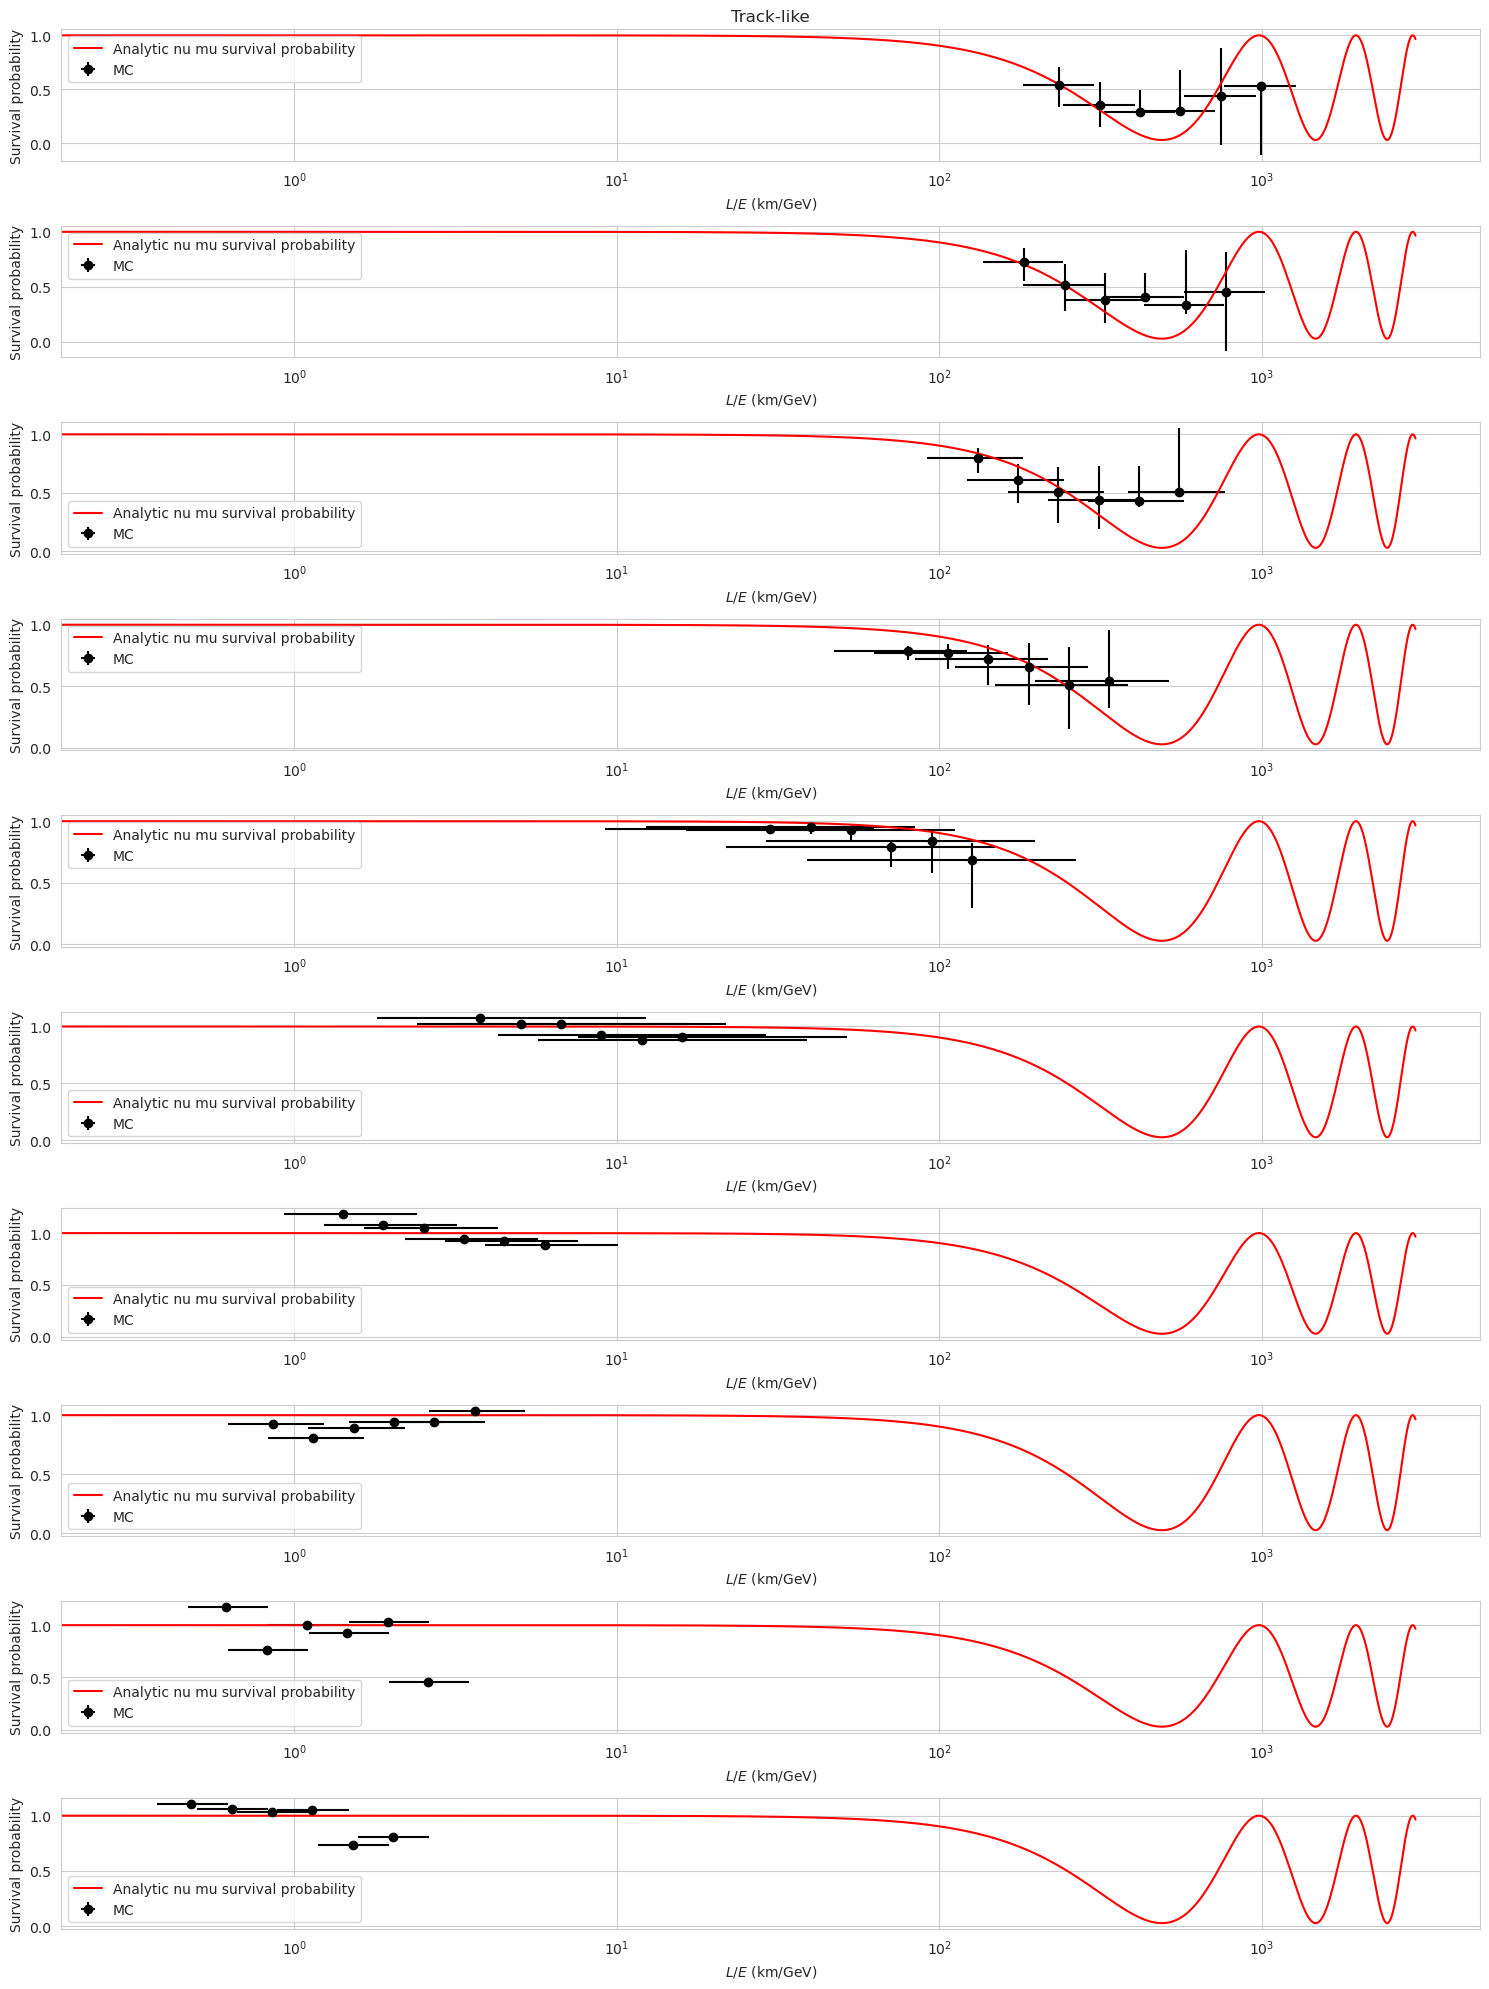

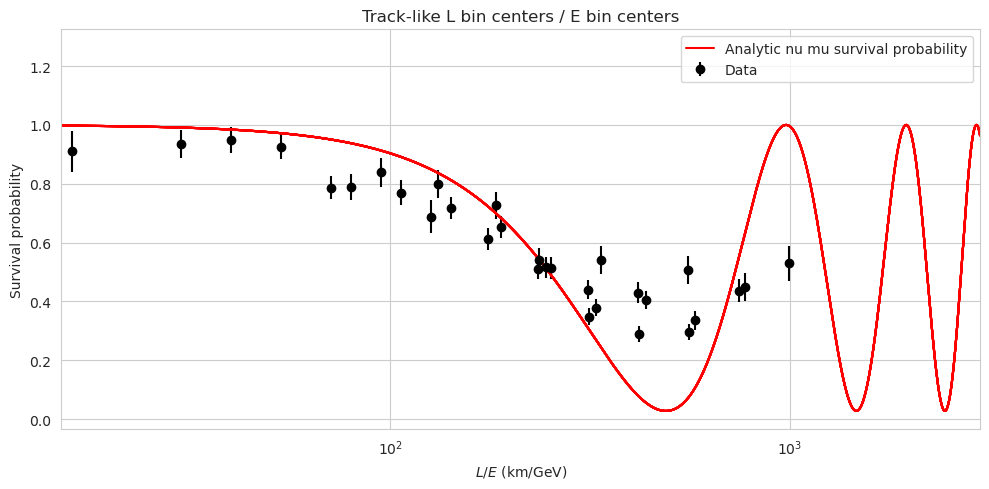

In [285]:
fig, axs= plt.subplots(10,1, figsize=(15, 20))
for i, ax in zip(range(len(bins_cz)-1), axs):
    #ax.errorbar((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist.sum(axis=2)[i]/(unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i]), yerr=np.sqrt(data_signal_hist.sum(axis=2)[i]/(unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i])), fmt='o', label="Data", c="k")
    ax.errorbar(L_over_E_bin_centers[i], data_signal_hist[:, :, 1][i]/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC", c="k")
    #ax.plot(L_over_E[i], muon_survival_prob(L_km_over_E_GeV=L_over_E[i]), color='blue', label="Muon neutrino survival probability")
    ax.plot(np.linspace(0, 3e3, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 3e3, 10000)), color='red', label='Analytic nu mu survival probability') # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    #ax.set_xlim(10, 18000)
    ax.set_ylabel("Survival probability")
    ax.legend()
    ax.set_title("Track-like" if i == 0 else None)
    ax.set_xscale('log')
  

fig.tight_layout()

# fig, ax= plt.subplots(figsize=(10, 5))
# for i in range(len(bins_cz)-1):
#     ax.plot((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist[:, :, 1][i]/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i]), 'o', label="Data" if i == 0 else None, c="k")
#     #ax.plot(L_over_E[i], muon_survival_prob(L_km_over_E_GeV=L_over_E[i]), color='blue', label="Muon neutrino survival probability")
#     ax.plot(np.linspace(0, 3e3, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 3e3, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)
#     ax.set_xlabel(r"$L/E$ (km/GeV)")
#     ax.set_xlim(10, 3000)
#     ax.set_ylabel("Survival probability")
#     ax.legend()
#     ax.set_title("Track-like L/E bin centers")
#     ax.set_xscale('log')
        

# fig.tight_layout()

fig, ax= plt.subplots(figsize=(10, 5))
for i in range(len(bins_cz)-1):
    for j in range(len(bins_en)-1):
        ax.errorbar(L_over_E_bin_centers[i, j], data_signal_hist[:, :, 1][i, j]/(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]), yerr=np.sqrt(data_signal_hist[:, :, 1][i, j])/(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]), fmt = 'o' , label="Data" if i == 0 and j == 0 else None, c="k")
    #ax.plot(L_over_E[i], muon_survival_prob(L_km_over_E_GeV=L_over_E[i]), color='blue', label="Muon neutrino survival probability")
    ax.plot(np.linspace(0, 3e3, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 3e3, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(15, 3000)
    ax.set_ylabel("Survival probability")
    ax.legend()
    ax.set_title("Track-like L bin centers / E bin centers")
    ax.set_xscale('log')
        

fig.tight_layout()

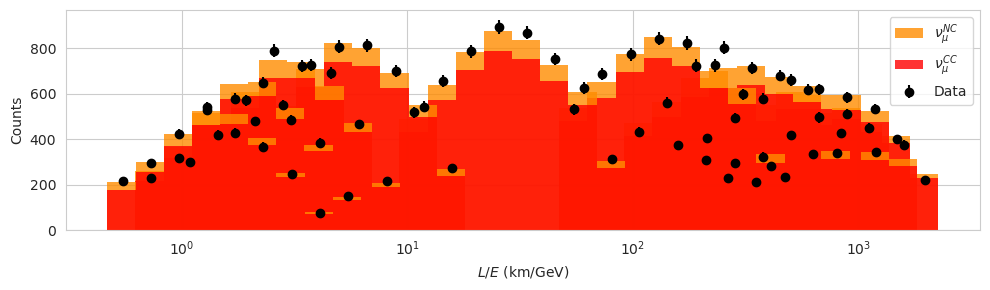

In [286]:
fig, ax = plt.subplots(figsize=(10, 3))
for i in range(len(bins_cz)-1):
    ax.stairs(mu_nc_hist.sum(axis=2)[i] + mu_cc_hist.sum(axis=2)[i], L_over_E[i], fill=True, alpha=0.8, label=r"$\nu_\mu^{NC}$" if i == 0 else None, color="darkorange")
    ax.stairs(mu_cc_hist.sum(axis=2)[i], L_over_E[i], fill=True, alpha=0.8, label=r"$\nu_\mu^{CC}$" if i == 0 else None, color="red")
    ax.errorbar((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist.sum(axis=2)[i], yerr=np.sqrt(data_signal_hist.sum(axis=2)[i]), fmt='o', label="Data" if i == 0 else None, c="k")
#ax.errorbar((L_over_E.flatten()[1:] + L_over_E.flatten()[:-1])/2, data_signal_hist.sum(axis=2).flatten(), yerr=data_proj_err.flatten(), fmt='o', label="Data", c="k")
ax.set_xlabel(r"$L/E$ (km/GeV)")
ax.set_ylabel("Counts")
ax.legend()
ax.set_xscale('log')
fig.tight_layout()

In [432]:
10**(bins_en[2:] + 0.125*3)

array([ 23.71373706,  31.62277821,  42.16965248,  56.23413238,
        74.98941951,  99.99999919, 133.35213724])

#### Survival probability with gravitational center

Min and max adjustment factor:  0.5551860396824276 1.1731575497973816


/tmp/ipykernel_4936/3017174770.py:38: RuntimeWarning: invalid value encountered in divide
  ax.errorbar(L_over_E_bin_centers[i], data_signal_hist[:, :, 1][i]/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="Data", c="k")
/tmp/ipykernel_4936/3017174770.py:54: RuntimeWarning: invalid value encountered in scalar divide
  ax.errorbar(L_over_E_bin_centers[i, j], data_signal_hist[:, :, 1][i, j]/(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]), yerr=np.sqrt(data_signal_hist[:, :, 1][i, j])/(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]), fmt = 'o' , label="Data" if i == 0 and j == 0 else None, c="k")


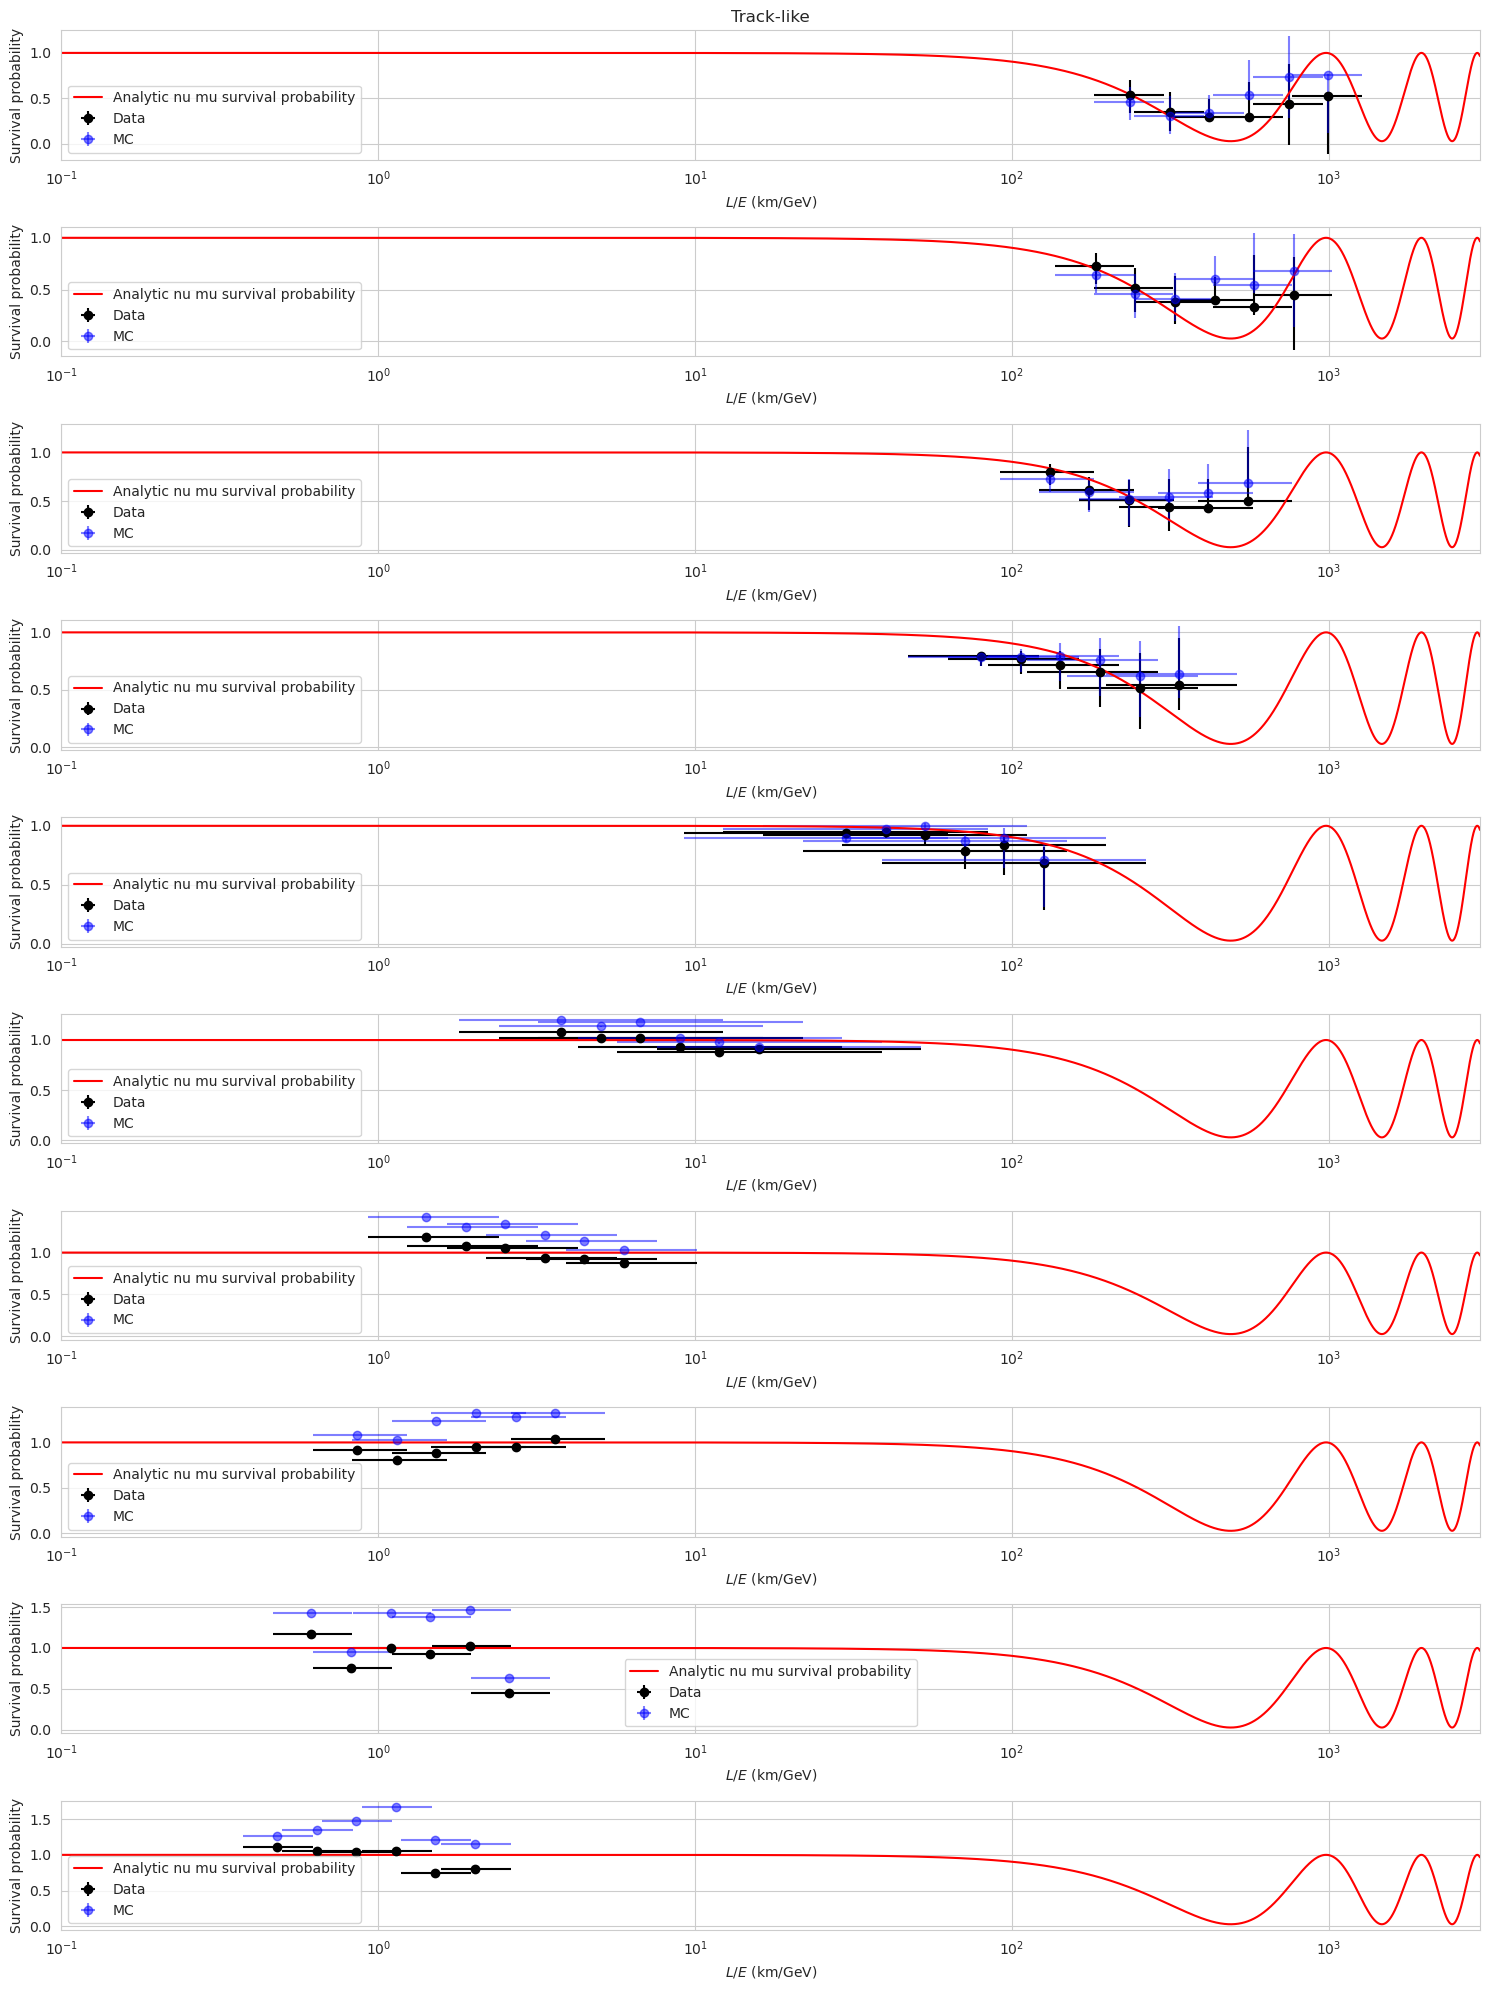

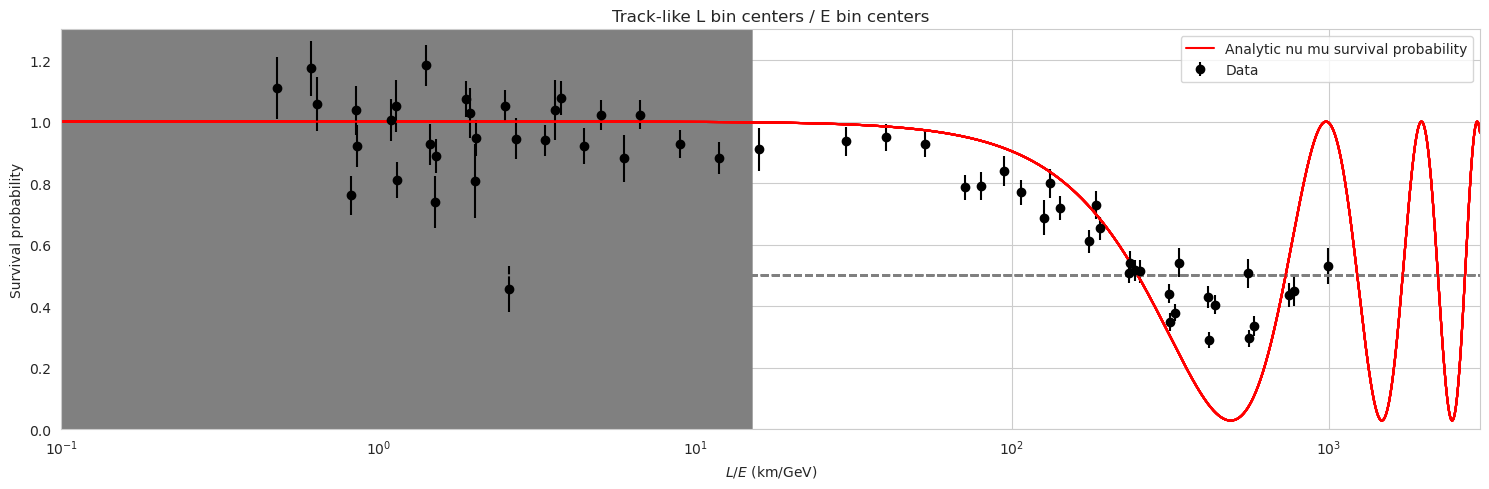

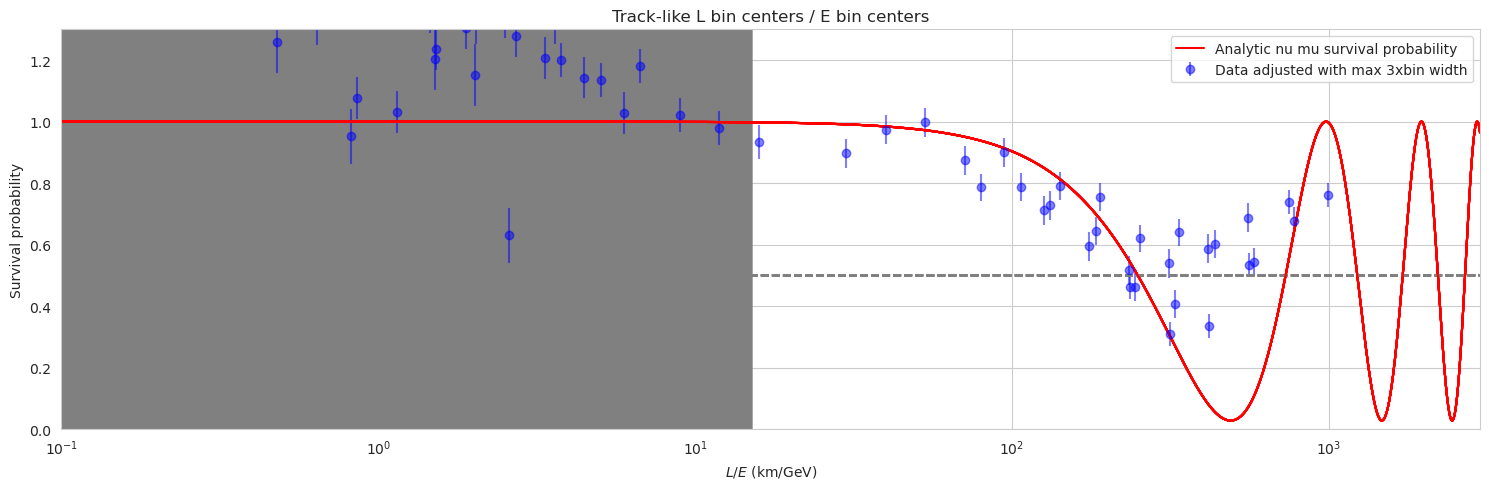

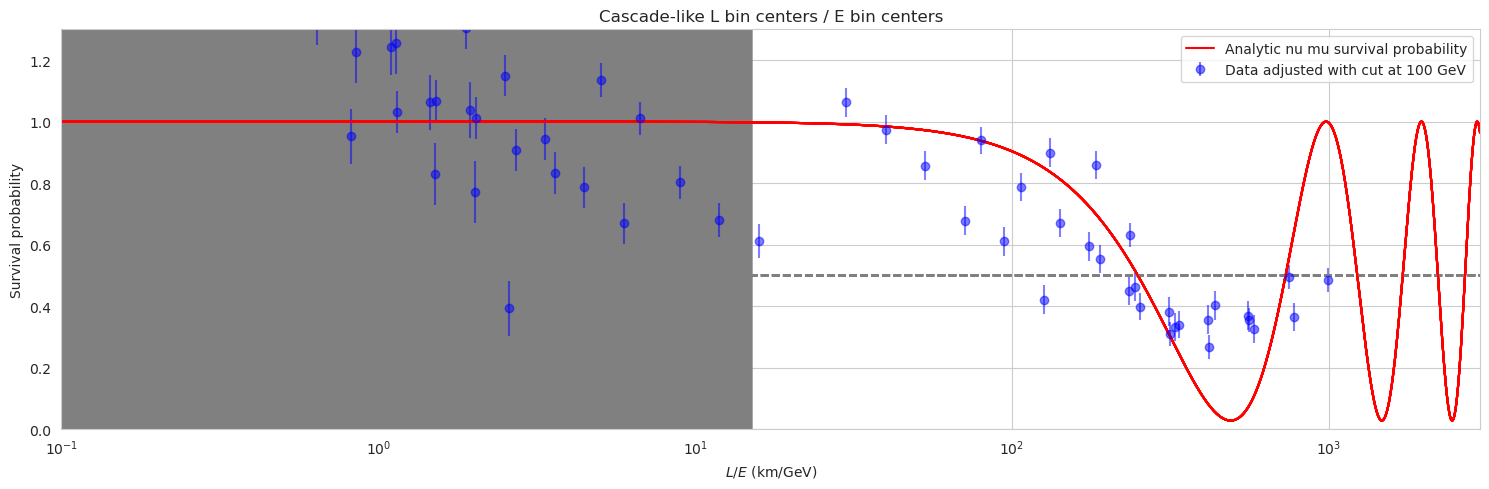

In [436]:

flux_interpolators = get_honda_fluxes()
interpolator = flux_interpolators[14]
adjustment_factor = np.zeros((len(bins_cz)-1, len(bins_en[2:])-1))
adjustment_factor_100 = np.zeros((len(bins_cz)-1, len(bins_en[2:])-1))
# Adjustmet factor per bin for the flux
for i in range(len(bins_cz)-1):
    for j in range(len(bins_en[2:])-1):
        mu_bin_condition = (neutrinos['reco_coszen'] >= bins_cz[i]) & (neutrinos['reco_coszen'] < bins_cz[i+1]) & (neutrinos['reco_energy'] >= 10**bins_en[j+2]) & (neutrinos['reco_energy'] < 10**bins_en[j+3]) & (np.abs(neutrinos['pdg']) == 14)
        neutrinos_in_LE_bin = neutrinos[mu_bin_condition]

        # Make histogram
        neutrinos_in_LE_bin_hist = np.histogramdd([np.log10(neutrinos_in_LE_bin['reco_energy']), 
                                                         neutrinos_in_LE_bin['reco_coszen'], 
                                                         neutrinos_in_LE_bin['pid']], 
                                                         bins = [bins_en, bins_cz, bins_pid],
                                                         weights=neutrino_weights[mu_bin_condition])

        # Calculate average reco_energy and reco_coszen for the highest track LE bin
        average_reco_energy = np.sum(neutrinos_in_LE_bin['reco_energy']*neutrino_weights[mu_bin_condition])/np.sum(neutrino_weights[mu_bin_condition])
        average_reco_coszen = np.sum(neutrinos_in_LE_bin['reco_coszen']*neutrino_weights[mu_bin_condition])/np.sum(neutrino_weights[mu_bin_condition])
        # average_true_energy = np.sum(neutrinos_in_LE_bin['true_energy']*neutrino_weights[mu_bin_condition])/np.sum(neutrino_weights[mu_bin_condition] if neutrinos_in_LE_bin['true_energy'] < 100 else 0)
        average_true_energy = np.sum(np.where(neutrinos_in_LE_bin['true_energy'] < 10**(bins_en[j+3] + 0.125*3), neutrinos_in_LE_bin['true_energy'], 0) * neutrino_weights[mu_bin_condition])/np.sum(neutrino_weights[mu_bin_condition])
        average_true_coszen = np.sum(neutrinos_in_LE_bin['true_coszen']*neutrino_weights[mu_bin_condition])/np.sum(neutrino_weights[mu_bin_condition])
        average_true_energy_100 = np.sum(np.where(neutrinos_in_LE_bin['true_energy'] < 100, neutrinos_in_LE_bin['true_energy'], 0) * neutrino_weights[mu_bin_condition])/np.sum(neutrino_weights[mu_bin_condition])
        #print(10**(bins_en[j+3] + 0.125*2) if i == 0 else None)
        # print("Average reco_energy: ", average_reco_energy, "\nAverage reco_coszen: ", average_reco_coszen, "\n Bin centers: ", 10**bin_centers_en[j+2], bin_centers_cz[i])
        # print("Average true_energy: ", average_true_energy, "\nAverage true_coszen: ", average_true_coszen)
        # print('Flux at average reco_energy and reco_coszen: ', interpolator(average_reco_energy, average_reco_coszen))
        # print('Flux at bin center: ', interpolator(10**bin_centers_en[j+2], bin_centers_cz[i]))
        # print('Ratio', interpolator(10**bin_centers_en[j+2], bin_centers_cz[i])/interpolator(average_reco_energy, average_reco_coszen))
        adjustment_factor[i, j] = interpolator(10**bin_centers_en[j+2], bin_centers_cz[i])/interpolator(average_reco_energy, average_reco_coszen)
        adjustment_factor[i, j] = interpolator(10**bin_centers_en[j+2], bin_centers_cz[i])/interpolator(average_true_energy, average_true_coszen)
        adjustment_factor_100[i, j] = interpolator(10**bin_centers_en[j+2], bin_centers_cz[i])/interpolator(average_true_energy_100, average_true_coszen)

print("Min and max adjustment factor: ", np.min(adjustment_factor), np.max(adjustment_factor))
fig, axs= plt.subplots(10,1, figsize=(15, 20))
for i, ax in zip(range(len(bins_cz)-1), axs):
    ax.errorbar(L_over_E_bin_centers[i], data_signal_hist[:, :, 1][i]/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="Data", c="k")
    ax.errorbar(L_over_E_bin_centers[i][2:], data_signal_hist[:, :, 1][i][2:]/((unosc_mu_nc_hist[:, :, 1][i][2:] + unosc_mu_cc_hist[:, :, 1][i][2:]) * adjustment_factor[i]), xerr=np.array([xmin[i][2:], xmax[i][2:]]), yerr=np.array([ymin[i][2:], ymax[i][2:]]), fmt='o', label="MC", c="b", alpha=0.5)
    ax.plot(np.linspace(0, 3e3, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 3e3, 10000)), color='red', label='Analytic nu mu survival probability') # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(.1, 3000)
    ax.set_ylabel("Survival probability")
    ax.legend()
    ax.set_title("Track-like" if i == 0 else None)
    ax.set_xscale('log')

fig.tight_layout()

fig, ax= plt.subplots(figsize=(15, 5))
for i in range(len(bins_cz)-1):
    ax.plot(np.linspace(0, 3e3, 10000), np.ones_like(np.linspace(0, 3e3, 10000))/2, color='grey', linestyle = '--')
    for j in range(len(bins_en)-1):
        ax.errorbar(L_over_E_bin_centers[i, j], data_signal_hist[:, :, 1][i, j]/(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]), yerr=np.sqrt(data_signal_hist[:, :, 1][i, j])/(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]), fmt = 'o' , label="Data" if i == 0 and j == 0 else None, c="k")
    # ax.errorbar(L_over_E_bin_centers[i][2:], data_signal_hist[:, :, 1][i][2:]/((unosc_mu_nc_hist[:, :, 1][i][2:] + unosc_mu_cc_hist[:, :, 1][i][2:]) * adjustment_factor[i]), xerr=np.array([xmin[i][2:], xmax[i][2:]]), yerr=np.array([ymin[i][2:], ymax[i][2:]]), fmt='o', label="Data adjusted" if i == 0 else None, c="b", alpha=0.5)
    ax.plot(np.linspace(0, 3e3, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 3e3, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.axvspan(0, 15, color='grey', alpha=0.5)
    ax.set_xlim(.1, 3000)
    ax.set_ylim(0, 1.3)
    ax.set_ylabel("Survival probability")
    ax.legend()
    ax.set_title("Track-like L bin centers / E bin centers")
    ax.set_xscale('log')
        

fig.tight_layout()

fig, ax= plt.subplots(figsize=(15, 5))
for i in range(len(bins_cz)-1):
    # for j in range(len(bins_en)-1):
    #     ax.errorbar(L_over_E_bin_centers[i, j], data_signal_hist[:, :, 1][i, j]/(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]), yerr=np.sqrt(data_signal_hist[:, :, 1][i, j])/(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]), fmt = 'o' , label="Data" if i == 0 and j == 0 else None, c="k")
    ax.plot(np.linspace(0, 3e3, 10000), np.ones_like(np.linspace(0, 3e3, 10000))/2, color='grey', linestyle = '--')
    ax.errorbar(L_over_E_bin_centers[i][2:], data_signal_hist[:, :, 1][i][2:]/((unosc_mu_nc_hist[:, :, 1][i][2:] + unosc_mu_cc_hist[:, :, 1][i][2:]) * adjustment_factor[i]), yerr=np.sqrt(data_signal_hist[:, :, 1][i, j])/(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]), fmt='o', label="Data adjusted with max 3xbin width" if i == 0 else None, c="b", alpha=0.5)
    ax.plot(np.linspace(0, 3e3, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 3e3, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    # Add a grey shaded area from x = 0 to x= 15
    ax.axvspan(0, 15, color='grey', alpha=0.5)
    ax.set_xlim(.1, 3000)
    ax.set_ylim(0, 1.3)
    ax.set_ylabel("Survival probability")
    ax.legend()
    ax.set_title("Track-like L bin centers / E bin centers")
    ax.set_xscale('log')
        

fig.tight_layout()

fig, ax= plt.subplots(figsize=(15, 5))
for i in range(len(bins_cz)-1):
    ax.plot(np.linspace(0, 3e3, 10000), np.ones_like(np.linspace(0, 3e3, 10000))/2, color='grey', linestyle = '--')
    ax.errorbar(L_over_E_bin_centers[i][2:], data_signal_hist[:, :, 1][i][2:]/((unosc_mu_nc_hist[:, :, 1][i][2:] + unosc_mu_cc_hist[:, :, 1][i][2:]) * adjustment_factor_100[i]), yerr=np.sqrt(data_signal_hist[:, :, 1][i, j])/(unosc_mu_nc_hist[:, :, 1][i, j] + unosc_mu_cc_hist[:, :, 1][i, j]), fmt='o', label="Data adjusted with cut at 100 GeV" if i == 0 else None, c="b", alpha=0.5)
    ax.plot(np.linspace(0, 3e3, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 3e3, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    # Add a grey shaded area from x = 0 to x= 15
    ax.axvspan(0, 15, color='grey', alpha=0.5)
    ax.set_xlim(.1, 3000)
    ax.set_ylim(0, 1.3)
    ax.set_ylabel("Survival probability")
    ax.legend()
    ax.set_title("Cascade-like L bin centers / E bin centers")
    ax.set_xscale('log')

fig.tight_layout()

### Survival probability using data_hist

/tmp/ipykernel_4936/122311309.py:4: RuntimeWarning: invalid value encountered in divide
  ax.errorbar(L_over_E_bin_centers[i], data_hist[:, :, 1][i]/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i] + nonmu_hist[:, :, 1][i] + muon_hist[:, :, 1][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC", c="k")
/tmp/ipykernel_4936/122311309.py:34: RuntimeWarning: invalid value encountered in divide
  ax.plot(L_over_E_bin_centers[i], data_hist[:, :, 1][i]/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i] + nonmu_hist[:, :, 1][i] + muon_hist[:, :, 1][i]), 'o', label="Data" if i == 0 else None, c="k")


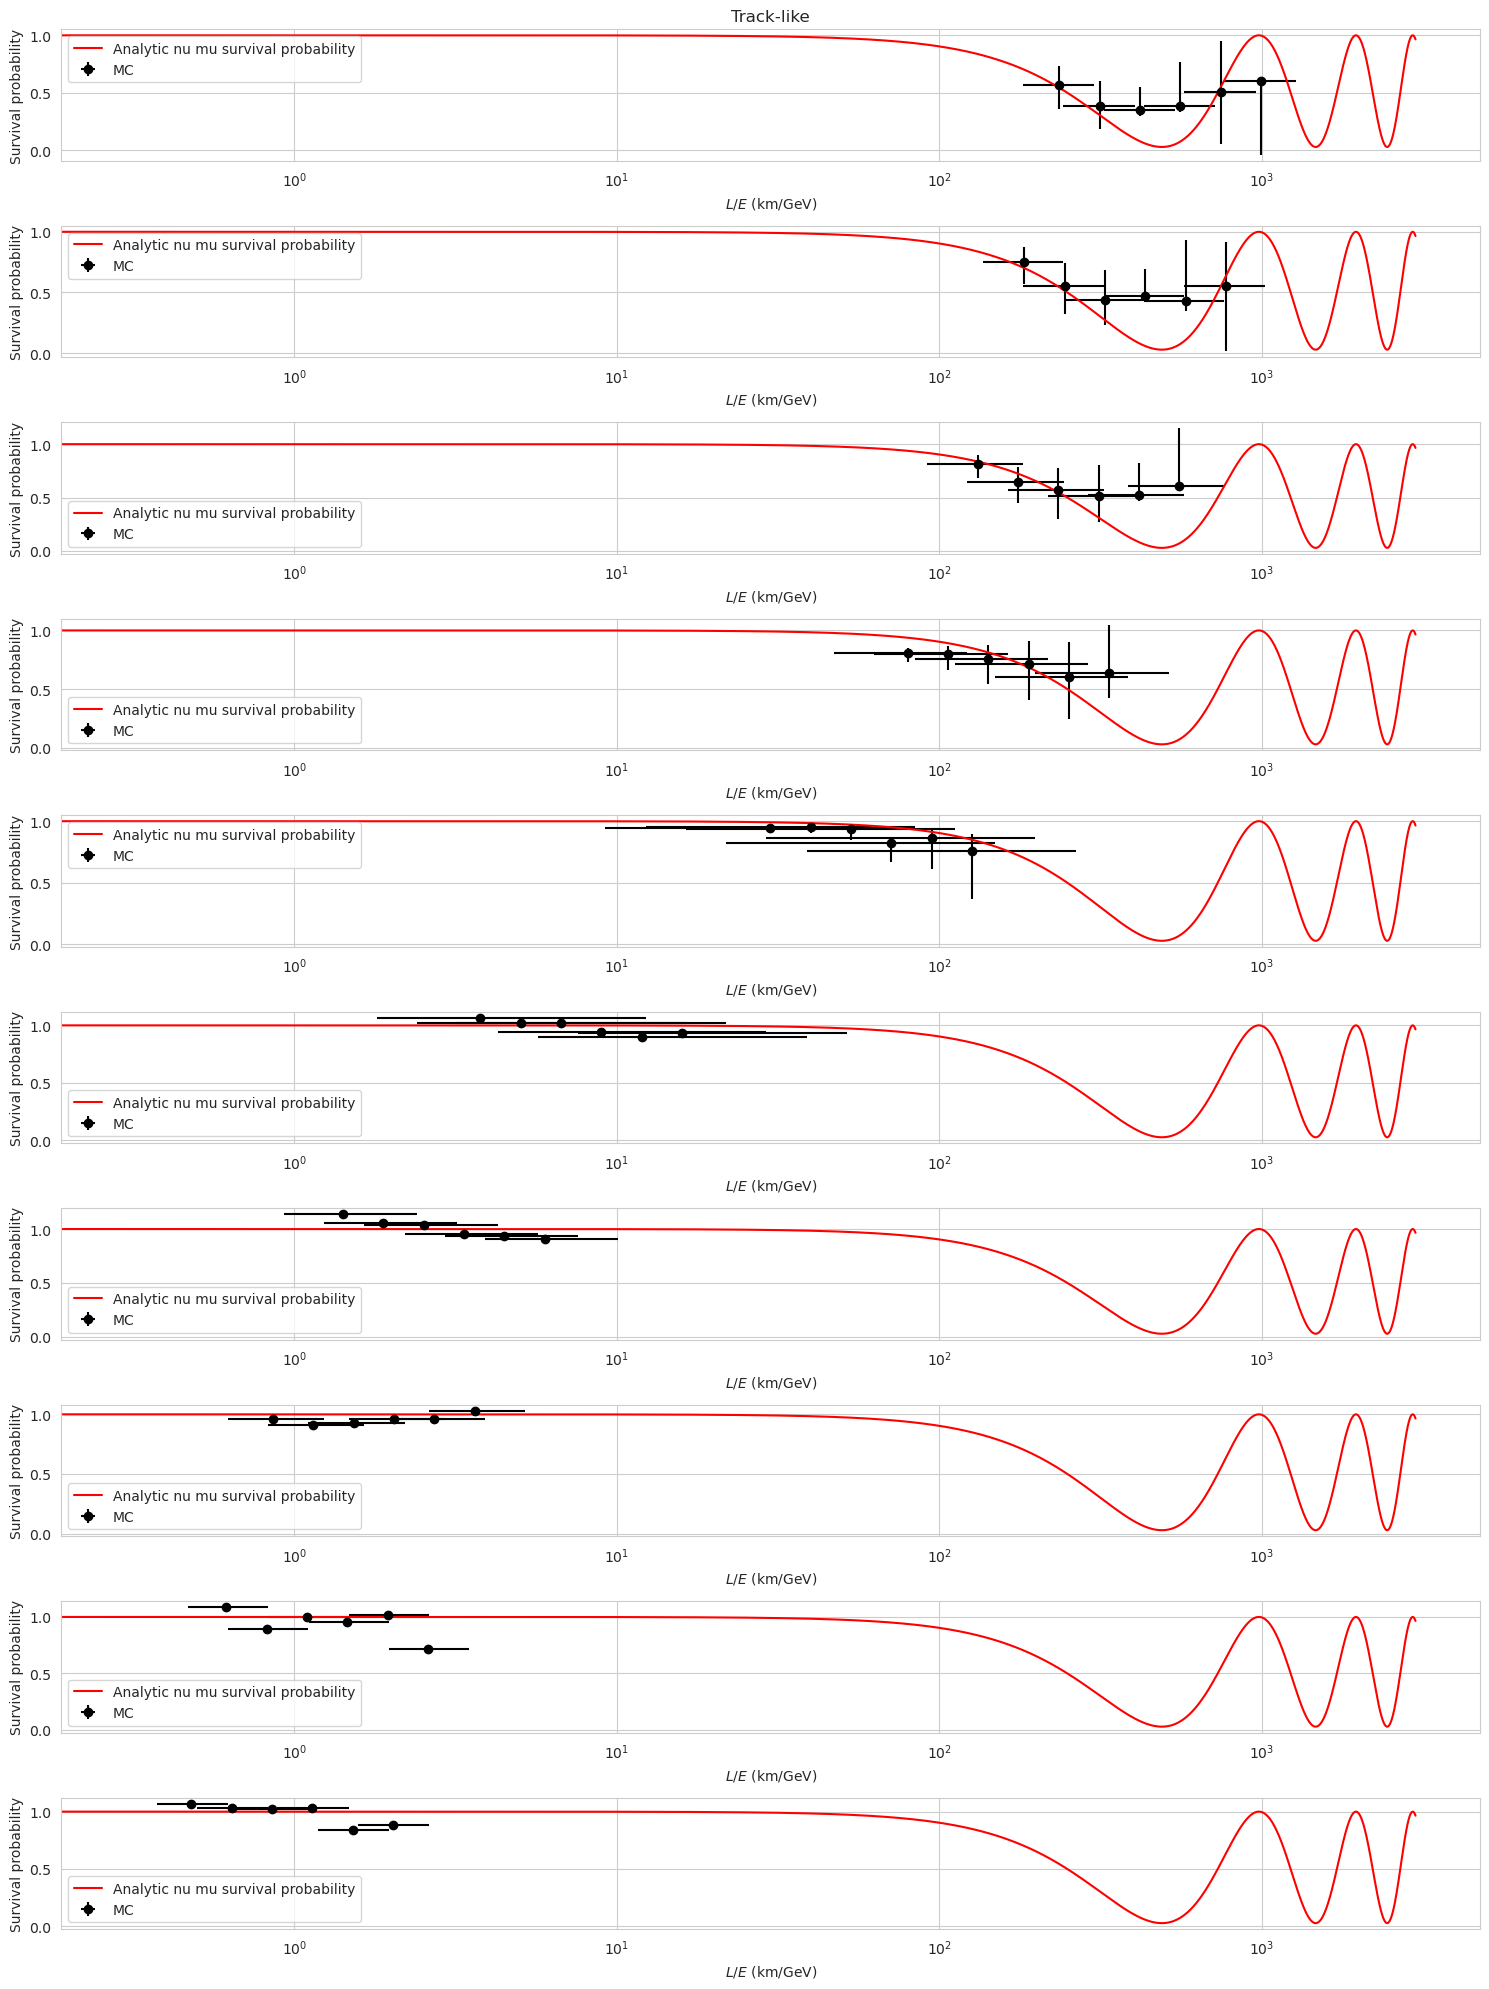

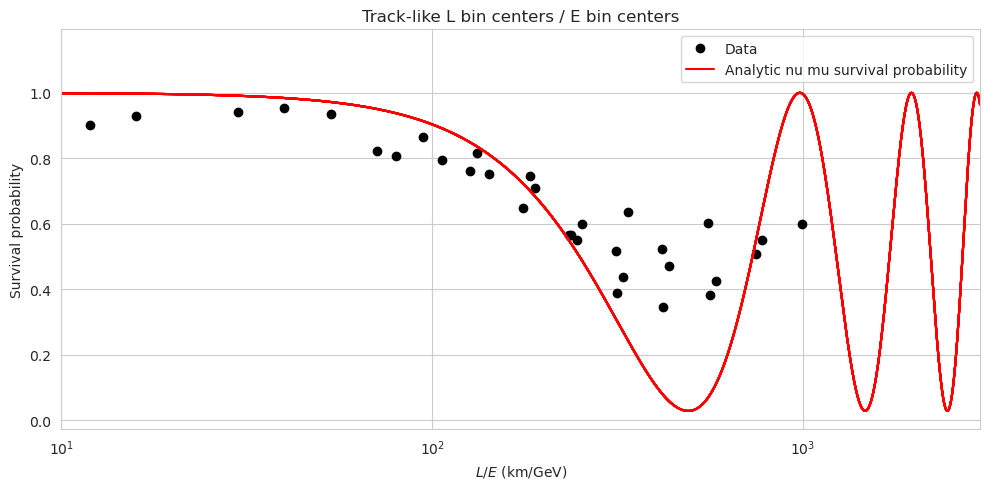

In [287]:
fig, axs= plt.subplots(10,1, figsize=(15, 20))
for i, ax in zip(range(len(bins_cz)-1), axs):
    #ax.errorbar((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_hist.sum(axis=2)[i]/(unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i]), yerr=np.sqrt(data_signal_hist.sum(axis=2)[i]/(unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i])), fmt='o', label="Data", c="k")
    ax.errorbar(L_over_E_bin_centers[i], data_hist[:, :, 1][i]/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i] + nonmu_hist[:, :, 1][i] + muon_hist[:, :, 1][i]), xerr=np.array([xmin[i], xmax[i]]), yerr=np.array([ymin[i], ymax[i]]), fmt='o', label="MC", c="k")
    #ax.plot(L_over_E[i], muon_survival_prob(L_km_over_E_GeV=L_over_E[i]), color='blue', label="Muon neutrino survival probability")
    ax.plot(np.linspace(0, 3e3, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 3e3, 10000)), color='red', label='Analytic nu mu survival probability') # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    #ax.set_xlim(10, 18000)
    ax.set_ylabel("Survival probability")
    ax.legend()
    ax.set_title("Track-like" if i == 0 else None)
    ax.set_xscale('log')
  

fig.tight_layout()

# fig, ax= plt.subplots(figsize=(10, 5))
# for i in range(len(bins_cz)-1):
#     ax.plot((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_hist[:, :, 1][i]/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i] + nonmu_hist[:, :, 1][i] + muon_hist[:, :, 1][i]), 'o', label="Data" if i == 0 else None, c="k")
#     #ax.plot(L_over_E[i], muon_survival_prob(L_km_over_E_GeV=L_over_E[i]), color='blue', label="Muon neutrino survival probability")
#     ax.plot(np.linspace(0, 3e3, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 3e3, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)
#     ax.set_xlabel(r"$L/E$ (km/GeV)")
#     ax.set_xlim(10, 3000)
#     ax.set_ylabel("Survival probability")
#     ax.legend()
#     ax.set_title("Track-like L/E bin centers")
#     ax.set_xscale('log')
        

fig.tight_layout()

fig, ax= plt.subplots(figsize=(10, 5))
for i in range(len(bins_cz)-1):
    ax.plot(L_over_E_bin_centers[i], data_hist[:, :, 1][i]/(unosc_mu_nc_hist[:, :, 1][i] + unosc_mu_cc_hist[:, :, 1][i] + nonmu_hist[:, :, 1][i] + muon_hist[:, :, 1][i]), 'o', label="Data" if i == 0 else None, c="k")
    #ax.plot(L_over_E[i], muon_survival_prob(L_km_over_E_GeV=L_over_E[i]), color='blue', label="Muon neutrino survival probability")
    ax.plot(np.linspace(0, 3e3, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 3e3, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(10, 3000)
    ax.set_ylabel("Survival probability")
    ax.legend()
    ax.set_title("Track-like L bin centers / E bin centers")
    ax.set_xscale('log')
        

fig.tight_layout()

### Scatter plot of all the possible combinations of L/E


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


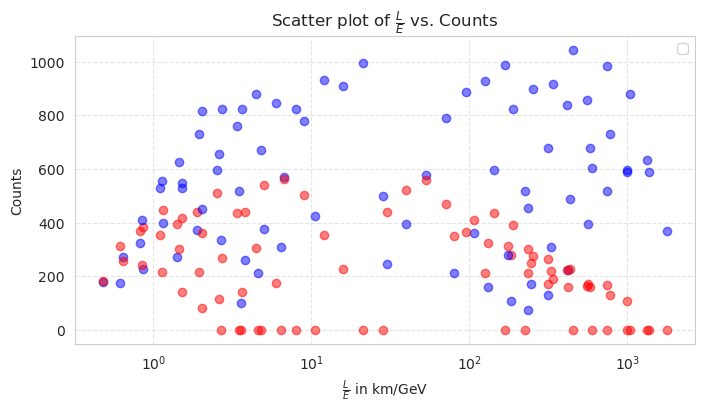

In [288]:
# calculate centers of bins
bins_cz_centers = (bins_cz[1:] + bins_cz[:-1]) / 2
bins_en_centers = (bins_en[1:] + bins_en[:-1]) / 2
bins_pathlength_centers = calc_path_length_from_coszen(bins_cz_centers)

# Scatter plot of all L/E values
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(len(bin_centers_cz)):
    ax.scatter(L_over_E_bin_centers[i], data_hist[:, :, 0][i], color='blue', alpha=0.5, label='Cascade-like' if i==0 and j==0 else None)
    ax.scatter(L_over_E_bin_centers[i], data_hist[: ,: ,1][i], color='red', alpha=0.5, label='Track-like' if i==0 and j==0 else None)
        
#ax.plot(np.linspace(0, 1e5, 1000), 1e3* (1 - np.sin(2*np.deg2rad(best_fit["theta_23"]))**2 * np.sin(best_fit["delta_m32"] * np.linspace(0, 1e5, 1000)/4)**2), color='grey', label='Survival prob') # sin²(m²L/4E)
ax.set_xlabel(r"$\frac{L}{E}$ in km/GeV")
ax.set_ylabel("Counts")
ax.set_title("Scatter plot of $\\frac{L}{E}$ vs. Counts")
ax.set_xscale('log')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)


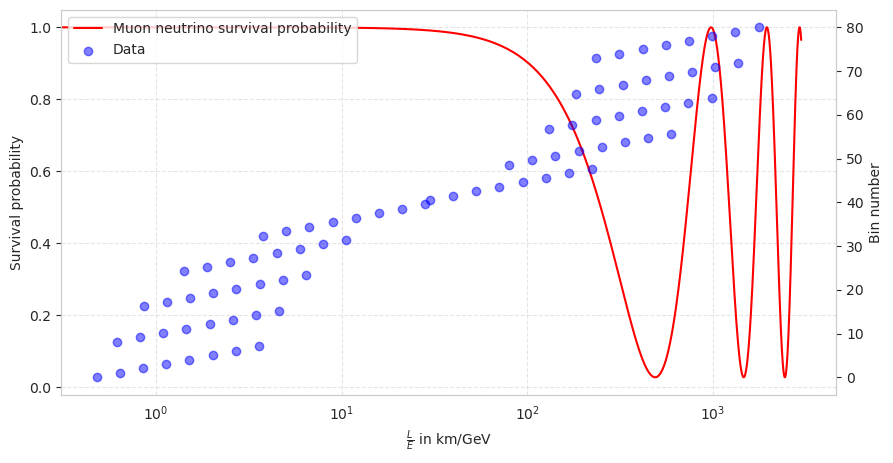

In [289]:
# plot bin centers in growing order
fig, ax = plt.subplots(figsize=(10, 5))
# plot on a second y axis oscillation probability
ax2 = ax.twinx()
ax.plot(np.linspace(0,3000,1000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0,3000,1000)), color='red', label="Muon neutrino survival probability")
ax2.scatter(L_over_E_bin_centers.flatten()[::-1], np.linspace(0,80,80), color='blue', alpha=0.5, label='Data')

ax.set_xlabel(r"$\frac{L}{E}$ in km/GeV")
ax2.set_ylabel("Bin number")
ax.set_ylabel("Survival probability")#
ax.set_xscale('log')
# Combine the legends of ax and ax2
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper left")
ax.grid(True, linestyle='--', alpha=0.5)
ax2.grid(False)
plt.show()



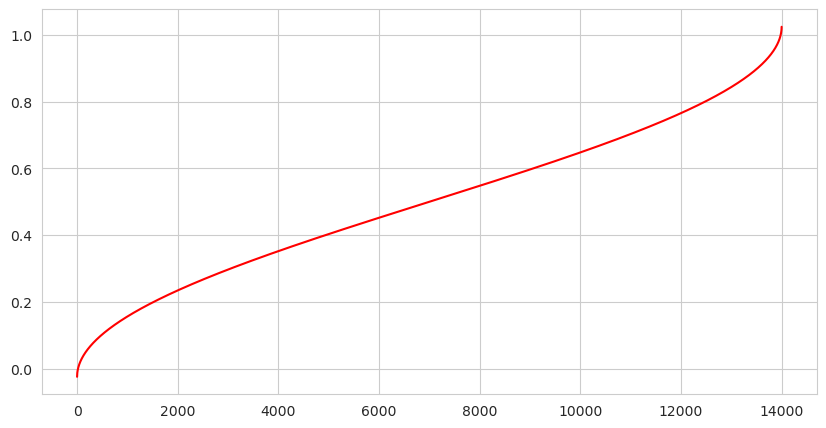

In [290]:
# plot arcsin
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.linspace(0,14000,10000), ((np.arcsin(2*np.linspace(0,14000,10000)/14000-1)+1.5)/3), color='red', label="arcsin")


## Calculate $\chi^2$ value
The data above is the sum of all backgrounds (muon background, non-neutrino backgrounds, and tau neutrino interactions). This should then be compared to the sum of all simulated backgrounds and signal to calculate how well the two distributions match. This is done using a $\chi^2$ test. The $\chi^2$ value is defined as:
$$
\chi^2 = \sum_{i\in \{bins\}} \frac{(N_i^{exp} - N_i^{obs})^2}{N_i^{exp} + (\sigma_i^{exp})^2} + \sum_{j\in\{syst\}} \frac{(s_j - \hat s_j)^2}{\sigma_{s_j}^2}
$$

- $N_i^{exp}$: expected number of events in bin $i$
- $N_i^{obs}$: observed number of events in bin $i$
- $\sigma_i^{exp}$: statistical uncertainty in bin $i$ due to the finite statistics of MC simulations. <!-- Maybe this can be calculated using the weighted errors of the MC events stored in the csv files? TODO ask Chad and Jason -->
- $s_j$: central value of nuisance parameter $j$
- $\hat s_j$: maximum likelihood estimate of nuisance parameter $j$
- $\sigma_{s_j}$: uncertainty in nuisance parameter $j$, from the Gaussian standard deviation of the nuisance parameter

The nuisance parameters, their standard deviations, and their best fit values can be found in table II of the paper.

The final $\chi^2$ value that was achieved for the best fit of all nuisance parameters was 127.6, so we expect to get a similar value.

Later, we want to change the value of the tau normalization to check what $\chi^2$ values we get in those situations.

In [291]:
# Calculate systematic uncertainties
nuisance_parameters = pd.DataFrame({
    "nue_numu_ratio": [1.0, 0.05, 1.03, 1.03],
    "nue_up_hor_flux_ratio": [0.0, 1., -0.42, -0.33],
    "spectral_index": [0., 0.1, 0.03, 0.03],
    "effective_livetime": [np.nan, np.nan, 2.21, 2.24],
    "M_A_quasielastic": [0.99, (0.248+0.149)/2, 1.05, 1.05], # Upper and lower bounds
    "M_A_resonance": [1.12, 0.22, 1., 0.99],
    "NC_norm": [1., 0.2, 1.05, 1.06],
    "theta_13": [8.5, 0.21, np.nan, np.nan],
    "theta_23": [np.nan, np.nan, 49.8, 50.2],
    "delta_m2_32": [np.nan, np.nan, 2.53, 2.56],
    "opt_eff_all": [100, 10, 98.4, 98.4],
    "opt_eff_lat": [0, 1, 0.49, 0.48],
    "opt_eff_headon": [np.nan, np.nan, -0.63, -0.64],
    "bulk_ice_scattering": [100, 10, 103, 102.8],
    "bulk_ice_absorption": [100, 10, 101.5, 101.7],
    "atm_mu_frac": [np.nan, np.nan, 8.1, 8.0],
    "mu_spectral_index": [0., 1., 0.15, 0.15],
    "coin_nu_mu_frac": [0., 0.1, 0.01, 0.01],   # TODO only +, not +-. Maybe the standard deviation is a fraction of 0.1?
    "nu_tau_norm": [np.nan, np.nan, 0.73, 0.57]
}, index=["prior", "prior_error", "best_fit_cc_nc", "best_fit_cc"]).T
nuisance_parameters

prior  prior_error  best_fit_cc_nc  best_fit_cc
nue_numu_ratio           1.00       0.0500            1.03         1.03
nue_up_hor_flux_ratio    0.00       1.0000           -0.42        -0.33
spectral_index           0.00       0.1000            0.03         0.03
effective_livetime        NaN          NaN            2.21         2.24
M_A_quasielastic         0.99       0.1985            1.05         1.05
M_A_resonance            1.12       0.2200            1.00         0.99
NC_norm                  1.00       0.2000            1.05         1.06
theta_13                 8.50       0.2100             NaN          NaN
theta_23                  NaN          NaN           49.80        50.20
delta_m2_32               NaN          NaN            2.53         2.56
opt_eff_all            100.00      10.0000           98.40        98.40
opt_eff_lat              0.00       1.0000            0.49         0.48
opt_eff_headon            NaN          NaN           -0.63        -0.64
bulk_ice_scattering    100.00      10.0000          103.00       102.80
bulk_ice_absorption    100.00      10.0000          101.50       101.70
atm_mu_frac               NaN          NaN            8.10         8.00
mu_spectral_index        0.00       1.0000            0.15         0.15
coin_nu_mu_frac          0.00       0.1000            0.01         0.01
nu_tau_norm               NaN          NaN            0.73         0.57

In [292]:
systematics = nuisance_parameters.dropna(axis=0)
sys_chi2 = np.sum((systematics["prior"] - systematics["best_fit_cc_nc"])**2 / systematics["prior_error"]**2)
sys_chi2

1.4884860019687816

In [293]:
# MC total expected event counts
mc_hist = nu_hist_honda + muon_hist
# Error on the number of events due to the limited MC statistics. 
# TODO can we add these errors like this? I think so but worth double-checking
mc_err = np.sqrt(nu_err**2 + muon_err**2)

In [294]:
def chi2(mc_hist, cascades_count, track_count, mc_err, sys_chi2):
    mc_cascades = mc_hist[:,:,0]
    mc_tracks = mc_hist[:,2:,1]
    mc_cascade_err = mc_err[:,:,0]
    mc_track_err = mc_err[:,2:,1]

    chi2 = (
        np.sum((mc_cascades - cascades_count)**2 / (mc_cascades + mc_cascade_err**2))
        + np.sum((mc_tracks - track_count)**2 / (mc_tracks + mc_track_err**2))
        + sys_chi2
    )
    return chi2

chi2(mc_hist, cascades_count, track_count, mc_err, sys_chi2)

133.27119438449853